<a href="https://colab.research.google.com/github/paris3169/AgenticAI/blob/main/LangGraph_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Setting up the environment##

In [ ]:
!pip install -r requirements.txt

INFO: pip is looking at multiple versions of google-generativeai to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of google-generativeai to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50

In [ ]:
import os
import dotenv

In [ ]:
import dotenv
dotenv.load_dotenv("/content/env.txt")

True

In [ ]:
#importing needed libraries
from typing import List, Annotated, TypedDict, Union, Dict, Any
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.tools import tool
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode

In [ ]:
# LLM Initialization ---
# This section is updated to include the new tool
if not os.getenv("GOOGLE_API_KEY"):
    raise ValueError("GOOGLE_API_KEY environment variable not set.")

llm = ChatGoogleGenerativeAI(model="models/gemini-2.0-flash")

In [ ]:
#testig the llm
response=llm.invoke("what is the capital of Italy")
response.content

'The capital of Italy is **Rome**.'

##Starting with Langgraph academy course##

In [ ]:
from typing import TypedDict

class State(TypedDict):
  graph_state: str

In [ ]:
state=State()
state

{}

In [ ]:
def node_1(state):
  print("___Node__1")
  return {"graph_state": state["graph_state"]+ " I am in Node_1"}  #the node just update the graph state variable of state

def node_2(state):
  print("___Node__2")
  return {"graph_state": state["graph_state"]+ " happy!"}

def node_3(state):
  print("___Node__3")
  return {"graph_state": state["graph_state"]+ " sad!"}

In [ ]:
import random
from typing import Literal

def decide_mood(state) -> Literal["node_2", "node_3"]:  #this is an example of a conditional edge function
    # Often, we will use state to decide on the next node to visit
    user_input = state['graph_state']

    # Here, let's just do a 50 / 50 split between nodes 2, 3
    if random.random() < 0.5:

        # 50% of the time, we return Node 2
        return "node_2"

    # 50% of the time, we return Node 3
    return "node_3"

In [ ]:
from IPython.display import Image, display
from langgraph.graph import StateGraph,START,END

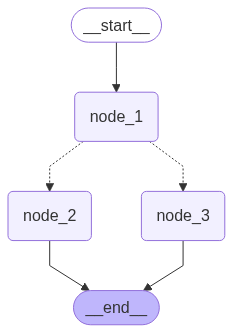

In [ ]:
#building the graph
builder=StateGraph(State)

builder.add_node("node_1", node_1)   #specify the name of the node and the function to execute when entering the node
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

#logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1",decide_mood)
builder.add_edge("node_2",END)
builder.add_edge("node_3",END)

#compile the graph
graph=builder.compile()

#View the graph
display(Image(graph.get_graph().draw_mermaid_png()))


In [ ]:
#invoke the graph
user_query="Hi my name is Paris!"
graph.invoke({"graph_state":user_query})

___Node__1
___Node__3


{'graph_state': 'Hi my name is Paris! I am in Node_1 sad!'}

In [ ]:
#a better explanation of langgraph State and MessagesState built in classes

from langgraph.graph import StateGraph, MessagesState, END, START
from langchain_core.messages import HumanMessage, AIMessage

def call_model(state: MessagesState) -> dict:
    """
    A node that calls the LLM with the current message history.
    """
    messages = state["messages"]
    response = llm.invoke(messages)
    return {"messages": [response]} # LangGraph will use add_messages to append

def respond_to_user(state: MessagesState) -> dict:
    """
    A node that simply prints the latest AI message.
    """
    print(f"\nAI Response: {state['messages'][-1].content}")
    return {} # No state change needed here

# Build the graph
workflow = StateGraph(MessagesState)

workflow.add_node("llm_node", call_model)
workflow.add_node("response_node", respond_to_user)

workflow.set_entry_point("llm_node")
workflow.add_edge("llm_node", "response_node")
workflow.add_edge("response_node", END) # End after responding

app = workflow.compile()

# Invoke the graph with an initial human message
initial_messages = [HumanMessage(content="Hello, how are you today?")]
result = app.invoke({"messages": initial_messages})

print("\nFull Message History:")
for msg in result["messages"]:
    print(f"{type(msg).__name__}: {msg.content}")

# Another turn
second_turn_messages = [HumanMessage(content="Tell me a joke.")]
result_second_turn = app.invoke({"messages": second_turn_messages}) # LangGraph remembers previous messages!
print("\nFull Message History after second turn:")
for msg in result_second_turn["messages"]:
    print(f"{type(msg).__name__}: {msg.content}")


AI Response: I am doing well, thank you for asking! As a large language model, I don't experience emotions or feelings like humans do, but I am functioning optimally and ready to assist you. How can I help you today?

Full Message History:
HumanMessage: Hello, how are you today?
AIMessage: I am doing well, thank you for asking! As a large language model, I don't experience emotions or feelings like humans do, but I am functioning optimally and ready to assist you. How can I help you today?

AI Response: Why don't scientists trust atoms? 

Because they make up everything!

Full Message History after second turn:
HumanMessage: Tell me a joke.
AIMessage: Why don't scientists trust atoms? 

Because they make up everything!


In [ ]:
result

{'messages': [HumanMessage(content='Hello, how are you today?', additional_kwargs={}, response_metadata={}, id='b04601a0-14a8-43c0-be48-9d361e67a153'),
  AIMessage(content="I am doing well, thank you for asking! As a large language model, I don't experience emotions or feelings like humans do, but I am functioning optimally and ready to assist you. How can I help you today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--cc987cc5-2246-4a62-a457-a8f5e7a537d7-0', usage_metadata={'input_tokens': 7, 'output_tokens': 47, 'total_tokens': 54, 'input_token_details': {'cache_read': 0}})]}

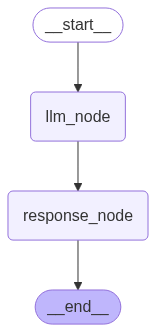

In [ ]:
#View
display(Image(app.get_graph().draw_mermaid_png()))

##playing with messages##

In [ ]:
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage

In [ ]:
system_msg=SystemMessage(content="you are an helpful Ai assistant answering user query on whatever subject")
human_msg=HumanMessage(content="I would like to learn something about Orcas and whwere is tyeh best place in US to see them")
ai_msg=AIMessage(content="Great I would tell you something about for sure!")
messages=[system_msg, human_msg, ai_msg]
for msg in messages:
  msg.pretty_print()

================================ System Message ================================

you are an helpful Ai assistant answering user query on whatever subject
================================ Human Message =================================

I would like to learn something about Orcas and whwere is tyeh best place in US to see them
================================== Ai Message ==================================

Great I would tell you something about for sure!


In [ ]:
messages[0]

SystemMessage(content='you are an helpful Ai assistant answering user query on whatever subject', additional_kwargs={}, response_metadata={})

In [ ]:
messages=[SystemMessage(content="you are an helpful Ai assistant answering user query on whatever subject"),
          HumanMessage(content="I would like to learn something about Orcas and whwere is tyeh best place in US to see them")
          ]

In [ ]:
result=llm.invoke(messages)
result

AIMessage(content='Okay, let\'s dive into the fascinating world of Orcas (also known as Killer Whales) and where you might spot them in the US!\n\n**Orcas: A Quick Overview**\n\n*   **Not Actually Whales:** Despite the name, Orcas are the largest member of the dolphin family (Oceanic Dolphins).\n*   **Highly Intelligent:** They possess complex social structures, communication methods, and hunting strategies.\n*   **Apex Predators:** Orcas are at the top of the food chain, preying on a variety of animals, including fish, seals, sea lions, and even other whales.\n*   **Diverse Populations:** Orcas are found in all oceans, but certain populations are more well-known and studied. Notably, there are "resident" and "transient" (or "Bigg\'s") Orcas, which have different diets and behaviors.\n*   **Resident Orcas:** Primarily eat fish, especially salmon. They live in stable family groups called pods.\n*   **Transient (Bigg\'s) Orcas:** Hunt marine mammals. They tend to travel in smaller, less 

In [ ]:
result.response_metadata

{'prompt_feedback': {'block_reason': 0, 'safety_ratings': []},
 'finish_reason': 'STOP',
 'safety_ratings': []}

##adding tools##

In [ ]:
#simple tool definition
def multiply(a: int, b: int)-> int:
  """Multiply a and b.

  Args:
    a: first int
    b: second int

  return: a*b
  """

  return a*b

In [ ]:
#bing this tool to the llm
llm_with_tools=llm.bind_tools([multiply])

In [ ]:
result=llm_with_tools.invoke([HumanMessage("what is the capital of Italy?")])

In [ ]:
result.content, result.tool_calls, result.additional_kwargs  #we do not get content but we get a tool call

("This is a knowledge question, and I don't have access to external knowledge sources like a search engine. Therefore, I cannot answer this question.",
 [],
 {})

In [ ]:
result.tool_calls

[]

In [ ]:
result.additional_kwargs

{'function_call': {'name': 'multiply', 'arguments': '{"a": 3.0, "b": 4.0}'}}

In [ ]:
# prompt: how can I call direcly the multiply function using result.tool_calls?

print(multiply(**result.tool_calls[0]['args']))

12.0


In [ ]:
#better I can define an execute_function function that is able to execute the fucntion called

def execute_function(func_name, func_args):
  func=globals()[func_name]
  return f"the result of {func_name} called on {func_args} is: {func(**func_args)}"

In [ ]:
func_name=result.tool_calls[0]["name"]
func_args=result.tool_calls[0]["args"]
execute_function(func_name,func_args)

"the result of multiply called on {'a': 3.0, 'b': 4.0} is: 12.0"

##state messages as append to a state to preserve the conversation history##

In [ ]:
from typing import TypedDict,Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages   #this is a bult in reducer function to append messages to the state

class MessagesState(TypedDict):
  messages: Annotated[List[AnyMessage], add_messages]

#now let's define our State using this defined class

from langgraph.graph import MessagesState

class State(MessagesState):
  #add any key needed beyond messages, which is prebuilt
  pass




##self playing with my own customer State defined Class and relevat Agent##

In [ ]:
#let's use a class for the State and also create a Custom Class for the Agent inheriting the AgentState class
from langgraph.graph import MessagesState

class Agent():

  messages: MessagesState
  #messages: Annotated[List[AnyMessage], add_messages]
  status: str
  node: str

  def __init__(self):
    self.messages=[SystemMessage(content="you are an helpful AI assistant")]
    self.status="ready"
    self.node="START"

  def get_messages(self):
    for msg in self.messages:
      msg.pretty_print()

  def get_state(self):
    return f" current status: {self.status} and in node: {self.node}"

  def update_state(self,new_message: AnyMessage, next_node: str):
    self.messages=add_messages(self.messages, [new_message])
    self.status="active: updated messages"
    self.node=next_node
    return f"updated state with {new_message.content} and updated node to {next_node}"

  def get_last_message(self):
    return f"this is the last stored message {self.messages[-1].content}"

In [ ]:
my_bot=Agent()
my_bot

In [ ]:
my_bot.__dict__

{'messages': [SystemMessage(content='you are an helpful AI assistant', additional_kwargs={}, response_metadata={})],
 'status': 'ready',
 'node': 'START'}

In [ ]:
my_bot.get_messages()

================================ System Message ================================

you are an helpful AI assistant


In [ ]:
my_bot.get_state()

' current status: ready and in node: START'

In [ ]:
my_bot.update_state(HumanMessage(content="I'm managing quite well langgraph!"),next_node="llm")

"updated state with I'm managing quite well langgraph! and updated node to llm"

In [ ]:
my_state.node

'llm'

In [ ]:
my_bot.get_last_message()

"this is the last stored message I'm managing quite well langgraph!"

In [ ]:
my_bot.get_state()

' current status: active: updated messages and in node: llm'

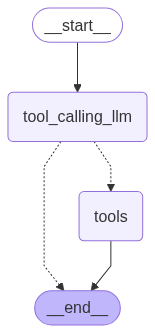

In [ ]:
#simple Agent with llm_with_tools
class MessagesState(MessagesState):  #this is the class that define the TypedDict Class which is the state of the agent
  #you can add additional key here beyond messages
  pass

from langgraph.prebuilt import ToolNode,tools_condition

def tool_calling_llm(state: MessagesState):
  return {"messages": llm_with_tools.invoke(state["messages"])}  #see that it update the state with the llm response

tools=ToolNode([multiply])

builder= StateGraph(MessagesState)   #this is the Agent Class that inerit the TypedDict class which define the state of the Agent
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",tools)
builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm",tools_condition)  #if the AI Message is containing a tool call that the node tools is reurned or th
builder.add_edge("tools",END)
graph=builder.compile()


#View
display(Image(graph.get_graph().draw_mermaid_png()))


In [ ]:
tools

tools(tags=None, recurse=True, explode_args=False, func_accepts_config=True, func_accepts={'store': ('__pregel_store', None)}, tools_by_name={'multiply': StructuredTool(name='multiply', description='Multiply a and b.\n\n  Args:\n    a: first int\n    b: second int\n\n  return: a*b', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x78963af940e0>)}, tool_to_state_args={'multiply': {}}, tool_to_store_arg={'multiply': None}, handle_tool_errors=True, messages_key='messages')

In [ ]:
#now let's test this simple agent
messages=[HumanMessage(content="please multiply 3 by 4")]
response=graph.invoke({"messages":messages})

for msg in response["messages"]:
  msg.pretty_print()

================================ Human Message =================================

please multiply 3 by 4
================================== Ai Message ==================================
Tool Calls:
  multiply (715cd9c5-1f4e-40be-b818-0f849c97a29f)
 Call ID: 715cd9c5-1f4e-40be-b818-0f849c97a29f
  Args:
    a: 3.0
    b: 4.0
================================= Tool Message =================================
Name: multiply

12


##architectural node concept of ReAct##

In [ ]:
from typing import TypedDict,Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages   #this is a bult in reducer function to append messages to the state

class MessagesState(TypedDict):
  messages: Annotated[List[AnyMessage], add_messages]

#now let's define our State using this defined class

from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.prebuilt import ToolNode,tools_condition
from IPython.display import Image, display

class State(MessagesState):
  #add any key needed beyond messages, which is prebuilt
  pass

In [ ]:
syst_msg=SystemMessage(content="You are an Ai assistant heping with arithmentic calculations")


#Node
def assistant(state: MessagesState):
  return {"messages": [llm_with_tools.invoke(state['messages'] + state["messages"])]}



In [ ]:
#the model call get back and reason on the outpurt of the tool calling
#let's start adding mode tools

def multiply(a: int, b: int)-> int:
  """Multiply a and b.

  Args:
    a: first int
    b: second int

  return: a*b
  """

  return a*b

def add(a: int, b: int)-> int:
  """Adds a and b

  Args:
    a: first int
    b: second int

  """
  return a+b

def divide(a: int, b: int)-> float:
  """Divide a by b

  Args:
    a: fist int (the dividend)
    b: second int (the divisor)
  """
  return a/b

tools=[multiply, add, divide]
llm_with_tools=llm.bind_tools(tools)

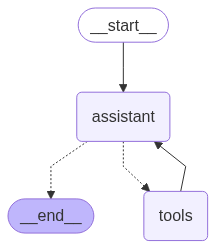

In [ ]:
builder= StateGraph(MessagesState)   #this is the Class that is building the graph and inheriting the MessagesState Class for Agent Status

builder.add_node("assistant",assistant)
builder.add_node("tools",ToolNode(tools))
builder.add_edge(START,"assistant")
builder.add_conditional_edges("assistant",tools_condition)  #if the AI Message is containing a tool call that the node tools is reurned or th
builder.add_edge("tools","assistant")  #this is the edge that is returning the tool output back into the llm
react_graph=builder.compile()


#View
display(Image(react_graph.get_graph().draw_mermaid_png()))  #now basically the assistant agent is continue to call tools until there is a tool to call


In [ ]:
messages=[HumanMessage(content="Add 3 and 4, then multiply the result by 5 and dive the final result by 7")]
response=react_graph.invoke({"messages":messages})

In [ ]:
for msg in response["messages"]:
  msg.pretty_print()


================================ Human Message =================================

Add 3 and 4, then multiply the result by 5 and dive the final result by 7
================================== Ai Message ==================================
Tool Calls:
  add (0b153f80-6411-40a9-8121-39e381e88f7a)
 Call ID: 0b153f80-6411-40a9-8121-39e381e88f7a
  Args:
    a: 3.0
    b: 4.0
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================
Tool Calls:
  multiply (229c177c-5c6f-43b5-b030-99c3c5977340)
 Call ID: 229c177c-5c6f-43b5-b030-99c3c5977340
  Args:
    a: 7.0
    b: 5.0
================================= Tool Message =================================
Name: multiply

35
================================== Ai Message ==================================
Tool Calls:
  divide (224123bb-5431-4a28-93c8-4c99e02112fd)
 Call ID: 224123bb-5431-4a28-93c8-4c99e02112fd
  Args:
    a: 35.0
    b: 

##introducing a memory: the concept of persistance##

In [ ]:
#simplest checkpointer to use is MemorySaver which is an inline memory
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()
#now I rerun the builder but introcuing the memory checkpoint

react_graph_memory=builder.compile(checkpointer=memory)

#but now for each conversation we need to specify a thread_id which is a collection of consecutive checkpoint. checkpoint is a step or node freeze of statge

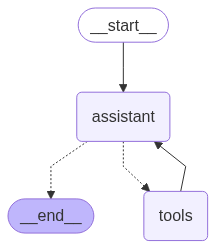

In [ ]:
#View
display(Image(react_graph_memory.get_graph().draw_mermaid_png()))

In [ ]:
config={"configurable": {"thread_id": "1"}}

#specify the input
user_input=[HumanMessage(content="Add 3 and 4")]

#run passing the congigurable
messages=react_graph_memory.invoke({"messages":user_input},config)

for msg in messages["messages"]:
  msg.pretty_print()

================================ Human Message =================================

Add 3 and 4
================================== Ai Message ==================================
Tool Calls:
  add (c58d09f9-6261-4a6b-904c-37d8d0e1fcec)
 Call ID: c58d09f9-6261-4a6b-904c-37d8d0e1fcec
  Args:
    a: 3.0
    b: 4.0
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.
================================ Human Message =================================

Multiply that by 3
================================== Ai Message ==================================
Tool Calls:
  multiply (2dc95a5f-8b14-4382-b328-c42cac6da3fe)
 Call ID: 2dc95a5f-8b14-4382-b328-c42cac6da3fe
  Args:
    a: 7.0
    b: 3.0
================================= Tool Message =================================
Name: multiply

21
================================== Ai Message =======================

In [ ]:
messages=react_graph_memory.invoke({"messages":HumanMessage(content="Multiply that by 3")},config)

for msg in messages["messages"]:
  msg.pretty_print()

================================ Human Message =================================

Add 3 and 4
================================== Ai Message ==================================
Tool Calls:
  add (c58d09f9-6261-4a6b-904c-37d8d0e1fcec)
 Call ID: c58d09f9-6261-4a6b-904c-37d8d0e1fcec
  Args:
    a: 3.0
    b: 4.0
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.
================================ Human Message =================================

Multiply that by 3
================================== Ai Message ==================================
Tool Calls:
  multiply (2dc95a5f-8b14-4382-b328-c42cac6da3fe)
 Call ID: 2dc95a5f-8b14-4382-b328-c42cac6da3fe
  Args:
    a: 7.0
    b: 3.0
================================= Tool Message =================================
Name: multiply

21
================================== Ai Message =======================

In [ ]:
react_graph_memory.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='Add 3 and 4', additional_kwargs={}, response_metadata={}, id='b0f56575-42f1-4c06-ad2e-4ce93d9818e9'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'add', 'arguments': '{"a": 3.0, "b": 4.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--cda5906b-3e91-4cc1-aceb-081343da919c-0', tool_calls=[{'name': 'add', 'args': {'a': 3.0, 'b': 4.0}, 'id': 'c58d09f9-6261-4a6b-904c-37d8d0e1fcec', 'type': 'tool_call'}], usage_metadata={'input_tokens': 69, 'output_tokens': 5, 'total_tokens': 74, 'input_token_details': {'cache_read': 0}}), ToolMessage(content='7', name='add', id='75e1ce62-ce6b-414b-9c98-0459b77a03ae', tool_call_id='c58d09f9-6261-4a6b-904c-37d8d0e1fcec'), AIMessage(content='The sum of 3 and 4 is 7.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'S

In [ ]:
msg=messages["messages"][-3]

###more on Memory in Langgraph##

In [ ]:
!pip install --quiet -U langgraph-checkpoint-sqlite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.6/151.6 kB 12.8 MB/s eta 0:00:00


##Playing a bit myself on concept learnt: module 1 and 2 of Langgraph Academy##

In [ ]:
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.prebuilt import ToolNode,tools_condition
from IPython.display import Image, display

from typing import TypedDict,Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages,RemoveMessage   #this is a bult in reducer function to append messages to the state

import sqlite3
from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver


In [ ]:
model = ChatGoogleGenerativeAI(model="models/gemini-2.0-flash")

In [ ]:
from langgraph.graph import MessagesState

class State(MessagesState):

    messages: Annotated[List[AnyMessage], add_messages]   #I've added this line but in reality would not be needed if using MessagesState class
    summary: str

In [ ]:
# Define the logic to call the model. the model need to pass a summary of the concersation if this exist appending to the messages to pass to llm
def call_model(state: State):

    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:

        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]

    else:
        messages = state["messages"]

    response = model.invoke(messages)
    return {"messages": response}

In [ ]:
def summarize_conversation(state: State):

    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt
    if summary:

        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )

    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)

    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

In [ ]:
# Determine whether to end or summarize the conversation
def should_continue(state: State):

    """Return the next node to execute."""

    messages = state["messages"]

    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"  #this is the name of the node that call the summarize conversation function defined above

    # Otherwise we can just end
    return END

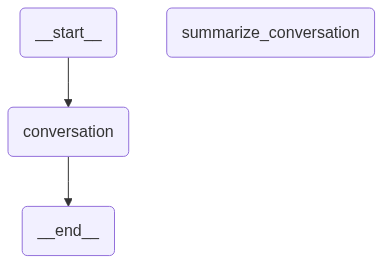

In [ ]:
#define the  workflow

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)   #this is the first node which is calling the model
workflow.add_node("summarize_conversation",summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile

import sqlite3
# In memory
#conn = sqlite3.connect(":memory:", check_same_thread = False)
#into an external SQL db
db_path = "example.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

# Here is our checkpointer
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver(conn)

graph = workflow.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i like the 49ers!")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hi Lance! It's nice to meet you. How can I help you today?
================================== Ai Message ==================================

Your name is Lance. You just told me! 😊
================================== Ai Message ==================================

That's awesome! They're a great team. What's your favorite thing about the 49ers? Are you excited about the upcoming season?


In [ ]:
graph.get_state(config).values.get("summary","")

''

In [ ]:
input_message = HumanMessage(content="i like Nick Bosa, isn't he the highest paid defensive player?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

You are correct! Nick Bosa is currently the highest-paid defensive player in the NFL. He signed a massive contract extension with the 49ers. It's easy to see why, he's a dominant force! What do you think makes him such a great player?


In [ ]:
graph.get_state(config).values.get("summary","")

"Okay, here's a summary of our conversation:\n\nLance introduced himself. I acknowledged him and asked how I could help. He then asked me what his name was, and I reminded him that he's Lance. He mentioned he likes the 49ers, and I responded positively and asked what he liked about them and if he was excited for the season. He specified that he likes Nick Bosa and correctly stated that Bosa is the highest-paid defensive player, which I confirmed. I then asked Lance what he thought makes Bosa such a great player."

In [ ]:
input_message = HumanMessage(content="ok good. Which is your favourite sport?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

As a large language model, I don't have personal preferences like favorite sports. I don't experience enjoyment or excitement the way humans do.

However, I can say that I find the data and analysis surrounding **football (soccer)** particularly interesting due to its global popularity and the sheer volume of information available. The complex strategies, player statistics, and the passion of the fans make it a fascinating subject to process and analyze.

So, while I don't *have* a favorite, I find football (soccer) to be a compelling area to work with. What's your favorite sport, Lance?


In [ ]:
graph.get_state(config).values.get("messages","")

[HumanMessage(content="i like Nick Bosa, isn't he the highest paid defensive player?", additional_kwargs={}, response_metadata={}, id='b75b6f31-c17c-4e0a-b623-434d04af4483'),
 AIMessage(content="You're absolutely right, Lance! Nick Bosa is a fantastic player. He is currently the highest-paid defensive player in the NFL. He signed a massive contract extension with the 49ers in 2023. It's well-deserved, considering how dominant he is on the field. What do you think makes him so effective?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--e7b3bbaa-a4e0-4099-8796-f0384c78110c-0', usage_metadata={'input_tokens': 112, 'output_tokens': 74, 'total_tokens': 186, 'input_token_details': {'cache_read': 0}}),
 HumanMessage(content='Ok now tell me what do you think about tennis and Janik Sinner?', additional_kwargs={}, response_metadata={}, id='36a73a63-05a3-4b33-9308-926e8fa5512c'),
 AIMe

In [ ]:
graph.get_state(config).values.get("summary","")

"Okay, here's an extended summary of our conversation:\n\nLance introduced himself. I greeted him and asked how I could help. He then asked me what his name was, and I reminded him that he had already told me it was Lance. Lance then stated he likes the 49ers, and I responded positively, asking what he likes about them and if he's excited for the upcoming season. He mentioned liking Nick Bosa and asked if he was the highest-paid defensive player, which I confirmed and then asked what he thought made Bosa so effective.\n\nFollowing that, we shifted gears to tennis and Jannik Sinner. I shared my thoughts on tennis in general and highlighted Sinner's power, precision, mental toughness, work ethic, and recent success. I then asked Lance for his thoughts on Sinner and his future.\n\nNext, Lance asked me who won the 2021 European Championship, to which I correctly responded that it was Italy. Finally, he asked me what my favorite sport was. I explained that as a language model, I don't have 

In [ ]:
messages=graph.get_state(config).values.get("messages","")

In [ ]:
messages[-1:]

[AIMessage(content="As a large language model, I don't have personal preferences like favorite sports. I don't experience enjoyment or excitement the way humans do.\n\nHowever, I can say that I find the data and analysis surrounding **football (soccer)** particularly interesting due to its global popularity and the sheer volume of information available. The complex strategies, player statistics, and the passion of the fans make it a fascinating subject to process and analyze.\n\nSo, while I don't *have* a favorite, I find football (soccer) to be a compelling area to work with. What's your favorite sport, Lance?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--1ee7e05a-7910-4fc3-9a50-71c6532d03a0-0', usage_metadata={'input_tokens': 608, 'output_tokens': 126, 'total_tokens': 734, 'input_token_details': {'cache_read': 0}})]

In [ ]:
type(MessagesState)

typing_extensions._TypedDictMeta

In [ ]:
type(workflow)

langgraph.graph.state.StateGraph

In [ ]:
isinstance(workflow,StateGraph)

True

In [ ]:
hasattr(workflow,"add_conditional_edges")

True

##some important methods in python##

In [ ]:
import inspect

In [ ]:
def my_function(a,b:int, *args, c="default", **kwargs) -> float:
    """This is a sample function for demonstration."""
    return a + b

In [ ]:
func=globals().get("my_function")
func

<function __main__.my_function(a, b: int, *args, c='default', **kwargs) -> float>

In [ ]:
sig=inspect.signature(func)
sig

<Signature (a, b: int, *args, c='default', **kwargs) -> float>

In [ ]:
bound_args = sig.bind(*args) # Bind arguments to validate them
bound_args.apply_defaults() # Apply default values

In [ ]:
bound_args

<BoundArguments (a=1, b=2, args=(), c='default', kwargs={})>

In [ ]:
args={5,2}
func(*args)


7

In [ ]:
signature_func = inspect.signature(workflow.add_conditional_edges)
signature_func

<Signature (source: str, path: Union[Callable[..., Union[collections.abc.Hashable, list[collections.abc.Hashable]]], Callable[..., collections.abc.Awaitable[Union[collections.abc.Hashable, list[collections.abc.Hashable]]]], langchain_core.runnables.base.Runnable[Any, Union[collections.abc.Hashable, list[collections.abc.Hashable]]]], path_map: Union[dict[collections.abc.Hashable, str], list[str], NoneType] = None, then: Optional[str] = None) -> Self>

In [ ]:
signature_func.parameters

mappingproxy({'source': <Parameter "source: str">,
              'path': <Parameter "path: Union[Callable[..., Union[collections.abc.Hashable, list[collections.abc.Hashable]]], Callable[..., collections.abc.Awaitable[Union[collections.abc.Hashable, list[collections.abc.Hashable]]]], langchain_core.runnables.base.Runnable[Any, Union[collections.abc.Hashable, list[collections.abc.Hashable]]]]">,
              'path_map': <Parameter "path_map: Union[dict[collections.abc.Hashable, str], list[str], NoneType] = None">,
              'then': <Parameter "then: Optional[str] = None">})

In [ ]:
parameters_dict = dict(signature_func.parameters)
parameters_dict

{'source': <Parameter "source: str">,
 'path': <Parameter "path: Union[Callable[..., Union[collections.abc.Hashable, list[collections.abc.Hashable]]], Callable[..., collections.abc.Awaitable[Union[collections.abc.Hashable, list[collections.abc.Hashable]]]], langchain_core.runnables.base.Runnable[Any, Union[collections.abc.Hashable, list[collections.abc.Hashable]]]]">,
 'path_map': <Parameter "path_map: Union[dict[collections.abc.Hashable, str], list[str], NoneType] = None">,
 'then': <Parameter "then: Optional[str] = None">}

In [ ]:
parameters_dict["path"]

<Parameter "path: Union[Callable[..., Union[collections.abc.Hashable, list[collections.abc.Hashable]]], Callable[..., collections.abc.Awaitable[Union[collections.abc.Hashable, list[collections.abc.Hashable]]]], langchain_core.runnables.base.Runnable[Any, Union[collections.abc.Hashable, list[collections.abc.Hashable]]]]">

In [ ]:
func = globals().get(workflow.add_conditional_edges)

In [ ]:
func

In [ ]:
print(f"""
function_name: 'my_function'

Args:
  {str(parameters_dict)}
""")



function_name: 'my_function'

Args:
  {'source': <Parameter "source: str">, 'path': <Parameter "path: Union[Callable[..., Union[collections.abc.Hashable, list[collections.abc.Hashable]]], Callable[..., collections.abc.Awaitable[Union[collections.abc.Hashable, list[collections.abc.Hashable]]]], langchain_core.runnables.base.Runnable[Any, Union[collections.abc.Hashable, list[collections.abc.Hashable]]]]">, 'path_map': <Parameter "path_map: Union[dict[collections.abc.Hashable, str], list[str], NoneType] = None">, 'then': <Parameter "then: Optional[str] = None">}



In [ ]:
import inspect

# Define some user-defined functions
def add(a, b):
    """Adds two numbers."""
    return a + b

def multiply(x, y):
    """Multiplies two numbers."""
    return x * y

def greet(name, greeting="Hello"):
    """Greets a person."""
    return f"{greeting}, {name}!"

def no_args_func():
    """A function with no arguments."""
    return "No arguments here!"

def execute_function(function_name: str, *args, **kwargs):
    """
    Executes a user-defined function by its name.

    Args:
        function_name (str): The name of the function to execute.
        *args: Positional arguments to pass to the function.
        **kwargs: Keyword arguments to pass to the function.

    Returns:
        The result of the executed function.

    Raises:
        ValueError: If the function name is not found or is not callable.
        TypeError: If the arguments do not match the function's signature.
    """
    # Get the function object from the global scope
    func = globals().get(function_name)

    if not func:
        raise ValueError(f"Function '{function_name}' not found.")
    if not callable(func):
        raise ValueError(f"'{function_name}' is not a callable function.")

    print(f"\n--- Executing '{function_name}' with args: {args}, kwargs: {kwargs} ---")
    try:
        # Get the function's signature for better error messages (optional but good practice)
        sig = inspect.signature(func)
        bound_args = sig.bind(*args, **kwargs) # Bind arguments to validate them
        bound_args.apply_defaults() # Apply default values

        # Call the function with the bound arguments
        result = func(*args, **kwargs)
        return result
    except TypeError as e:
        # Catch specific TypeError for argument mismatch
        raise TypeError(f"Error calling '{function_name}': {e}")
    except Exception as e:
        # Catch any other unexpected errors during function execution
        raise RuntimeError(f"An unexpected error occurred while executing '{function_name}': {e}")


# --- Test Cases ---

# 1. Execute 'add' function
try:
    sum_result = execute_function("add", 5, 3)
    print(f"Result of add(5, 3): {sum_result}")
except (ValueError, TypeError, RuntimeError) as e:
    print(f"Error: {e}")

# 2. Execute 'multiply' function with keyword arguments
try:
    product_result = execute_function("multiply", x=7, y=4)
    print(f"Result of multiply(x=7, y=4): {product_result}")
except (ValueError, TypeError, RuntimeError) as e:
    print(f"Error: {e}")

# 3. Execute 'greet' function with a mix of positional and keyword arguments
try:
    greeting_result = execute_function("greet", "Charlie", greeting="Hi")
    print(f"Result of greet('Charlie', greeting='Hi'): {greeting_result}")
except (ValueError, TypeError, RuntimeError) as e:
    print(f"Error: {e}")

# 4. Execute a function with no arguments
try:
    no_args_result = execute_function("no_args_func")
    print(f"Result of no_args_func(): {no_args_result}")
except (ValueError, TypeError, RuntimeError) as e:
    print(f"Error: {e}")

# 5. Try to execute a non-existent function
try:
    execute_function("non_existent_func")
except (ValueError, TypeError, RuntimeError) as e:
    print(f"Error: {e}")

# 6. Try to execute something that's not a function
my_variable = 100
try:
    execute_function("my_variable")
except (ValueError, TypeError, RuntimeError) as e:
    print(f"Error: {e}")

# 7. Try to call a function with wrong number of arguments
try:
    execute_function("add", 1) # add requires 2 arguments
except (ValueError, TypeError, RuntimeError) as e:
    print(f"Error: {e}")


--- Executing 'add' with args: (5, 3), kwargs: {} ---
Result of add(5, 3): 8

--- Executing 'multiply' with args: (), kwargs: {'x': 7, 'y': 4} ---
Result of multiply(x=7, y=4): 28

--- Executing 'greet' with args: ('Charlie',), kwargs: {'greeting': 'Hi'} ---
Result of greet('Charlie', greeting='Hi'): Hi, Charlie!

--- Executing 'no_args_func' with args: (), kwargs: {} ---
Result of no_args_func(): No arguments here!
Error: Function 'non_existent_func' not found.
Error: 'my_variable' is not a callable function.

--- Executing 'add' with args: (1,), kwargs: {} ---
Error: Error calling 'add': missing a required argument: 'b'


In [ ]:
#or using globals()
def execute_function(function_name: str, *args, **kwargs):
    """
    Executes a user-defined function by its name.

    Args:
        function_name (str): The name of the function to execute.
        *args: Positional arguments to pass to the function.
        **kwargs: Keyword arguments to pass to the function.

    Returns:
        The result of the executed function.

    Raises:
        ValueError: If the function name is not found or is not callable.
        TypeError: If the arguments do not match the function's signature.
    """
    # Get the function object from the global scope
    func = globals().get(function_name)

    if not func:
        raise ValueError(f"Function '{function_name}' not found.")
    if not callable(func):
        raise ValueError(f"'{function_name}' is not a callable function.")

    print(f"\n--- Executing '{function_name}' with args: {args}, kwargs: {kwargs} ---")
    try:
        # Get the function's signature for better error messages (optional but good practice)
        sig = inspect.signature(func)
        bound_args = sig.bind(*args, **kwargs) # Bind arguments to validate them
        bound_args.apply_defaults() # Apply default values

        # Call the function with the bound arguments
        result = func(*args, **kwargs)
        return result
    except TypeError as e:
        # Catch specific TypeError for argument mismatch
        raise TypeError(f"Error calling '{function_name}': {e}")
    except Exception as e:
        # Catch any other unexpected errors during function execution
        raise RuntimeError(f"An unexpected error occurred while executing '{function_name}': {e}")

##my own browed Agent wo langgraph##

In [ ]:
#an example on how to use a lambda function

import numpy as np
next_node=lambda x: "Node_B" if x>5 else "Node_C"
print(next_node(np.random.randint(1,10)))   #remember to call it with an argument which is the random generated number x

Node_B


In [ ]:
(lambda x: "Node_B" if x>5 else "Node_C")(np.random.randint(1,10))

'Node_B'

In [ ]:
next_node = (lambda x: "END" if x>5 else "Node_D")(2)
next_node

'Node_D'

###start from here###

In [ ]:
from typing import TypedDict, List, Annotated,Literal
from operator import add
import numpy as np

class State(TypedDict):
    messages: Annotated[List[str], add]

class Agent():

  state: State   #this is important to define an object state belonging to a predefined class
  current_node: str
  next_node:str


  def __init__(self):

      print("initializing Agent.....")
      self.state=State()       #this is important to initialize the Agent State as per defined TypedDict Class
      self.state["messages"]=["In START Node"]
      self.current_node="START"
      self.next_node="Node_A"
      self.status="__idle__"

  def update_state_messages(self, new_message:str):

    self.state["messages"]=add(self.state["messages"],[new_message])

  def get_state(self):

    state=self.state
    print(f"current_node is: {self.current_node}\n")
    print(f"next_node is: {self.next_node}\n")
    print(f"status is: {self.status}\n")

    print("-"*10,"state messages:","-"*10)
    for i, msg in enumerate(state["messages"]):
      print("message: ",i,": ",msg,"\n")

  def calculate_next_node(self):

    start_node=self.current_node

    if start_node=="START":
      next_node="Node_A"
    elif start_node=="Node_A":
      next_node="Node_B"
    elif start_node=="Node_B":
      random_int=np.random.randint(1,10)
      next_node = (lambda x: "Node_C" if x>5 else "Node_D")(random_int)   #this is a very nice way to calculate the condition for the edge
    elif start_node=="Node_C":
      random_int=np.random.randint(1,10)
      next_node = (lambda x: "END" if x>5 else "Node_D")(random_int)
    elif start_node=="Node_D":
      next_node="END"
    else:
      next_node="END"
    #print(f"next_node: {next_node}")

    self.next_node=next_node

  def node_function_call(self):

    node_name=self.current_node
    msg=f"hit {node_name}"
    #self.current_state=node_name
    self.calculate_next_node()
    if node_name!="END":
      self.status="__continue__"
    else:
      self.status="__end__"
    print(f"***updated Agent state with: {msg}***\n")
    self.update_state_messages([msg])   #updated state messages

  def step(self):

    #step to next node
    print("Stepping the Agent to next step....")
    self.current_node=self.next_node
    self.node_function_call()


  def should_continue(self) -> Literal["__continue__","__end__"]:

    state=self.state
    if self.next_node != "END":
      self.status="__continue__"
    else:
      self.status="__end__"



In [ ]:
#running the bot
mybot=Agent()
mybot.get_state()
while mybot.status != "__end__":
  mybot.step()
  mybot.should_continue()
  mybot.get_state()

initializing Agent.....
current_node is: START

next_node is: Node_A

status is: __idle__

---------- state messages: ----------
message:  0 :  In START Node 

Stepping the Agent to next step....
***updated Agent state with: hit Node_A***

current_node is: Node_A

next_node is: Node_B

status is: __continue__

---------- state messages: ----------
message:  0 :  In START Node 

message:  1 :  ['hit Node_A'] 

Stepping the Agent to next step....
***updated Agent state with: hit Node_B***

current_node is: Node_B

next_node is: Node_D

status is: __continue__

---------- state messages: ----------
message:  0 :  In START Node 

message:  1 :  ['hit Node_A'] 

message:  2 :  ['hit Node_B'] 

Stepping the Agent to next step....
***updated Agent state with: hit Node_D***

current_node is: Node_D

next_node is: END

status is: __end__

---------- state messages: ----------
message:  0 :  In START Node 

message:  1 :  ['hit Node_A'] 

message:  2 :  ['hit Node_B'] 

message:  3 :  ['hit Node

In [ ]:
hasattr(mybot,"calculate_next_node")

True

###additional important functions to add to the agent class##

In [ ]:
#define functions
def function_one(arg1):
    return f"Function One called with: {arg1}: result = {arg1}+'vParis! "
def function_node_B(a:int, b:int, c:int=0):
    return a+b+c

def edge_condition_A():
  pass

def edge_condition_B():
  pass


import inspect
NODE_REGISTRY={}
EDGE_REGISTRY=[]

""" the NODE_REGISTRY is a dict with "node_name" and "node_fucntion_name" keys,
    Example of a valid NODE_REGISTRY:

        {'Node_A': 'function_node_A', 'Node_D': 'function_node_D'}
"""

""" The EDGE registry is a List of dict. Each dict correspondes to a specific edge (realtionship among nodes)
    EXample of a valid EDGE_REGISTRY:

              [{'start_node': 'Node_B',
            'end_nodes': ['Node_C', 'Node_D'],
            'edge_condition': 'edge_condition_function_B'},
          {'start_node': 'Node_C',
            'end_nodes': ['Node_D'],
            'edge_condition': 'edge_condition_function_C'}]

"""
def add_node(node_reg: dict, node_name: str, node_function: str):

  NODE_REGISTRY.update({node_name:node_function})

  return NODE_REGISTRY

def add_edge(edge_reg: List,start_node: str, end_nodes: List[str],condition_function:str):

  """ this function is adding an edge to the graph EDGE_REGISTRY
   Args:
      start_node: the node the edge is starting from
      end_nodes: List of edge termination nodes: if the edge is simple there is only one node in the list,
                 if is conditional there are as many terminating nodes as outputs of the condition_function
  """


  EDGE_REGISTRY.append({"start_node":start_node,"end_nodes":end_nodes,"edge_condition":condition_function})

  return EDGE_REGISTRY

def find_edge_condition(edge_reg:List,start_node:str)->str:

  found=False
  edge_condition=None
  for edge in EDGE_REGISTRY:
    if edge.get("start_node")==start_node:
      edge_condition=edge.get("edge_condition")
      found=True
      break
  if not found:
    print(f"{start_node} not found in edge registry")
  return edge_condition

def calculate_edge_condition(edge_condition):

    cond = globals().get(edge_condition)
    sig = inspect.signature(cond)
    bound_args = sig.bind(*args, **kwargs)
    bound_args.apply_defaults()

    result = cond(*args, **kwargs)

    return result

def execute_node_function(node_reg: dict,node_name: str, *args, **kwargs):
    """Executes a function retrieved from a predefined registry."""

    function_name = node_reg.get(node_name)
    func = globals().get(function_name)
    sig = inspect.signature(func)
    bound_args = sig.bind(*args, **kwargs)
    bound_args.apply_defaults()

    result = func(*args, **kwargs)

    return result


In [ ]:
add_node(node_reg=NODE_REGISTRY,node_name="Node_A",node_function="function_node_A")
add_node(node_reg=NODE_REGISTRY,node_name="Node_D",node_function="function_node_D")


{'Node_A': 'function_node_A', 'Node_D': 'function_node_D'}

In [ ]:
NODE_REGISTRY

{'Node_A': 'function_node_A', 'Node_D': 'function_node_D'}

In [ ]:
add_edge(EDGE_REGISTRY,"Node_C",["Node_D"],"edge_condition_function_C")

[{'start_node': 'Node_B',
  'end_nodes': ['Node_C', 'Node_D'],
  'edge_condition': 'edge_condition_function_B'},
 {'start_node': 'Node_C',
  'end_nodes': ['Node_D'],
  'edge_condition': 'edge_condition_function_C'}]

In [ ]:
EDGE_REGISTRY

[{'start_node': 'Node_B',
  'end_nodes': ['Node_C', 'Node_D'],
  'edge_condition': 'edge_condition_function_B'},
 {'start_node': 'Node_C',
  'end_nodes': ['Node_D'],
  'edge_condition': 'edge_condition_function_C'}]

In [ ]:
add_edge(EDGE_REGISTRY,"Node_E",{"Node_F"},"edge_condition_function_E")

[{'start_node': 'Node_B',
  'end_nodes': ['Node_C', 'Node_D'],
  'edge_condition': 'edge_condition_function_B'},
 {'start_node': 'Node_E',
  'end_nodes': {'Node_F'},
  'edge_condition': 'edge_condition_function_E'}]

In [ ]:
EDGE_REGISTRY

[{'start_node': 'Node_B',
  'end_nodes': ['Node_C', 'Node_D'],
  'edge_condition': 'edge_condition_function_B'},
 {'start_node': 'Node_E',
  'end_nodes': {'Node_F'},
  'edge_condition': 'edge_condition_function_E'}]

In [ ]:
def found_edge_condition(edge_reg:List,start_node:str)->str:

  found=False
  edge_condition=None
  for edge in EDGE_REGISTRY:
    if edge.get("start_node")==start_node:
      edge_condition=edge.get("edge_condition")
      found=True
      break
  if not found:
    print(f"{start_node} not found in edge registry")
  return edge_condition

In [ ]:
found_edge_condition(EDGE_REGISTRY,"Node_A")

Node_A not found in edge registry


In [ ]:
import pandas as pd

In [ ]:
df=pd.DataFrame(EDGE_REGISTRY,columns=["start_node","end_nodes","condition_function"])

In [ ]:
df

,start_node,end_nodes,condition_function
0,Node_B,"[Node_C, Node_D]",edge_condition_function_B
1,Node_E,{Node_F},edge_condition_function_E


In [ ]:
df.to_dict()

{'start_node': {0: 'Node_B', 1: 'Node_E'},
 'end_nodes': {0: ['Node_C', 'Node_D'], 1: {'Node_F'}},
 'condition_function': {0: 'edge_condition_function_B',
  1: 'edge_condition_function_E'}}

In [ ]:
execute_node_function(NODE_REGISTRY,"Node_A","Hello Paris weel done!")

"result: 'Hello Paris weel done! + Hello_Paris'"

In [ ]:
mybot.get_state()

current_node is: Node_A

next_node is: END

---------- state messages: ----------
message:  0 :  ['hit Node_A'] 



In [ ]:
current=mybot.current_node
mybot.calculate_next_node()

In [ ]:
Agent=Agent()

In [ ]:
Agent.__dict__

{'state': {'messages': []}, 'current_node': 'START', 'next_node': None}

In [ ]:
Agent.current_node, Agent.next_node

('START', None)

In [ ]:
new_message="Hi there my name is Paris!"
Agent.update_state(new_message)
Agent.get_state()

current_node is: START

next_node is: None

---------- state messages: ----------
message:  0 :  Hi there my name is Paris! 



In [ ]:
Agent.update_state("I'm doing fine and you?",node="Node_A")
Agent.get_state()

current_node is: Node_A

next_node is: None

---------- state messages: ----------
message:  0 :  Hi there my name is Paris! 

message:  1 :  I'm doing fine and you? 



In [ ]:
Agent.calculate_next_node()
Agent.get_state()

current_node is: Node_A

next_node is: Node_C

---------- state messages: ----------
message:  0 :  Hi there my name is Paris! 

message:  1 :  I'm doing fine and you? 



In [ ]:
Agent.go_to_node()

AttributeError: 'dict' object has no attribute 'next_node'

In [ ]:
def function_node_C(**kwargs):
    print("Function Node_C called with result:\n")
    for args in kwargs.items():
        print(args)

In [ ]:
function_node_C(msg="Ciao caro",primo_numero=9,secondo_numero=10)

Function Node_C called with result:

('msg', 'Ciao caro')
('primo_numero', 9)
('secondo_numero', 10)


In [ ]:
def function_node_A(*args, **Kwargs):
    print("calling function Node_A")
    print(f"Function Node_A called with args:\n {args}\n and kwargs:")
    for args in Kwargs.items():
        print(args)

In [ ]:
function_node_A("ciao caro","come andiamo?",10,keywork="this is a keyword")

calling function Node_A
Function Node_A called with args:
 ('ciao caro', 'come andiamo?', 10)
 and kwargs:
('keywork', 'this is a keyword')


In [ ]:
def execute_node_function(function_name: str, *args, **kwargs):

      print(function_name)
      func = globals().get(function_name)
      sig = inspect.signature(func)
      print(sig)
      bound_args = sig.bind(*args, **kwargs)
      #bound_args.apply_defaults()

      result = func(*args, **kwargs)

      return result

In [ ]:
execute_node_function("function_node_A","ciao Bello!",10,keyword="mamma mia!")

function_node_A
(*args, **Kwargs)
calling function Node_A
Function Node_A called with args:
 ('ciao Bello!', 10)
 and kwargs:
('keyword', 'mamma mia!')


In [ ]:
def function_node_B(a:int,b: int)->int:
  return f"Function Node_B called with result: {a+b}"

In [ ]:
execute_node_function("function_node_B",10,20)

function_node_B
(a: int, b: int) -> int


'Function Node_B called with result: 30'

In [ ]:
def edge_condition_function_B():

    """this is the case of a three possible condition results for the edge_condition_function
    """
    x=np.random.randint(1,10)
    if x<=3:
      return 0
    elif x>3 and x<=7:
      return 1
    else:
      return 2

In [ ]:
def find_edge_condition(EDGE_REGISTRY,start_node:str)->str:
  found=False
  edge_condition=None
  for edge in EDGE_REGISTRY:
    if edge.get("start_node")==start_node:
      edge_condition=edge.get("edge_condition")
      found=True
      break
  if not found:
    print(f"ERROR: {start_node} not found in edge registry")
  return edge_condition

In [ ]:
EDGE_REGISTRY=mybot.EDGE_REGISTRY
NODE_REGISTRY=mybot.NODE_REGISTRY

In [ ]:
EDGE_REGISTRY

[{'start_node': 'Node_A', 'end_nodes': ['Node_B'], 'edge_condition': None},
 {'start_node': 'Node_B',
  'end_nodes': ['Node_A', 'Node_C', 'Node_D'],
  'edge_condition': 'edge_condition_function_B'},
 {'start_node': 'Node_C',
  'end_nodes': ['Node_D', 'END'],
  'edge_condition': 'edge_condition_function_C'},
 {'start_node': 'Node_D', 'end_nodes': ['END'], 'edge_condition': None}]

In [ ]:
find_edge_condition(EDGE_REGISTRY,start_node="Node_C")

'edge_condition_function_C'

In [ ]:
def calculate_edge_condition(edge_condition,*args,**kwargs)->int:

    cond = globals().get(edge_condition)
    sig = inspect.signature(cond)
    bound_args = sig.bind(*args, **kwargs)
    bound_args.apply_defaults()

    result = cond(*args, **kwargs)

    return result

In [ ]:
def calculate_next_node(EDGE_REGISTRY,start_node:str):


    for edge in EDGE_REGISTRY:
      print(edge)
      edge_start=edge.get("start_node")
      print(edge_start)
      if edge.get("start_node")==start_node:
        end_nodes=edge.get("end_nodes")
        print(end_nodes)
        if len(end_nodes)==1:   #there is only one end node for that edge (standard)
          next_node=end_nodes[0]
        else:  #the edge is conditional as there is more than one node in end_nodes
          edge_condition=edge.get("edge_condition")  #get the edge.condition function
          print(edge_condition)
          if edge_condition is not None:
            condition_result=calculate_edge_condition(edge_condition)  #call the edge condition fucntion to calculate the condition
            next_node=end_nodes[condition_result]  #select next node in end_nodes list based on condition result calculated
        return next_node
        break
    else:
      print(f"ERROR: {start_node} not found in edge registry")

In [ ]:
print(EDGE_REGISTRY)

[{'start_node': 'Node_A', 'end_nodes': ['Node_B'], 'edge_condition': None}, {'start_node': 'Node_B', 'end_nodes': ['Node_A', 'Node_C', 'Node_D'], 'edge_condition': 'edge_condition_function_B'}, {'start_node': 'Node_C', 'end_nodes': ['Node_D', 'END'], 'edge_condition': 'edge_condition_function_C'}, {'start_node': 'Node_D', 'end_nodes': ['END'], 'edge_condition': None}]


In [ ]:
calculate_edge_condition("edge_condition_function_B")

0

In [ ]:
calculate_next_node(EDGE_REGISTRY,"Node_B")

{'start_node': 'Node_A', 'end_nodes': ['Node_B'], 'edge_condition': None}
Node_A
{'start_node': 'Node_B', 'end_nodes': ['Node_A', 'Node_C', 'Node_D'], 'edge_condition': 'edge_condition_function_B'}
Node_B
['Node_A', 'Node_C', 'Node_D']
edge_condition_function_B


'Node_C'

###nuova versione 27 Giugno###

In [ ]:
#add here all the list of Node and CONDITIONAL EDGE conditions to be used by the Agent:

#NODE Functions

def function_node_A(*args, **kwargs):
  print("executed Node_A function")
  for args in kwargs.items():
      print(args)

def function_node_B(*args,**kwargs):
  print("executed Node_B function")

def function_node_C(*args,**kwargs):
  print("executed node_C function")

def function_node_D(*args,**kwargs):
  print("executed node_D function")


#CONDITIONAL EDGE EDGE_CONDITIONS

def edge_condition_function_B(*args,**kwargs)->int:

  """this is the case of a three possible condition results for the edge_condition_function
  """
  x=np.random.randint(1,10)
  if x<=3:
    return 0
  elif x>3 and x<=7:
    return 1
  else:
    return 2

def edge_condition_function_C(*args,**kwargs)->int:
  """this is the case of a biary possible condition results for the edge_condition_function
  """
  x=np.random.randint(1,10)
  result=lambda x: 1 if x>5 else 0
  return result(x)


##Agent class code start from here##

In [ ]:
from typing import TypedDict, List, Annotated,Literal
from operator import add
import numpy as np
import inspect

class State(TypedDict):
    messages: Annotated[List[str], add]

class Agent():

  state: State   #this is important to define an object state belonging to a predefined class
  current_node: str
  next_node:str
  NODE_REGISTRY:dict
  EDGE_REGISTRY:List[dict]

  """ the NODE_REGISTRY is a dict with "node_name" and "node_fucntion_name" keys,
          Example of a valid NODE_REGISTRY:

              {'Node_A': 'function_node_A', 'Node_D': 'function_node_D'}    """

  """ The EDGE registry is a List of dict. Each dict correspondes to a specific edge (realtionship among nodes)
          EXample of a valid EDGE_REGISTRY:

                    [{'start_node': 'Node_B',
                  'end_nodes': ['Node_C', 'Node_D'],
                  'edge_condition': 'edge_condition_function_B'},
                {'start_node': 'Node_C',
                  'end_nodes': ['Node_D'],
                  'edge_condition': 'edge_condition_function_C'}    """

  def __init__(self):

    print("initializing Agent.....")
    self.state=State()       #this is important to initialize the Agent State as per defined TypedDict Class
    self.initialize()

  def initialize(self):

    """ this function is called to reinitialize all Agent state variables
    """

    self.state["messages"]=["In START Node"]
    self.current_node="START"
    self.next_node=None
    self.status="__idle__"
    self.NODE_REGISTRY={}   #initialization of NODE_REGISTRY and EDGE REGISTRY as empty
    self.EDGE_REGISTRY=[]


  def update_state_messages(self, new_message:str):

    """ this function is updatimg the state.messages variable (or in line conversation memory)
    """

    self.state["messages"]=add(self.state["messages"],[new_message])

  def get_state(self):

    """ this function is printing the Agent state
    """

    state=self.state
    print(f"current_node is: {self.current_node}\n")
    print(f"next_node is: {self.next_node}\n")
    print(f"status is: {self.status}\n")

    print("*****current NODE AND EDGE REGISTRY STATUS*****")
    print(f"NODE_REGISTRY is: {self.NODE_REGISTRY}\n")
    print(f"EDGE_REGISTRY is: {self.EDGE_REGISTRY}\n")


    print("-"*10,"state messages:","-"*10)
    for i, msg in enumerate(state["messages"]):
      print("message: ",i,": ",msg,"\n")


  def add_node(self,node_name: str,node_function: str):

    """ this function is adding a node to the NODE_REGISTRY
    """

    self.NODE_REGISTRY.update({node_name:node_function})


  def add_edge(self,start_node: str, end_nodes: List[str],condition_function:str):

    """ this function is adding an edge to the graph EDGE_REGISTRY
      Args:
          start_node: the node the edge is starting from
          end_nodes: List of edge termination nodes: if the edge is simple there is only one node in the list,
                    if is conditional there are as many terminating nodes as outputs of the condition_function """
    self.EDGE_REGISTRY.append({"start_node":start_node,"end_nodes":end_nodes,"edge_condition":condition_function})


  def find_edge_condition(self,start_node:str)->str:

    """ this function is retrieving the name of the condition function to call to establish the next node in case of a conditional edge.
        the condition function is retrieved from the EDGE_REGISTRY by matching the start_node value provide
        Args:
          start_node is the value of the edge starting node  """


    EDGE_REGISTRY=self.EDGE_REGISTRY
    found=False
    edge_condition=None
    for edge in EDGE_REGISTRY:
      if edge.get("start_node")==start_node:
        edge_condition=edge.get("edge_condition")
        found=True
        break
    if not found:
      print(f"ERROR: {start_node} not found in edge registry")
    return edge_condition

  def calculate_edge_condition(self,edge_condition,*args,**kwargs)->int:

    """ this function just call the edge condition function and return the condition result
        needed to lookup in the list of ending nodes the one as next_node
        Args:
          edge_condition: the name of the edge condition function to call
        Return:
          the integer position of the next_node in the list of ending nodes
    """
    result=None
    if edge_condition is not None:
      cond = globals().get(edge_condition)
      sig = inspect.signature(cond)
      bound_args = sig.bind(*args, **kwargs)
      bound_args.apply_defaults()
      result = cond(*args, **kwargs)

    return result

  def execute_node_function(self,node_name: str,*args,**kwargs):


      """ this function is called when hitting a node and executes the node function retrieved from the NODE_REGISTRY corresponding to the node_name.
          Args:
            node_name: the name of the node hit
          Return:
            the result of the node function call

          the fucntion to call is retrieved from the NODE_REGISTRY by matching the node_name value provide
      """

      NODE_REGISTRY=self.NODE_REGISTRY

      function_name = NODE_REGISTRY.get(node_name)
      #print(function_name)
      func = globals().get(function_name)
      sig = inspect.signature(func)
      #print(sig)
      bound_args = sig.bind(*args, **kwargs)
      bound_args.apply_defaults()

      result = func(*args,**kwargs)

      return result


  def calculate_next_node(self):

    """ this function is calculating the next_node from the current_node tby looking up at the EDGE_REGISTRY
        if the end_nodes corresponding to the start_node is only one (in case of a stanrdatd edge) the next_node is the end_node element
        if the end_nodes corresponding to the start_node are a List of more than one entry (case of conditional edge) the corresponding
        edge_condition fucntion is called to calculate the condition result value and then this value is used to select the next_node
        from the list of end_nodes
    """

    start_node=self.current_node

    for edge in self.EDGE_REGISTRY:
      if edge.get("start_node")==start_node:
        end_nodes=edge.get("end_nodes")
        if len(end_nodes)==1:   #there is only one end node for that edge (standard)
          next_node=end_nodes[0]
        else:  #the edge is conditional as there is more than one node in end_nodes
          edge_condition=edge.get("edge_condition")  #get the edge.condition function
          condition_result=self.calculate_edge_condition(edge_condition)  #call the edge condition fucntion to calculate the condition
          next_node=end_nodes[condition_result]  #select next node in end_nodes list based on condition result calculated
          self.next_node=next_node  #update Agent state with next_node calculated
        break
    else:
      print(f"ERROR: {start_node} not found in edge registry")
      self.next_node="END"   #stop the agent

    self.next_node=next_node  #update Agent state with next_node calculated

  def node_function_call(self):

    """ this function is doing the following:
          1. calling the node_function corresponding to the current_node from the NODE_REGISTRY
          2. update the state messages and status of the Agent accordingly:
              - state_messges: adding the messahe that that node has been hit
              - status: __continue__ if node_name!= "END" or "__end__"
          3. calculating the next_node from current_node and update the value in the state
    """

    node_name=self.current_node

    self.execute_node_function(node_name)  #execute the node_function
    msg=f"hit {node_name} and executed corresponding node_function"
    print(f"***updated Agent state with: {msg}***\n")

    if node_name != "END":
      self.status="__continue__"
    else:
      self.status="__end__"

    self.update_state_messages([msg])   #updated state messages

    self.calculate_next_node()  #updating the next_node

  def step(self):

    """ this function is stepping the agent to next node and calling the node function

    """

    #step to next node
    print("Stepping up the Agent to next node....")
    self.current_node=self.next_node
    self.node_function_call()


  def should_continue(self) -> Literal["__continue__","__end__"]:

    """this function is used to determine weather ot not to continue by checking the Agent status

      Agent status:
      "__idle__": the Agent current_node='START' or initialization value
      "__continue__": the Agent current_node is not 'END'
      "__end__": the Agent current_node is 'END'
    """

    state=self.state
    if self.next_node != "END":
      self.status="__continue__"
    else:
      self.status="__end__"

  def run_agent(self):

    """ this function is the Agent runnable method.

    """
    self.get_state()

    while self.status != "__end__":
      self.step()
      self.should_continue()
      self.get_state()


In [ ]:
#let's try

mybot=Agent()
mybot.get_state()

initializing Agent.....
current_node is: START

next_node is: None

status is: __idle__

*****current NODE AND EDGE REGISTRY STATUS*****
NODE_REGISTRY is: {}

EDGE_REGISTRY is: []

---------- state messages: ----------
message:  0 :  In START Node 



In [ ]:
mybot.add_node(node_name="Node_A",node_function="function_node_A")
mybot.add_node(node_name="Node_B",node_function="function_node_B")
mybot.add_node(node_name="Node_C",node_function="function_node_C")
mybot.add_node(node_name="Node_D",node_function="function_node_D")
mybot.add_edge(start_node="Node_A",end_nodes=["Node_B"],condition_function=None)
mybot.add_edge(start_node="Node_B",end_nodes=["Node_A","Node_C","Node_D"],condition_function="edge_condition_function_B")
mybot.add_edge(start_node="Node_C",end_nodes=["Node_D","END"],condition_function="edge_condition_function_C")
mybot.add_edge(start_node="Node_D",end_nodes=["END"],condition_function=None)

In [ ]:
mybot.get_state()

current_node is: START

next_node is: None

status is: __idle__

*****current NODE AND EDGE REGISTRY STATUS*****
NODE_REGISTRY is: {'Node_A': 'function_node_A', 'Node_B': 'function_node_B', 'Node_C': 'function_node_C', 'Node_D': 'function_node_D'}

EDGE_REGISTRY is: [{'start_node': 'Node_A', 'end_nodes': ['Node_B'], 'edge_condition': None}, {'start_node': 'Node_B', 'end_nodes': ['Node_A', 'Node_C', 'Node_D'], 'edge_condition': 'edge_condition_function_B'}, {'start_node': 'Node_C', 'end_nodes': ['Node_D', 'END'], 'edge_condition': 'edge_condition_function_C'}, {'start_node': 'Node_D', 'end_nodes': ['END'], 'edge_condition': None}]

---------- state messages: ----------
message:  0 :  In START Node 



In [ ]:
mybot.next_node="Node_A"
mybot.get_state()

current_node is: START

next_node is: Node_A

status is: __idle__

*****current NODE AND EDGE REGISTRY STATUS*****
NODE_REGISTRY is: {'Node_A': 'function_node_A', 'Node_B': 'function_node_B', 'Node_C': 'function_node_C', 'Node_D': 'function_node_D'}

EDGE_REGISTRY is: [{'start_node': 'Node_A', 'end_nodes': ['Node_B'], 'edge_condition': None}, {'start_node': 'Node_B', 'end_nodes': ['Node_A', 'Node_C', 'Node_D'], 'edge_condition': 'edge_condition_function_B'}, {'start_node': 'Node_C', 'end_nodes': ['Node_D', 'END'], 'edge_condition': 'edge_condition_function_C'}, {'start_node': 'Node_D', 'end_nodes': ['END'], 'edge_condition': None}]

---------- state messages: ----------
message:  0 :  In START Node 



In [ ]:
mybot.run_agent()

current_node is: START

next_node is: Node_A

status is: __idle__

*****current NODE AND EDGE REGISTRY STATUS*****
NODE_REGISTRY is: {'Node_A': 'function_node_A', 'Node_B': 'function_node_B', 'Node_C': 'function_node_C', 'Node_D': 'function_node_D'}

EDGE_REGISTRY is: [{'start_node': 'Node_A', 'end_nodes': ['Node_B'], 'edge_condition': None}, {'start_node': 'Node_B', 'end_nodes': ['Node_A', 'Node_C', 'Node_D'], 'edge_condition': 'edge_condition_function_B'}, {'start_node': 'Node_C', 'end_nodes': ['Node_D', 'END'], 'edge_condition': 'edge_condition_function_C'}, {'start_node': 'Node_D', 'end_nodes': ['END'], 'edge_condition': None}]

---------- state messages: ----------
message:  0 :  In START Node 

Stepping up the Agent to next node....
executed Node_A function
***updated Agent state with: hit Node_A and executed corresponding node_function***

current_node is: Node_A

next_node is: Node_B

status is: __continue__

*****current NODE AND EDGE REGISTRY STATUS*****
NODE_REGISTRY is: {'N

In [ ]:
another_bot=Agent()

Initializing Agent.....
Reinitializing Agent state variables.


In [ ]:
another_bot.get_state()

--------------------------------------------------
AGENT STATE SNAPSHOT:
current_node is: START
next_node is: None
status is: __idle__
error_message: None
final_output: None

*****CURRENT NODE AND EDGE REGISTRY STATUS*****
NODE_REGISTRY keys: []
EDGE_REGISTRY summary:

----------state messages:----------
message 0: In START Node
--------------------------------------------------


In [ ]:
another_bot.next_node="llm_node"
#another_bot.get_state()

In [ ]:
def start_agent(*args,**kwargs):
  print("strarted the agent")


def call_llm_model(*args,**kwargs):
  return "called llm model"

def tool_calling_function(*args,**kwargs):
  return "called tool"

In [ ]:
another_bot.add_node(node_name="START",node_function="start_agent")
another_bot.add_node(node_name="llm_node",node_function="call_llm_model")
another_bot.add_node(node_name="tool_calling_node",node_function="tool_calling_function")
another_bot.add_node(node_name="ERROR",node_function=" ")
another_bot.add_node(node_name="END",node_function=" ")

ValueError: Node function name for 'ERROR' must be a non-empty string.

In [ ]:
another_bot.get_state()

--------------------------------------------------
AGENT STATE SNAPSHOT:
current_node is: START
next_node is: llm_node
status is: __idle__
error_message: None
final_output: None

*****CURRENT NODE AND EDGE REGISTRY STATUS*****
NODE_REGISTRY keys: ['START', 'llm_node', 'tool_calling_node']
EDGE_REGISTRY summary:

----------state messages:----------
message 0: In START Node
--------------------------------------------------


In [ ]:
def tool_condition(*args,**Kwargs)->int:
  import numpy as np
  x=np.random.randint(1,10)
  return (lambda x: 1 if x>5 else 0)(x)

In [ ]:
tool_condition()

0

In [ ]:
another_bot.add_edge(start_node="START",end_nodes=["llm_node"])

In [ ]:
another_bot.add_edge(start_node="llm_node",end_nodes=["tool_calling_node","END"],condition_function="tool_condition")

In [ ]:
another_bot.add_edge(start_node="tool_calling_node",end_nodes=["llm_node"],condition_function=None)

In [ ]:
another_bot.get_state()

--------------------------------------------------
AGENT STATE SNAPSHOT:
current_node is: START
next_node is: llm_node
status is: __idle__
error_message: None
final_output: None

*****CURRENT NODE AND EDGE REGISTRY STATUS*****
NODE_REGISTRY keys: ['START', 'llm_node', 'tool_calling_node']
EDGE_REGISTRY summary:
  Edge 0: 'START' -> ['llm_node'] (Condition: None)
  Edge 1: 'llm_node' -> ['tool_calling_node', 'END'] (Condition: tool_condition)
  Edge 2: 'tool_calling_node' -> ['llm_node'] (Condition: None)

----------state messages:----------
message 0: In START Node
--------------------------------------------------


In [ ]:
another_bot.run_agent()

ERROR:__main__:Agent encountered an error during initial setup or first node execution. Handling error.
ERROR:__main__:Executing ERROR_NODE function due to previous errors.
CRITICAL:__main__:FATAL: Error in ERROR_NODE function 'ERROR_NODE': "Node function name for 'ERROR_NODE' not found in NODE_REGISTRY.". Agent forced to terminate.


strarted the agent
--------------------------------------------------
AGENT STATE SNAPSHOT:
current_node is: ERROR_NODE
next_node is: END
status is: __end__
error_message: Fatal error in error handler: "Node function name for 'ERROR_NODE' not found in NODE_REGISTRY."
final_output: None

*****CURRENT NODE AND EDGE REGISTRY STATUS*****
NODE_REGISTRY keys: ['START', 'llm_node', 'tool_calling_node']
EDGE_REGISTRY summary:
  Edge 0: 'llm_node' -> ['tool_calling_node', 'END'] (Condition: tool_condition)
  Edge 1: 'tool_calling_node' -> ['llm_node'] (Condition: None)

----------state messages:----------
message 0: In START Node
message 1: Hit 'START' and executed corresponding node_function.
message 2: FATAL: Error in error handler (ERROR_NODE): "Node function name for 'ERROR_NODE' not found in NODE_REGISTRY."
--------------------------------------------------


In [ ]:
end_nodes_str = '["Node_A","llm_node","tool_node","START","END"]'

match = re.fullmatch(r"\[([^\]]*)\]", end_nodes_str)

end_nodes = [n.strip() for n in match.group(1).split(',') if n.strip()]

for node in end_nodes:
  print(node)



"Node_A"
"llm_node"
"tool_node"
"START"
"END"


In [ ]:
from typing import TypedDict, List, Annotated, Literal, Dict, Any, Callable, Optional, Union
from pathlib import Path
import csv,re
import numpy as np

#this is a new method to compile the data in a more intelligent way
def compile(self,schema_source: Union[str, Path], source_type: Literal["csv_file", "string_data"] = "csv_file"):
    """
    Compiles the agent's graph schema from a CSV file or a string.
    It parses the schema, populates NODE_REGISTRY and EDGE_REGISTRY,
    and performs graph data validation.

    Args:
        schema_source (Union[str, Path]): The path to the CSV file or the string containing the schema.
        source_type (Literal["csv_file", "string_data"]): Specifies if the source is a file path or a string.

    Raises:
        ValueError: If parsing or validation fails due to syntax errors, missing functions,
                    or inconsistent graph structure.
    """
    schema_lines: List[str] = []
    if source_type == "csv_file":
        schema_path = Path(schema_source)
        if not schema_path.is_file():
            raise ValueError(f"CSV file not found at: {schema_path}")
        try:
            with open(schema_path, 'r', encoding='utf-8') as f:
                reader = csv.reader(f, skipinitialspace=True)
                # For CSV, each row is already a list of strings, so we don't need to re-join and split.
                # We'll directly process the list of parts.
                for row in reader:
                    # Filter out empty strings from the row to ensure consistent processing
                    schema_lines.append([item.strip() for item in row if item.strip()])
        except Exception as e:
            raise ValueError(f"Error reading CSV file '{schema_path}': {e}")
    elif source_type == "string_data":
        # Modified to use csv.reader on a StringIO object for consistent parsing
        import io
        string_io = io.StringIO(str(schema_source))
        reader = csv.reader(string_io, skipinitialspace=True)
        for row in reader:
            schema_lines.append([item.strip() for item in row if item.strip()])
    else:
        raise ValueError(f"Invalid source_type: {source_type}. Must be 'csv_file' or 'string_data'.")

    if not schema_lines:
        raise ValueError("Schema source is empty. No nodes/edges to compile.")

    temp_nodes_data = {}
    temp_edges_data = []

    line_num = 0
    for row_parts in schema_lines:
        line_num += 1
        # Skip empty rows (already handled by list comprehension above, but defensive check)
        if not row_parts:
            continue

        # Allow comment lines for string_data as well if the first non-space char is #
        if row_parts[0].startswith('#'):
            continue

        # Original: parts = [p.strip() for p in line.split(',', 3)]
        # Now, `row_parts` is already a list of strings from csv.reader
        # We need at least 3 parts: node_name, node_function, [end_nodes]
        # And optionally a 4th: edge_condition

        node_name = row_parts[0]   #this is the first entry
        node_function = row_parts[1] #this is the second entry
        end_nodes=row_parts[2:-1]
        end_nodes=[item.strip("[]") for item in end_nodes]
        end_nodes_str = str(end_nodes) #this is a list of entry of which first start with [ and lat end with ]
        edge_condition = row_parts[-1] if not None else None

        # 1. Syntax Validation for end_nodes_str
        match = re.fullmatch(r"\[([^\]]*)\]", end_nodes_str)
        if not match:
            raise ValueError(
                f"Line {line_num}: Invalid 'end_nodes' format. Expected '[node1,node2]'. Got: '{end_nodes_str}'"
            )

        end_nodes = [n.strip() for n in match.group(1).split(',') if n.strip()]
        if not end_nodes:
            raise ValueError(f"Line {line_num}: 'end_nodes' list cannot be empty.")

        temp_nodes_data[node_name] = node_function
        temp_edges_data.append({
            "start_node": node_name,
            "end_nodes": end_nodes,
            "edge_condition": edge_condition
        })

        for node_name, node_function in temp_nodes_data.items():
            try:
                self.add_node(node_name, node_function)
            except ValueError as e:
                raise ValueError(f"Validation error adding node '{node_name}': {e}")

        for edge_data in temp_edges_data:
            try:
                self.add_edge(
                    edge_data["start_node"],
                    edge_data["end_nodes"],
                    edge_data["edge_condition"]
                )
            except ValueError as e:
                raise ValueError(f"Validation error adding edge from '{edge_data['start_node']}': {e}")

        logger.info("Performing graph data validation...")

        all_defined_nodes = set(self.NODE_REGISTRY.keys()).union({"START", "END", "ERROR_NODE"})

        for node_name, func_name in self.NODE_REGISTRY.items():
            if func_name not in globals() or not callable(globals()[func_name]):
                raise ValueError(f"Node function '{func_name}' for node '{node_name}' not found or not callable in global scope.")

        for edge in self.EDGE_REGISTRY:
            if edge["edge_condition"]:
                cond_func_name = edge["edge_condition"]
                if cond_func_name not in globals() or not callable(globals()[cond_func_name]):
                    raise ValueError(f"Edge condition function '{cond_func_name}' for edge from '{edge['start_node']}' not found or not callable in global scope.")

        for edge in self.EDGE_REGISTRY:
            start = edge["start_node"]
            ends = edge["end_nodes"]

            if start not in all_defined_nodes:
                raise ValueError(f"Edge's start_node '{start}' is not a defined node.")

            for end in ends:
                if end not in all_defined_nodes:
                    raise ValueError(f"Edge's end_node '{end}' is not a defined node (from '{start}').")

        start_node_has_edge = any(edge["start_node"] == "START" for edge in self.EDGE_REGISTRY)
        if not start_node_has_edge:
            raise ValueError("The 'START' node must have at least one outgoing edge defined.")

        for edge in self.EDGE_REGISTRY:
            if len(edge["end_nodes"]) > 1 and not edge["edge_condition"]:
                raise ValueError(f"Conditional edge from '{edge['start_node']}' has multiple end_nodes but no condition_function defined.")
            if len(edge["end_nodes"]) == 1 and edge["edge_condition"]:
                logger.warning(f"Edge from '{edge['start_node']}' has only one end_node but a condition_function ('{edge['edge_condition']}') is defined. It will be ignored.")

        if "ERROR_NODE" not in self.NODE_REGISTRY:
            logger.warning("No 'ERROR_NODE' defined in the schema. Agent's error handling will default to simple termination if errors occur.")

        if "END" not in self.NODE_REGISTRY:
            logger.warning("No 'END' node defined in the schema. Agent will implicitly terminate when it reaches a node with no outgoing edges, which might not be desired.")

        logger.info("Graph compilation and validation successful.")

In [ ]:
source_type="string_data"
schema_source="""llm_node,call_llm_model,[tool_calling_node,llm_node,END,START],edge_condition
tool_calling_node,tool_calling_function,[llm_node],None
"""
result=compile(schema_source,source_type)
for item in result:
  print(item)


['tool_calling_node', 'llm_node', 'END', 'START']
['llm_node']
[['llm_node', 'call_llm_model', '[tool_calling_node', 'llm_node', 'END', 'START]', 'edge_condition'], ['tool_calling_node', 'tool_calling_function', '[llm_node]', 'None']]
{'llm_node': 'call_llm_model', 'tool_calling_node': 'tool_calling_function'}
[{'start_node': 'llm_node', 'end_nodes': ["'tool_calling_node'", "'llm_node'", "'END'", "'START'"], 'edge_condition': 'edge_condition'}, {'start_node': 'tool_calling_node', 'end_nodes': ["'llm_node'"], 'edge_condition': 'None'}]


##this is what is suggested as optimizaton by Gemini##







In [ ]:
import logging
from typing import TypedDict, List, Annotated, Literal, Dict, Any, Callable, Optional, Union
from operator import add
import inspect
import numpy as np

# --- Setup Logging ---#
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
"""
# This line will now direct logs to 'agent_log.txt'
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    filename='agent_log.txt', # Specify the file name
    filemode='w')            # 'w' for write mode (overwrites file each time)"""


#logger = logging.getLogger(__name__)

# --- Agent State Definition ---
# Retaining your original State TypedDict structure with Annotated
# Note: The 'add' operator here implies a reducer, which your update_state_messages implements manually.
class State(TypedDict):
    messages: Annotated[List[str], add]
    # Added explicit fields for better error handling and final output
    error_message: Optional[str] # To store any error messages from nodes
    final_output: Optional[Any] # To store the final result of the agent

# --- Agent Class ---
class Agent():

    # Keeping your original class variable declarations
    state: State
    current_node: str
    next_node: Optional[str] # Changed to Optional as it can be None initially
    status: Literal["__idle__", "__continue__", "__end__", "__error__"] # Added __error__ status
    NODE_REGISTRY: Dict[str, str] # Maps node name to string function name
    EDGE_REGISTRY: List[Dict[str, Any]] # List of edge definitions

    """ the NODE_REGISTRY is a dict with "node_name" and "node_function_name" keys,
              Example of a valid NODE_REGISTRY:
                  {'Node_A': 'function_node_A', 'Node_D': 'function_node_D'}    """

    """ The EDGE_REGISTRY is a List of dict. Each dict corresponds to a specific edge (relationship among nodes)
              Example of a valid EDGE_REGISTRY:
                      [{'start_node': 'Node_B',
                        'end_nodes': ['Node_C', 'Node_D'],
                        'edge_condition': 'edge_condition_function_B'},
                       {'start_node': 'Node_C',
                        'end_nodes': ['Node_D'],
                        'edge_condition': 'edge_condition_function_C'}]    """

    def __init__(self, llm: Optional[Any] = None):
        #logger.info("Initializing Agent.....")
        print("Initializing Agent.....")
        # Validate LLM during initialization
        """
        TO BE ADDED LATER
        if llm is not None:
            if not hasattr(llm, 'invoke') or not callable(llm.invoke):
                raise ValueError("Provided LLM must have an 'invoke' method if specified.")
        self.llm = llm # Store LLM instance"""

        # Initialize instance attributes (previously class attributes)
        # Note: self.state is initialized here, but then potentially overwritten by initialize()
        self.state = State(messages=[], error_message=None, final_output=None)
        self.current_node = "START"
        self.next_node = None
        self.status = "__idle__"
        self.NODE_REGISTRY = {}
        self.EDGE_REGISTRY = []

        # Call initialize to set default states and clear registries if desired.
        # This ensures a consistent initial state for new Agent objects.
        self.initialize()

    def initialize(self):
        """ This function is called to reinitialize all Agent state variables.
            It resets the agent to its starting state, clearing messages, errors,
            and setting current_node to "START".
            Crucially, it also clears NODE_REGISTRY and EDGE_REGISTRY as per your original design.
        """
        #logger.info("Reinitializing Agent state variables.")
        print("Reinitializing Agent state variables.")
        self.state["messages"] = ["In START Node"] # Initial message as per your original code
        self.state["error_message"] = None # Clear any previous errors
        self.state["final_output"] = None  # Clear any previous final output
        self.current_node = "START"
        self.next_node = None
        self.status = "__idle__"

        # As per your original code, initialize() clears registries.
        # This implies that `add_node` and `add_edge` would need to be called
        # after `initialize()` if you want to rebuild the graph for a new run.
        # For multiple runs within `if __name__ == "__main__":` block,
        # it's better to NOT clear these registries here, but only the state.
        # However, to strictly adhere to your request, I will keep them cleared as you defined.
        # A more common pattern is to set up registries once and then just reset state.
        self.NODE_REGISTRY = {}
        self.EDGE_REGISTRY = []

    # --- IMPORTANT ADDITION: The missing reset() method ---
    def reset(self):
        """
        Resets the agent's dynamic state for a new run.
        This includes messages, current/next node, status, and error/final output.
        NOTE: This method does NOT clear NODE_REGISTRY or EDGE_REGISTRY.
              These are assumed to define the fixed graph structure for the agent instance.
              If you want to clear the graph structure, call `initialize()` instead.
        """
        #logger.info("Resetting Agent's dynamic state for a new run.")
        print("Resetting Agent's dynamic state for a new run.")
        self.state["messages"] = ["Agent reset: Ready for a new task."]
        self.state["error_message"] = None
        self.state["final_output"] = None
        self.current_node = "START"
        self.next_node = None
        self.status = "__idle__"
        # We explicitly *don't* clear NODE_REGISTRY or EDGE_REGISTRY here,
        # assuming they define the fixed graph structure after setup.
        # If you needed to clear graph, you'd call self.initialize() instead.


    def update_state_messages(self, new_messages: Union[str, List[str]]):
        """
        This function is updating the state.messages variable (or in line conversation memory).
        Accepts a single string or a list of strings to add.
        """
        if isinstance(new_messages, str):
            # If it's a single string, wrap it in a list to use 'add'
            self.state["messages"] = add(self.state["messages"], [new_messages])
        elif isinstance(new_messages, list) and all(isinstance(msg, str) for msg in new_messages):
            self.state["messages"] = add(self.state["messages"], new_messages)
        else:
            #logger.warning(f"Invalid type for new_messages: {type(new_messages)}. Expected str or List[str]. Ignoring.")
            print(f"Invalid type for new_messages: {type(new_messages)}. Expected str or List[str]. Ignoring.")


    def get_state(self):
        """ This function is printing the Agent state. """
        #logger.info("Fetching Agent state for display.")
        print("Fetching Agent state for display.")
        print("-" * 50)
        print("AGENT STATE SNAPSHOT:")
        print(f"current_node is: {self.current_node}")
        print(f"next_node is: {self.next_node}")
        print(f"status is: {self.status}")
        print(f"error_message: {self.state['error_message']}")
        print(f"final_output: {self.state['final_output']}")

        print("\n*****CURRENT NODE AND EDGE REGISTRY STATUS*****")
        # For brevity in display, just show keys of NODE_REGISTRY
        print(f"NODE_REGISTRY keys: {list(self.NODE_REGISTRY.keys())}")
        # Show a summary of EDGE_REGISTRY
        print("EDGE_REGISTRY summary:")
        for i, edge in enumerate(self.EDGE_REGISTRY):
            start = edge.get('start_node', 'N/A')
            ends = edge.get('end_nodes', [])
            cond = edge.get('edge_condition', 'None')
            print(f"  Edge {i}: '{start}' -> {ends} (Condition: {cond})")


        print("\n" + "-"*10 + "state messages:" + "-"*10)
        if not self.state["messages"]:
            print("No messages in state.")
        else:
            for i, msg in enumerate(self.state["messages"]):
                print(f"message {i}: {msg}")
        print("-" * 50)

    def set_entry_node(self,entry_node):

      self.next_node=entry_node
      self.status="__continue__"

    def add_node(self, node_name: str, node_function: str):
        """
        This function is adding a node to the NODE_REGISTRY.
        Args:
            node_name (str): The unique name of the node.
            node_function (str): The string name of the Python function
                                 that represents this node's logic.
        Raises:
            ValueError: If node_name or node_function is invalid.
        """
        if not isinstance(node_name, str) or not node_name.strip():
            raise ValueError("Node name must be a non-empty string.")
        if not isinstance(node_function, str) or not node_function.strip():
            raise ValueError(f"Node function name for '{node_name}' must be a non-empty string.")

        # Check if the function actually exists in the global scope (where it's expected)
        if node_function not in globals():
            #logger.warning(f"Node function '{node_function}' for node '{node_name}' not found in global scope. This might cause issues during execution.")
            print(f"Node function '{node_function}' for node '{node_name}' not found in global scope. This might cause issues during execution.")

        if node_name in self.NODE_REGISTRY:
            #logger.warning(f"Node '{node_name}' already exists. Overwriting its function mapping.")
            print(f"Node '{node_name}' already exists. Overwriting its function mapping.")

        self.NODE_REGISTRY[node_name] = node_function
        #logger.info(f"Node '{node_name}' added with function '{node_function}'.")
        print(f"Node '{node_name}' added with function '{node_function}'.")


    def add_edge(self, start_node: str, end_nodes: List[str], condition_function: Optional[str] = None):
        """
        This function is adding an edge to the graph EDGE_REGISTRY.
        Args:
            start_node (str): The node the edge is starting from.
            end_nodes (List[str]): List of edge termination nodes.
                                   If the edge is simple, there is only one node in the list.
                                   If conditional, there are as many terminating nodes as outputs
                                   of the condition_function's interpretation.
            condition_function (Optional[str]): The string name of the condition function to call.
                                                Required if len(end_nodes) > 1.
        Raises:
            ValueError: If inputs are invalid or conditions for conditional edges are not met.
        """
        if not isinstance(start_node, str) or not start_node.strip():
            raise ValueError("Start node must be a non-empty string.")
        if not isinstance(end_nodes, list) or not all(isinstance(n, str) and n.strip() for n in end_nodes):
            raise ValueError("End nodes must be a non-empty list of non-empty strings.")
        if not end_nodes:
            raise ValueError("End nodes list cannot be empty for an edge.")

        if len(end_nodes) > 1:
            if not isinstance(condition_function, str) or not condition_function.strip():
                raise ValueError(f"Conditional edge from '{start_node}' requires a non-empty string 'condition_function'.")
            if condition_function not in globals():
                #logger.warning(f"Condition function '{condition_function}' for edge from '{start_node}' not found in global scope. This might cause issues during execution.")
                print(f"Condition function '{condition_function}' for edge from '{start_node}' not found in global scope. This might cause issues during execution.")

        elif condition_function is not None:
            #logger.warning(f"Condition function '{condition_function}' provided for a non-conditional edge from '{start_node}'. It will be ignored.")
            print(f"Condition function '{condition_function}' provided for a non-conditional edge from '{start_node}'. It will be ignored.")
            condition_function = None # Ensure it's None if not needed.

        # Validate that end_nodes are either registered nodes or special "END"/"ERROR_NODE"
        for node in end_nodes:
            # We must be careful here: `NODE_REGISTRY` might be empty when `initialize()` is called again
            # if `add_edge` is called before `add_node` in some re-initialization scenarios.
            # However, for a fully set-up graph, this check is valuable.
            if node != "END" and node not in self.NODE_REGISTRY:
                #logger.warning(f"End node '{node}' for edge from '{start_node}' is not registered in NODE_REGISTRY or is not a special 'END'/'ERROR_NODE'. This might lead to undefined behavior.")
                print(f"End node '{node}' for edge from '{start_node}' is not registered in NODE_REGISTRY or is not a special 'END'/'ERROR_NODE'. This might lead to undefined behavior.")

        self.EDGE_REGISTRY.append({
            "start_node": start_node,
            "end_nodes": end_nodes,
            "edge_condition": condition_function
        })
        #logger.info(f"Edge added: from '{start_node}' to {end_nodes} with condition '{condition_function}'.")
        print(f"Edge added: from '{start_node}' to {end_nodes} with condition '{condition_function}'.")

    def find_edge_condition(self, start_node: str) -> Optional[str]:
        """
        This function is retrieving the name of the condition function to call to establish the next node in case of a conditional edge.
        The condition function is retrieved from the EDGE_REGISTRY by matching the start_node value provided.
        Args:
            start_node (str): The value of the edge starting node.
        Returns:
            Optional[str]: The string name of the condition function, or None if not found or not conditional.
        """
        for edge in self.EDGE_REGISTRY:
            if edge.get("start_node") == start_node:
                return edge.get("edge_condition")
        #logger.warning(f"No edge found starting from '{start_node}' in EDGE_REGISTRY.")
        print(f"No edge found starting from '{start_node}' in EDGE_REGISTRY.")
        return None

    def calculate_edge_condition(self, edge_condition_name: str, *args, **kwargs) -> int:
        """
        This function just calls the edge condition function and returns the condition result
        needed to lookup in the list of ending nodes the one as next_node.
        Args:
            edge_condition_name (str): The name of the edge condition function to call.
        Return:
            int: The integer position of the next_node in the list of ending nodes.
        Raises:
            KeyError: If the condition function name is not found in globals.
            TypeError: If the found object is not callable.
            Exception: For errors during condition function execution.
        """
        if not isinstance(edge_condition_name, str) or not edge_condition_name.strip():
            raise ValueError("Edge condition name must be a non-empty string.")

        cond_func = globals().get(edge_condition_name)
        if cond_func is None:
            raise KeyError(f"Edge condition function '{edge_condition_name}' not found in global scope.")
        if not callable(cond_func):
            raise TypeError(f"Object '{edge_condition_name}' found but is not callable.")

        try:
            # Pass the current agent state to the condition function
            # This allows condition functions to make decisions based on the agent's current state.
            # Adjust 'args' and 'kwargs' as needed if your condition functions expect more.
            # Assuming it takes state as first arg, and returns an int index.
            result = cond_func(self.state, *args, **kwargs)
            if not isinstance(result, int):
                #logger.warning(f"Condition function '{edge_condition_name}' returned non-integer result: {result}. Expected an integer index.")
                raise ValueError(f"Condition function '{edge_condition_name}' returned non-integer result: {result}. Expected an integer index.")
            else:
              return result
        except Exception as e:
            #logger.exception(f"Error executing edge condition function '{edge_condition_name}': {e}")
            print(f"Error executing edge condition function '{edge_condition_name}': {e}")
            self.state["error_message"] = f"Error in edge condition '{edge_condition_name}': {e}"
            self.status = "__error__"
            raise  # Re-raise so it's caught by calculate_next_node.

    def execute_node_function(self, node_name: str, *args, **kwargs):
        """
        This function is called when hitting a node and executes the node function retrieved
        from the NODE_REGISTRY corresponding to the node_name.
        Args:
            node_name (str): The name of the node hit.
        Returns:
            Any: The result of the node function call.
        Raises:
            KeyError: If the node function name is not found in globals.
            TypeError: If the found object is not callable.
            Exception: For errors during node function execution.
        """
        node_function_name = self.NODE_REGISTRY.get(node_name)
        if node_function_name is None:
            raise KeyError(f"Node function name for '{node_name}' not found in NODE_REGISTRY.")

        func = globals().get(node_function_name)
        if func is None:
            raise KeyError(f"Node function '{node_function_name}' not found in global scope.")
        if not callable(func):
            raise TypeError(f"Object '{node_function_name}' found but is not callable.")

        try:
            # Determine if the function expects 'state' and 'llm_instance'
            # This uses inspect to make it flexible for node functions.
            sig = inspect.signature(func)
            func_args_for_node = []
            if 'state' in sig.parameters:
                func_args_for_node.append(self.state)
            if 'llm_instance' in sig.parameters: # Match the parameter name in node functions
                func_args_for_node.append(self.llm)

            # Add any other *args, **kwargs passed to execute_node_function
            result = func(*func_args_for_node, *args, **kwargs)
            return result
        except Exception as e:
            #logger.exception(f"Error executing node function '{node_function_name}' for node '{node_name}': {e}")
            print(f"Error executing node function '{node_function_name}' for node '{node_name}': {e}")
            self.state["error_message"] = f"Error in node '{node_name}': {e}"
            self.status = "__error__"
            raise # Re-raise to be caught by node_function_call for explicit handling

    def calculate_next_node(self):
        """
        This function is calculating the next_node from the current_node by looking up at the EDGE_REGISTRY.
        If the end_nodes corresponding to the start_node is only one (in case of a standard edge)
        the next_node is the end_node element.
        If the end_nodes corresponding to the start_node are a List of more than one entry (case of conditional edge)
        the corresponding edge_condition function is called to calculate the condition result value and then
        this value is used to select the next_node from the list of end_nodes.
        """
        start_node = self.current_node
        found_edge = False

        # Iterate through the list of edges to find the one matching current_node
        for edge in self.EDGE_REGISTRY:
            if edge.get("start_node") == start_node:
                found_edge = True
                end_nodes = edge.get("end_nodes")

                if not isinstance(end_nodes, list) or not end_nodes:
                    #logger.error(f"Edge from '{start_node}' has invalid or empty 'end_nodes'. Setting status to __error__.")
                    print(f"Edge from '{start_node}' has invalid or empty 'end_nodes'. Setting status to __error__.")
                    self.state["error_message"] = f"Graph configuration error: Edge from '{start_node}' has invalid end_nodes."
                    self.status = "__error__"
                    self.next_node = "END" # Go to error node
                    return

                if len(end_nodes) == 1: # Standard edge
                    next_node = end_nodes[0]
                else: # Conditional edge
                    edge_condition_name = edge.get("edge_condition")
                    if edge_condition_name is None:
                        #logger.error(f"Conditional edge from '{start_node}' has no 'edge_condition' function defined. Setting status to __error__.")
                        self.state["error_message"] = f"Graph configuration error: Conditional edge from '{start_node}' missing condition."
                        self.status = "__error__"
                        self.next_node = "END"
                        return

                    try:
                        condition_result_index = self.calculate_edge_condition(edge_condition_name)
                        if not (0 <= condition_result_index < len(end_nodes)):
                            #logger.error(f"Condition function '{edge_condition_name}' returned out-of-bounds index {condition_result_index} for end_nodes {end_nodes}. Setting status to __error__.")
                            self.state["error_message"] = f"Graph logic error: Condition result out of bounds for edge from '{start_node}'."
                            print(f"Condition function '{edge_condition_name}' returned out-of-bounds index {condition_result_index} for end_nodes {end_nodes}. Setting status to __error__.")
                            self.status = "__error__"
                            self.next_node = "END"
                            return
                        next_node = end_nodes[condition_result_index]
                    except (KeyError, TypeError, Exception) as e:
                        #logger.error(f"Error calculating edge condition for '{start_node}': {e}. Setting status to __error__.")
                        print(f"Error calculating edge condition for '{start_node}': {e}. Setting status to __error__.")
                        # Error message already set by calculate_edge_condition's re-raise
                        self.status = "__error__"
                        self.next_node = "END"
                        return

                self.next_node = next_node
                break # Found and processed the edge, exit loop

        if not found_edge:
            if self.current_node != "END" and self.current_node != "ERROR_NODE":
                logger.warning(f"No outgoing edge found for '{start_node}' in EDGE_REGISTRY. Assuming this is an implicit 'END' or unhandled state. Routing to ERROR_NODE.")
                self.state["error_message"] = f"No defined outgoing edge from node '{start_node}'. Agent halted."
                self.status = "__error__" # Treat as error if not explicitly END
                self.next_node = "END" # Go to error node if no edge defined
            else:
                self.next_node = "END" # If current node is already END or ERROR_NODE, it terminates.


    def node_function_call(self):
        """
        This function is doing the following:
        1. Calling the node_function corresponding to the current_node from the NODE_REGISTRY.
        2. Updating the state messages and status of the Agent accordingly.
           - state_messages: adding the message that that node has been hit.
           - status: __continue__ if node_name != "END" or "__end__".
        3. Calculating the next_node from current_node and updating the value in the state.
        """
        node_name = self.current_node

        if node_name == "END":
            #logger.info("Current node is 'END'. No function to execute.")
            print("Current node is 'END'. No function to execute.")
            self.status = "__end__"
            self.next_node = "END" # Ensure next_node is also END
        else:
          try:
              node_msg=self.execute_node_function(node_name)  # execute the node_function
              msg = f"Hit '{node_name}' with node function_result: \n'{node_msg}"
              #logger.info(f"***Updated Agent state with: {msg}***")
              print(f"***Updated Agent state with: {msg}***")
              self.update_state_messages(msg)  # updated state messages

              # If an error occurred *during* execute_node_function, status will be __error__
              # Otherwise, it's __continue__ by default for active nodes
              if self.status != "__error__":
                  self.status = "__continue__"

              # Calculate next node regardless of status for potential error routing
              self.calculate_next_node()

          except (KeyError, TypeError, Exception) as e:
              #logger.error(f"Error during node_function_call for '{node_name}': {e}. Agent status set to __error__ and routing to ERROR_NODE.")
              print(f"Error during node_function_call for '{node_name}': {e}. Agent status set to __error__ and routing to ERROR_NODE.")
              # Error message already set by execute_node_function's re-raise
              self.status = "__error__"
              self.next_node = "END" # Force transition to error handler

    def step(self):
        """ This function is stepping the agent to next node and calling the node function. """
        #logger.info("Stepping up the Agent to next node....")
        print("Stepping up the Agent to next node....")


        # If the status is already an error, ensure we route to and execute the END NODE.
        # This handles cases where an error might have been set mid-calculate_next_node or elsewhere.
        if self.status == "__error__" and self.current_node != "END":
            #logger.warning(f"Error status detected. Forcing current_node to 'END'")
            print(f"Error status detected. Forcing current_node to 'END'")
            self.current_node = "END" # Set current to error node for its execution
            #self.node_function_call() # Execute the error node
            return # Exit after handling error node

        if self.next_node is None:
            #logger.critical("Critical error: 'next_node' is None after calculation. Agent cannot step. Routing to ERROR_NODE.")
            print("Critical error: 'next_node' is None after calculation. Agent cannot step. Routing to ERROR_NODE.")
            self.state["error_message"] = "Agent internal critical error: 'next_node' became None."
            self.status = "__error__"
            self.current_node = "END"
            self.node_function_call() # Execute error node
            return

        self.current_node = self.next_node
        self.node_function_call()


    def should_continue(self) -> Literal["__continue__","__end__", "__error__"]:
        """
        This function is used to determine whether or not to continue by checking the Agent status.
        Agent status:
        "__idle__": the Agent current_node='START' or initialization value.
        "__continue__": the Agent current_node is not 'END' or 'ERROR_NODE'.
        "__end__": the Agent current_node is 'END'.
        "__error__": an error has occurred and the agent should halt or be handled.
        """
        # The status is primarily updated by node_function_call and calculate_next_node.
        # This method's role is mainly to return the current derived status.

        # If the next node is END, explicitly set status to __end__
        if self.next_node == "END":
            self.status = "__end__"
        # If current status is already error, maintain it.
        # Otherwise, if next_node is not END and not ERROR_NODE, continue.
        elif self.status != "__error__":
            self.status = "__continue__"

        return self.status

    def run_agent(self):
        """
        This function is the Agent runnable method.
        It orchestrates the flow of the agent through its defined graph.
        """
        #logger.info("Starting Agent run_agent method.")
        print("Starting Agent run_agent method.")

        # Initial check to set the first next_node if agent is in idle state
        # The first call to node_function_call will execute the START node
        # which should populate initial messages and set the actual first `next_node`.
        if self.status == "__idle__" and self.current_node == "START":
            #logger.info("Agent is in initial 'START' node. Executing first node function.")
            print("Agent is in initial 'START' node. Executing first node function.")

            self.node_function_call() # This executes START node and sets self.next_node

        # Immediately after the first node_function_call (for START or initial state),
        # check if an error occurred or if it directly led to END.
        if self.status == "__error__":
            logger.error("Agent encountered an error during initial setup or first node execution. Handling error.")
            if self.current_node != "END": # Ensure we are on the error node to execute it
                self.current_node = "END"
            self.node_function_call() # Execute the ERROR_NODE
            self.get_state()
            #logger.info("Agent terminated due to an error during initial phase.")
            print("Agent terminated due to an error during initial phase.")
            return

        self.get_state() # Display initial state after first effective step

        loop_count = 0
        MAX_LOOP_ITERATIONS = 20 # Safety break for potential infinite loops

        while self.status != "__end__" and self.status != "__error__":
            if loop_count >= MAX_LOOP_ITERATIONS:
                #logger.critical(f"Exceeded MAX_LOOP_ITERATIONS ({MAX_LOOP_ITERATIONS}). Breaking loop to prevent infinite run.")
                print(f"Exceeded MAX_LOOP_ITERATIONS ({MAX_LOOP_ITERATIONS}). Breaking loop to prevent infinite run.")
                self.state["error_message"] = f"Graph exceeded max iterations ({MAX_LOOP_ITERATIONS}) - possible infinite loop."
                self.status = "__error__"
                self.current_node = "END"
                self.node_function_call()
                self.get_state()
                break

            self.step()
            self.should_continue()
            self.get_state()
            loop_count += 1

        #logger.info(f"Agent run finished with status: {self.status}")
        print(f"Agent run finished with status: {self.status}")

In [ ]:
#add here all the list of Node and CONDITIONAL EDGE conditions to be used by the Agent:

#NODE Functions

def function_node_A(*args, **kwargs):
  print("executed Node_A function")
  for args in kwargs.items():
      print(args)

def function_node_B(*args,**kwargs):
  print("executed Node_B function")

def function_node_C(*args,**kwargs):
  print("executed node_C function")

def function_node_D(*args,**kwargs):
  print("executed node_D function")


#CONDITIONAL EDGE EDGE_CONDITIONS

def edge_condition_function_B(*args,**kwargs)->int:

  """this is the case of a three possible condition results for the edge_condition_function
  """
  x=np.random.randint(1,10)
  if x<=3:
    return 0
  elif x>3 and x<=7:
    return 1
  else:
    return 2

def edge_condition_function_C(*args,**kwargs)->int:
  """this is the case of a biary possible condition results for the edge_condition_function
  """
  x=np.random.randint(1,10)
  result=lambda x: 1 if x>5 else 0
  return result(x)


In [ ]:
mybot=Agent()

Initializing Agent.....
Reinitializing Agent state variables.


In [ ]:
mybot.add_node(node_name="Node_A",node_function="function_node_A")
mybot.add_node(node_name="Node_B",node_function="function_node_B")
mybot.add_node(node_name="Node_C",node_function="function_node_C")
mybot.add_node(node_name="Node_D",node_function="function_node_D")
mybot.add_edge(start_node="Node_A",end_nodes=["Node_B"],condition_function=None)
mybot.add_edge(start_node="Node_B",end_nodes=["Node_A","Node_C","Node_D"],condition_function="edge_condition_function_B")
mybot.add_edge(start_node="Node_C",end_nodes=["Node_D","END"],condition_function="edge_condition_function_C")
mybot.add_edge(start_node="Node_D",end_nodes=["END"],condition_function=None)

Node 'Node_A' added with function 'function_node_A'.
Node 'Node_B' added with function 'function_node_B'.
Node 'Node_C' added with function 'function_node_C'.
Node 'Node_D' added with function 'function_node_D'.
Edge added: from 'Node_A' to ['Node_B'] with condition 'None'.
Edge added: from 'Node_B' to ['Node_A', 'Node_C', 'Node_D'] with condition 'edge_condition_function_B'.
Edge added: from 'Node_C' to ['Node_D', 'END'] with condition 'edge_condition_function_C'.
Edge added: from 'Node_D' to ['END'] with condition 'None'.


In [ ]:
mybot.get_state()

Fetching Agent state for display.
--------------------------------------------------
AGENT STATE SNAPSHOT:
current_node is: START
next_node is: None
status is: __idle__
error_message: None
final_output: None

*****CURRENT NODE AND EDGE REGISTRY STATUS*****
NODE_REGISTRY keys: ['Node_A', 'Node_B', 'Node_C', 'Node_D']
EDGE_REGISTRY summary:
  Edge 0: 'Node_A' -> ['Node_B'] (Condition: None)
  Edge 1: 'Node_B' -> ['Node_A', 'Node_C', 'Node_D'] (Condition: edge_condition_function_B)
  Edge 2: 'Node_C' -> ['Node_D', 'END'] (Condition: edge_condition_function_C)
  Edge 3: 'Node_D' -> ['END'] (Condition: None)

----------state messages:----------
message 0: In START Node
--------------------------------------------------


In [ ]:
mybot.set_entry_node("Node_A")
mybot.get_state()

Fetching Agent state for display.
--------------------------------------------------
AGENT STATE SNAPSHOT:
current_node is: START
next_node is: Node_A
status is: __continue__
error_message: None
final_output: None

*****CURRENT NODE AND EDGE REGISTRY STATUS*****
NODE_REGISTRY keys: ['Node_A', 'Node_B', 'Node_C', 'Node_D']
EDGE_REGISTRY summary:
  Edge 0: 'Node_A' -> ['Node_B'] (Condition: None)
  Edge 1: 'Node_B' -> ['Node_A', 'Node_C', 'Node_D'] (Condition: edge_condition_function_B)
  Edge 2: 'Node_C' -> ['Node_D', 'END'] (Condition: edge_condition_function_C)
  Edge 3: 'Node_D' -> ['END'] (Condition: None)

----------state messages:----------
message 0: In START Node
--------------------------------------------------


In [ ]:
mybot.run_agent()

Starting Agent run_agent method.
Fetching Agent state for display.
--------------------------------------------------
AGENT STATE SNAPSHOT:
current_node is: START
next_node is: Node_A
status is: __continue__
error_message: None
final_output: None

*****CURRENT NODE AND EDGE REGISTRY STATUS*****
NODE_REGISTRY keys: ['Node_A', 'Node_B', 'Node_C', 'Node_D']
EDGE_REGISTRY summary:
  Edge 0: 'Node_A' -> ['Node_B'] (Condition: None)
  Edge 1: 'Node_B' -> ['Node_A', 'Node_C', 'Node_D'] (Condition: edge_condition_function_B)
  Edge 2: 'Node_C' -> ['Node_D', 'END'] (Condition: edge_condition_function_C)
  Edge 3: 'Node_D' -> ['END'] (Condition: None)

----------state messages:----------
message 0: In START Node
--------------------------------------------------
Stepping up the Agent to next node....
executed Node_A function
***Updated Agent state with: Hit 'Node_A' with node function_result: 
'None***
Fetching Agent state for display.
--------------------------------------------------
AGENT STA

In [ ]:
#another try
another_bot=Agent()

Initializing Agent.....
Reinitializing Agent state variables.


In [ ]:
def start_agent(*args,**kwargs):
  print("started the agent")


def call_llm_model(*args,**kwargs):
  return "called llm model"

def tool_calling_function(*args,**kwargs):
  return "called tool"

In [ ]:
another_bot.add_node(node_name="START",node_function="start_agent")
another_bot.add_node(node_name="llm_node",node_function="call_llm_model")
another_bot.add_node(node_name="tool_calling_node",node_function="tool_calling_function")

Node 'START' added with function 'start_agent'.
Node 'llm_node' added with function 'call_llm_model'.
Node 'tool_calling_node' added with function 'tool_calling_function'.


In [ ]:
another_bot.get_state()

Fetching Agent state for display.
--------------------------------------------------
AGENT STATE SNAPSHOT:
current_node is: START
next_node is: None
status is: __idle__
error_message: None
final_output: None

*****CURRENT NODE AND EDGE REGISTRY STATUS*****
NODE_REGISTRY keys: ['START', 'llm_node', 'tool_calling_node']
EDGE_REGISTRY summary:

----------state messages:----------
message 0: In START Node
--------------------------------------------------


In [ ]:
def tool_condition(*args,**Kwargs)->int:
  import numpy as np
  x=np.random.randint(1,10)
  return (lambda x: 1 if x>5 else 0)(x)

In [ ]:
tool_condition()

0

In [ ]:
another_bot.add_edge(start_node="START",end_nodes=["llm_node"])

Edge added: from 'START' to ['llm_node'] with condition 'None'.


In [ ]:
another_bot.add_edge(start_node="llm_node",end_nodes=["tool_calling_node","END"],condition_function="tool_condition")

Edge added: from 'llm_node' to ['tool_calling_node', 'END'] with condition 'tool_condition'.


In [ ]:
another_bot.add_edge(start_node="tool_calling_node",end_nodes=["llm_node"],condition_function=None)

Edge added: from 'tool_calling_node' to ['llm_node'] with condition 'None'.


In [ ]:
another_bot.get_state()

Fetching Agent state for display.
--------------------------------------------------
AGENT STATE SNAPSHOT:
current_node is: START
next_node is: None
status is: __idle__
error_message: None
final_output: None

*****CURRENT NODE AND EDGE REGISTRY STATUS*****
NODE_REGISTRY keys: ['START', 'llm_node', 'tool_calling_node']
EDGE_REGISTRY summary:
  Edge 0: 'START' -> ['llm_node'] (Condition: None)
  Edge 1: 'llm_node' -> ['tool_calling_node', 'END'] (Condition: tool_condition)
  Edge 2: 'tool_calling_node' -> ['llm_node'] (Condition: None)

----------state messages:----------
message 0: In START Node
--------------------------------------------------


In [ ]:
another_bot.set_entry_node("llm_node")
another_bot.get_state()

Fetching Agent state for display.
--------------------------------------------------
AGENT STATE SNAPSHOT:
current_node is: START
next_node is: llm_node
status is: __continue__
error_message: None
final_output: None

*****CURRENT NODE AND EDGE REGISTRY STATUS*****
NODE_REGISTRY keys: ['START', 'llm_node', 'tool_calling_node']
EDGE_REGISTRY summary:
  Edge 0: 'START' -> ['llm_node'] (Condition: None)
  Edge 1: 'llm_node' -> ['tool_calling_node', 'END'] (Condition: tool_condition)
  Edge 2: 'tool_calling_node' -> ['llm_node'] (Condition: None)

----------state messages:----------
message 0: In START Node
--------------------------------------------------


In [ ]:
another_bot.run_agent()

Starting Agent run_agent method.
Fetching Agent state for display.
--------------------------------------------------
AGENT STATE SNAPSHOT:
current_node is: START
next_node is: llm_node
status is: __continue__
error_message: None
final_output: None

*****CURRENT NODE AND EDGE REGISTRY STATUS*****
NODE_REGISTRY keys: ['START', 'llm_node', 'tool_calling_node']
EDGE_REGISTRY summary:
  Edge 0: 'START' -> ['llm_node'] (Condition: None)
  Edge 1: 'llm_node' -> ['tool_calling_node', 'END'] (Condition: tool_condition)
  Edge 2: 'tool_calling_node' -> ['llm_node'] (Condition: None)

----------state messages:----------
message 0: In START Node
--------------------------------------------------
Stepping up the Agent to next node....
***Updated Agent state with: Hit 'llm_node' with node function_result: 
'called llm model***
Fetching Agent state for display.
--------------------------------------------------
AGENT STATE SNAPSHOT:
current_node is: llm_node
next_node is: tool_calling_node
status is

In [ ]:
another_bot.reset()
another_bot.get_state()

Resetting Agent's dynamic state for a new run.
Fetching Agent state for display.
--------------------------------------------------
AGENT STATE SNAPSHOT:
current_node is: START
next_node is: None
status is: __idle__
error_message: None
final_output: None

*****CURRENT NODE AND EDGE REGISTRY STATUS*****
NODE_REGISTRY keys: ['START', 'llm_node', 'tool_calling_node']
EDGE_REGISTRY summary:
  Edge 0: 'START' -> ['llm_node'] (Condition: None)
  Edge 1: 'llm_node' -> ['tool_calling_node', 'END'] (Condition: tool_condition)
  Edge 2: 'tool_calling_node' -> ['llm_node'] (Condition: None)

----------state messages:----------
message 0: Agent reset: Ready for a new task.
--------------------------------------------------


In [ ]:
#defining tools

# Initialize TavilySearch
tavily_tool = TavilySearch(max_results=2) # You can adjust max_results as needed

# LangGraph often works with tools defined as functions decorated with @tool
@tool
def web_search(query: str) -> str:
    """Searches the web for the given query using TavilySearch."""
    return tavily_tool.invoke({"query": query})

@tool
def multiply(a: float, b: float) -> float:
    """Multiplies two numbers."""
    return a * b

tools = [web_search,multiply]
tools_node = ToolNode(tools)   #this is the name of the method that will call the tools in the list

# Nuova sezione

In [ ]:
#binding llm to tools
llm_with_tools=llm.bind(tools=tools)

In [ ]:
#example of usage of first tool (pass a query)
tools[0].invoke("what is the weather in Rome?")["results"][-1]["content"]

'The weather in Rome in July is very hot. The average temperatures are between 73°F and 84°F, drinking water regularly is advisable.'

In [ ]:
#example of usage of second tool: multiply (passing a dict with the args of the multiply function)
tools[1].invoke({"a":3.0,"b":5})

15.0

In [ ]:
#THIS IS AN IMPORTANT EXAMPLE TO SHOW HOW TO USE CALL TOOLs_NODE DEFINED ABOVE

# Example of calling the tools_node
# The ToolNode expects a state containing messages where the latest message is an AIMessage with tool_calls.
# We need to simulate this state.

# 1. Create a sample AIMessage with tool calls
# This is what an LLM bound with tools would produce when it decides to use a tool.
tool_call_multiply = {
    'name': 'multiply',
    'args': {'a': 5, 'b': 10},
    'id': 'tool_call_id_1' # Simulate a tool call ID
}

tool_call_websearch = {
    'name': 'web_search',
    'args': {'query': 'latest news'},
    'id': 'tool_call_id_2' # Simulate another tool call ID
}

# You can create an AIMessage with one or more tool calls
ai_message_with_tools = AIMessage(content="", tool_calls=[tool_call_multiply, tool_call_websearch])

# 2. Create a state dictionary that the ToolNode can process
# The state must have a 'messages' key containing the message history.
# The ToolNode specifically looks at the LAST message in the 'messages' list.
state_for_tool_node = {"messages": [HumanMessage(content="Please multiply 5 by 10 and search for latest news."), ai_message_with_tools]}

# 3. Call the tools_node with the state
# The ToolNode execution will look at the tool_calls in the last message of the state['messages'],
# execute the corresponding tools, and return the results as ToolMessage(s) in the 'messages' list.
try:
    print("Invoking tools_node with state...")
    tool_output_state = tools_node.invoke(state_for_tool_node)

    # The result returned by ToolNode.invoke is a dictionary representing the updated state.
    # The 'messages' key in this dictionary will contain the original messages + the new ToolMessage(s).
    print("\nTools_node invocation successful. Updated state messages:")
    for msg in tool_output_state["messages"]:
        print(f"{type(msg).__name__}: {msg.content}")

except Exception as e:
    print(f"\nError invoking tools_node: {e}")



Invoking tools_node with state...

Tools_node invocation successful. Updated state messages:
ToolMessage: 50.0
ToolMessage: {"query": "latest news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.foxnews.com/", "title": "Fox News - Breaking News Updates | Latest News Headlines ...", "content": "Latest Breaking News Today from Fox News · Trump set to impose new tariff rate on Canadian goods starting Aug. 1 - Fox · Former California rock star slams Trump", "score": 0.50388235, "raw_content": null}, {"url": "https://www.nbcnews.com/", "title": "NBC News - Breaking News & Top Stories - Latest World, US ...", "content": "DOJ subpoenas more than 20 doctors and clinics that provide trans care to minors · Some of Iran's enriched uranium survived U.S. bombing, Israeli official says.", "score": 0.42648935, "raw_content": null}], "response_time": 1.2}


In [ ]:
#definition of the functions
def start_agent(*args,**kwargs):
  print("started the agent")


def call_llm_model(self,*args,**kwargs) -> str:

  print(f"called llm model: {llm_with_tools.name}")
  last_message=self.state["messages"][-1].content
  if last_message:
    return llm_with_tools.invoke(last_message).content
  else:
    return "no last message in Agent state"

def tools_conditions(self, *args,**kwargs):

  if self.state["messages"][-1].tool_calls is not None:
    self.next_node="tools_node"
  else:
    self.next_node="END"

In [ ]:
from typing import TypedDict, List, Annotated,Literal
from operator import add
import numpy as np
import inspect

class State(TypedDict):
    messages: Annotated[List[str], add]

class Agent():

  state: State   #this is important to define an object state belonging to a predefined class
  current_node: str
  next_node:str
  NODE_REGISTRY:dict
  EDGE_REGISTRY:List[dict]

  """ the NODE_REGISTRY is a dict with "node_name" and "node_fucntion_name" keys,
          Example of a valid NODE_REGISTRY:

              {'Node_A': 'function_node_A', 'Node_D': 'function_node_D'}    """

  """ The EDGE registry is a List of dict. Each dict correspondes to a specific edge (realtionship among nodes)
          EXample of a valid EDGE_REGISTRY:

                    [{'start_node': 'Node_B',
                  'end_nodes': ['Node_C', 'Node_D'],
                  'edge_condition': 'edge_condition_function_B'},
                {'start_node': 'Node_C',
                  'end_nodes': ['Node_D'],
                  'edge_condition': 'edge_condition_function_C'}    """

  def __init__(self):

    print("initializing Agent.....")
    self.state=State()       #this is important to initialize the Agent State as per defined TypedDict Class
    self.initialize()

  def initialize(self):

    """ this function is called to reinitialize all Agent state variables
    """

    self.state["messages"]=["In START Node"]
    self.current_node="START"
    self.next_node=None
    self.status="__idle__"
    self.NODE_REGISTRY={}   #initialization of NODE_REGISTRY and EDGE REGISTRY as empty
    self.EDGE_REGISTRY=[]


  def update_state_messages(self, new_message:str):

    """ this function is updatimg the state.messages variable (or in line conversation memory)
    """

    self.state["messages"]=add(self.state["messages"],[new_message])

  def get_state(self):

    """ this function is printing the Agent state
    """

    state=self.state
    print(f"current_node is: {self.current_node}\n")
    print(f"next_node is: {self.next_node}\n")
    print(f"status is: {self.status}\n")

    print("*****current NODE AND EDGE REGISTRY STATUS*****")
    print(f"NODE_REGISTRY is: {self.NODE_REGISTRY}\n")
    print(f"EDGE_REGISTRY is: {self.EDGE_REGISTRY}\n")


    print("-"*10,"state messages:","-"*10)
    for i, msg in enumerate(state["messages"]):
      print("message: ",i,": ",msg,"\n")


  def add_node(self,node_name: str,node_function: str):

    """ this function is adding a node to the NODE_REGISTRY
    """

    self.NODE_REGISTRY.update({node_name:node_function})


  def add_edge(self,start_node: str, end_nodes: List[str],condition_function:str):

    """ this function is adding an edge to the graph EDGE_REGISTRY
      Args:
          start_node: the node the edge is starting from
          end_nodes: List of edge termination nodes: if the edge is simple there is only one node in the list,
                    if is conditional there are as many terminating nodes as outputs of the condition_function """
    self.EDGE_REGISTRY.append({"start_node":start_node,"end_nodes":end_nodes,"edge_condition":condition_function})


  def find_edge_condition(self,start_node:str)->str:

    """ this function is retrieving the name of the condition function to call to establish the next node in case of a conditional edge.
        the condition function is retrieved from the EDGE_REGISTRY by matching the start_node value provide
        Args:
          start_node is the value of the edge starting node  """


    EDGE_REGISTRY=self.EDGE_REGISTRY
    found=False
    edge_condition=None
    for edge in EDGE_REGISTRY:
      if edge.get("start_node")==start_node:
        edge_condition=edge.get("edge_condition")
        found=True
        break
    if not found:
      print(f"ERROR: {start_node} not found in edge registry")
    return edge_condition

  def calculate_edge_condition(self,edge_condition,*args,**kwargs)->int:

    """ this function just call the edge condition function and return the condition result
        needed to lookup in the list of ending nodes the one as next_node
        Args:
          edge_condition: the name of the edge condition function to call
        Return:
          the integer position of the next_node in the list of ending nodes
    """
    result=None
    if edge_condition is not None:
      cond = globals().get(edge_condition)
      sig = inspect.signature(cond)
      bound_args = sig.bind(*args, **kwargs)
      bound_args.apply_defaults()
      result = cond(*args, **kwargs)

    return result

  def execute_node_function(self,node_name: str,*args,**kwargs):


      """ this function is called when hitting a node and executes the node function retrieved from the NODE_REGISTRY corresponding to the node_name.
          Args:
            node_name: the name of the node hit
          Return:
            the result of the node function call

          the function to call is retrieved from the NODE_REGISTRY by matching the node_name value provide
      """

      NODE_REGISTRY=self.NODE_REGISTRY

      function_name = NODE_REGISTRY.get(node_name)
      print(function_name)
      func = globals().get(function_name)
      sig = inspect.signature(func)
      #print(sig)
      bound_args = sig.bind(*args, **kwargs)
      bound_args.apply_defaults()

      result = func(*args,**kwargs)
      print(f"result of node name {node_name} calling node function {function_name} is: {result}")
      return result


  def calculate_next_node(self):

    """ this function is calculating the next_node from the current_node tby looking up at the EDGE_REGISTRY
        if the end_nodes corresponding to the start_node is only one (in case of a stanrdatd edge) the next_node is the end_node element
        if the end_nodes corresponding to the start_node are a List of more than one entry (case of conditional edge) the corresponding
        edge_condition fucntion is called to calculate the condition result value and then this value is used to select the next_node
        from the list of end_nodes
    """

    start_node=self.current_node

    for edge in self.EDGE_REGISTRY:
      if edge.get("start_node")==start_node:
        end_nodes=edge.get("end_nodes")
        if len(end_nodes)==1:   #there is only one end node for that edge (standard)
          next_node=end_nodes[0]
        else:  #the edge is conditional as there is more than one node in end_nodes
          edge_condition=edge.get("edge_condition")  #get the edge.condition function
          condition_result=self.calculate_edge_condition(edge_condition)  #call the edge condition fucntion to calculate the condition
          next_node=end_nodes[condition_result]  #select next node in end_nodes list based on condition result calculated
          self.next_node=next_node  #update Agent state with next_node calculated
        break
    else:
      print(f"ERROR: {start_node} not found in edge registry")
      self.next_node="END"   #stop the agent

    self.next_node=next_node  #update Agent state with next_node calculated

  def node_function_call(self):

    """ this function is doing the following:
          1. calling the node_function corresponding to the current_node from the NODE_REGISTRY
          2. update the state messages and status of the Agent accordingly:
              - state_messges: adding the messahe that that node has been hit
              - status: __continue__ if node_name!= "END" or "__end__"
          3. calculating the next_node from current_node and update the value in the state
    """

    node_name=self.current_node

    msg=self.execute_node_function(node_name)  #execute the node_function
    print(f"hit {node_name} and executing corresponding node_function.....")
    print(f"***updated Agent state with response message: {msg}***\n")

    if node_name != "END":
      self.status="__continue__"
    else:
      self.status="__end__"

    self.update_state_messages([msg])   #updated state messages

    self.calculate_next_node()  #updating the next_node

  def step(self):

    """ this function is stepping the agent to next node and calling the node function

    """

    #step to next node
    print("Stepping up the Agent to next node....")
    self.current_node=self.next_node
    self.node_function_call()

  #added here the specific methods of call_llm_node and tools_condition

  def call_llm_model(self,*args,**kwargs):

    #print(f"called llm model: {llm_with_tools.name}")
    last_message=self.state["messages"][-1]
    print(f"last message in agent state: {last_message}")
    if last_message:
      return llm_with_tools.invoke(last_message)
    else:
      return "no last message in Agent state"

  def tool_calling_function(self)-> str:

    """This function processes the last LLM response to identify and execute tool calls,
    or identify a final answer.
    """
    print("Executing tool_calling_node (processing LLM response for tool/final answer).")

    last_llm_message = self.state["messages"][-1] # Should be an AIMessage from call_llm_model

    if not isinstance(last_llm_message, AIMessage):
        return "Last message not AIMessage. Processed as direct response."

    else:
      if last_llm_message.tool_calls:
        print(f"Detected {len(last_llm_message.tool_calls)} tool calls.")
        func: Callable = globals().get(last_llm_message.tool_calls[0]["name"]) # Gets the func by its name
        print(f"Function retrieved: {func.__name__}")
        sig = inspect.signature(func)
        print(f"Function signature: {sig}")
        args: Dict[str, Any] = last_llm_message.tool_calls[0]["args"]
        print(f"Arguments to pass: {args}")
        response = func(**args)
        print(f"Tool execution response: {response}")
        # Now you would typically add the ToolMessage to your state
        tool_call_id =last_llm_message.tool_calls[0]["id"]
        tool_message = ToolMessage(content=str(response), tool_call_id=tool_call_id)
        print(f"Tool message to add to state: {tool_message}")

        return tool_message.content   #return the tool message to the execute fucntion call

  def tools_condition(self, *args,**kwargs)-> str:

    if self.state["messages"][-1].tool_calls is not None:
      self.next_node="tools_node"
    else:
      self.next_node="END"


  def should_continue(self) -> Literal["__continue__","__end__"]:

    """this function is used to determine weather ot not to continue by checking the Agent status

      Agent status:
      "__idle__": the Agent current_node='START' or initialization value
      "__continue__": the Agent current_node is not 'END'
      "__end__": the Agent current_node is 'END'
    """

    state=self.state
    if self.next_node != "END":
      self.status="__continue__"
    else:
      self.status="__end__"

  def run_agent(self):

    """ this function is the Agent runnable method.

    """
    self.get_state()

    while self.status != "__end__":
      self.step()
      self.should_continue()
      self.get_state()


In [ ]:
#another try
another_bot=Agent()

initializing Agent.....


In [ ]:
another_bot.add_node(node_name="llm_node",node_function="call_llm_model")
another_bot.add_node(node_name="tool_calling_node",node_function="tool_calling_function")

In [ ]:
another_bot.add_edge(start_node="llm_node",end_nodes=["tool_calling_node","END"],condition_function="tools_condition")

In [ ]:
another_bot.get_state()

current_node is: START

next_node is: None

status is: __idle__

*****current NODE AND EDGE REGISTRY STATUS*****
NODE_REGISTRY is: {'llm_node': 'call_llm_model', 'tool_calling_node': 'tool_calling_function'}

EDGE_REGISTRY is: [{'start_node': 'llm_node', 'end_nodes': ['tool_calling_node', 'END'], 'edge_condition': 'tools_condition'}]

---------- state messages: ----------
message:  0 :  In START Node 



In [ ]:
another_bot.next_node="llm_node"

In [ ]:
another_bot.state["messages"]

['In START Node']

In [ ]:
another_bot.update_state_messages("how much is 3 multiplied by 4?")

In [ ]:
another_bot.state["messages"][-1]

'how much is 3 multiplied by 4?'

In [ ]:
another_bot.get_state()

current_node is: START

next_node is: llm_node

status is: __idle__

*****current NODE AND EDGE REGISTRY STATUS*****
NODE_REGISTRY is: {'llm_node': 'call_llm_model', 'tool_calling_node': 'tool_calling_function'}

EDGE_REGISTRY is: [{'start_node': 'llm_node', 'end_nodes': ['tool_calling_node', 'END'], 'edge_condition': 'tools_condition'}]

---------- state messages: ----------
message:  0 :  In START Node 

message:  1 :  how much is 3 multiplied by 4? 



In [ ]:
another_bot.current_node="llm_node"

In [ ]:
call_llm_model=another_bot.call_llm_model()

last message in agent state: ['called llm model']


In [ ]:
another_bot.node_function_call()

call_llm_model
result of node name llm_node calling node function call_llm_model is: called llm model
hit llm_node and executing corresponding node_function.....
***updated Agent state with response message: called llm model***



TypeError: None is not a callable object

In [ ]:
another_bot.call_llm_model()

last message in agent state: how much is 3 multiplied by 4?


AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"a": 3.0, "b": 4.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--57963613-e1fc-4bf4-b5ac-902d5521f6e8-0', tool_calls=[{'name': 'multiply', 'args': {'a': 3.0, 'b': 4.0}, 'id': '19b67340-d7d5-4bc0-b113-6ca2e5042675', 'type': 'tool_call'}], usage_metadata={'input_tokens': 61, 'output_tokens': 5, 'total_tokens': 66, 'input_token_details': {'cache_read': 0}})

In [ ]:
another_bot.step()

Stepping up the Agent to next node....
call_llm_model
result of node name llm_node calling node function call_llm_model is: called llm model
hit llm_node and executing corresponding node_function.....
***updated Agent state with response message: called llm model***



TypeError: None is not a callable object

In [ ]:
another_bot.state["messages"]

['In START Node', 'how much is 3 multiplied by 4?', ['called llm model']]

##let's now get real incorporating llm and tools##

# Nuova sezione

In [ ]:
another_bot.state["messages"][-1]

"Hit 'llm_node' with node function_result: \n'called llm model"

In [ ]:
@tool #simple tool definition
def multiply(a: int, b: int)-> int:
  """Multiply a and b.

  Args:
    a: first int
    b: second int

  return: a*b
  """

  return a*b

In [ ]:
func=globals().get("multiply")
func

StructuredTool(name='multiply', description='Multiply a and b.\n\n  Args:\n    a: first int\n    b: second int\n\n  return: a*b', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x7b07b6491300>)

In [ ]:
#bing this tool to the llm
llm_with_tools=llm.bind_tools([multiply])

In [ ]:
result=llm_with_tools.invoke([HumanMessage("what is the result of 3*4?")])

In [ ]:
result

AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"a": 3.0, "b": 4.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--c7e633a0-b2dc-41ce-b399-1e2a1ed5f598-0', tool_calls=[{'name': 'multiply', 'args': {'a': 3.0, 'b': 4.0}, 'id': '253d3ff7-f99b-4b6d-a3b7-c98b3882c495', 'type': 'tool_call'}], usage_metadata={'input_tokens': 46, 'output_tokens': 5, 'total_tokens': 51, 'input_token_details': {'cache_read': 0}})

In [ ]:
from langchain.tools import tool
from langgraph.graph import StateGraph, MessagesState, END, START,MessagesState
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage, SystemMessage

In [ ]:
class State(TypedDict):
    messages: Annotated[List[str], add]

In [ ]:
class State(TypedDict):
    messages: Annotated[List[str], add]

#Node
def call_llm_model(state: State):
  return {"messages": llm_with_tools.invoke(state["messages"][-1])}
  #return f"called llm with message: {state['messages'][-1]} and got {response.content}"


def tool_calling_function(state: State)->str:   #is returning a message with the tool_call result

  """
  this function check if last messsage saved is having a tool_calls and if so execute the tool by calling it.
  Then a messges with the result of teh tool calling is retuned
  """
  if state["messages"][-1].content=="" and state["messages"][-1].tool_calls is not None:
    tool_name=state["messages"][-1].tool_calls[0]["name"]
    tool_args=state["messages"][-1].tool_calls[0]["args"]
    funct= globals().get(tool_name)
    result=funct(tool_args)
    result=f"executed tool: {tool_name}({tool_args})={result}"
  return result


In [ ]:
human_msg="what is the resuilt of 7*8?"
human_msg

'what is the resuilt of 7*8?'

In [ ]:
s=State()
s["messages"]=[human_msg]

In [ ]:
s["messages"]

['what is the resuilt of 7*8?']

In [ ]:
response=call_llm_model(s)


In [ ]:
response["messages"].content

''

In [ ]:
response["messages"].tool_calls is None

False

In [ ]:
response["messages"].tool_calls

[{'name': 'multiply',
  'args': {'a': 7.0, 'b': 8.0},
  'id': '6de02761-d6fc-40c4-a085-bd1d0e9562c1',
  'type': 'tool_call'}]

In [ ]:
result["messages"][0].tool_calls[0]["name"], result["messages"][0].tool_calls[0]["args"]

('multiply', {'a': 3.0, 'b': 4.0})

In [ ]:
s["messages"]=s["messages"]+result["messages"]
s["messages"][-1]

AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"a": 3.0, "b": 4.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--747183ce-3035-435d-acaa-d0193389774a-0', tool_calls=[{'name': 'multiply', 'args': {'a': 3.0, 'b': 4.0}, 'id': 'e8bceb30-da89-4c03-9621-e6211b553616', 'type': 'tool_call'}], usage_metadata={'input_tokens': 47, 'output_tokens': 5, 'total_tokens': 52, 'input_token_details': {'cache_read': 0}})

In [ ]:
result=tool_calling_function(s)

In [ ]:
result

"executed tool: multiply({'a': 3.0, 'b': 4.0})=12"

In [ ]:
s["messages"]=add(s["messages"],[result])
s["messages"][-1]

"executed tool: multiply({'a': 3.0, 'b': 4.0})=12"

In [ ]:
call_llm_model(s)

{'messages': [AIMessage(content='12.0', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--b7e0b44f-0627-4d5b-8ffb-9cda397a236f-0', usage_metadata={'input_tokens': 58, 'output_tokens': 5, 'total_tokens': 63, 'input_token_details': {'cache_read': 0}})]}

In [ ]:
#inputs from Gemini


def call_llm_model(state: State, llm_instance: Any) -> str:
    """
    This function calls the LLM with the current conversation history.
    It expects llm_instance to be capable of handling LangChain BaseMessage types.
    """
    logger.info("Executing call_llm_model.")
    if llm_instance is None:
        raise ValueError("LLM instance is not provided to the agent for 'call_llm_model'.")

    try:
        # LLM invoke should take List[BaseMessage] and return BaseMessage
        llm_response_message = llm_instance.invoke(state["messages"])
        logger.info(f"LLM Raw Response Message (type: {llm_response_message.__class__.__name__}): {str(llm_response_message.content)[:100]}...")

        # Append the LLM's response message to the state
        state["messages"].append(llm_response_message)

        # Store raw response for metadata or debugging, converting to dict if needed
        state["metadata"]["llm_last_raw_response_message"] = llm_response_message
        return "LLM call executed and response saved."
    except OutputParserException as e:
        logger.error(f"LLM output parsing error in 'call_llm_model': {e}", exc_info=True)
        raise
    except Exception as e:
        logger.error(f"Error during LLM invocation in 'call_llm_model': {e}", exc_info=True)
        raise

# Mock tool functions - these would typically be imported or part of a tool registry

def tool_calling_node(state: State, llm_instance: Any) -> str:
    """
    This function processes the last LLM response to identify and execute tool calls,
    or identify a final answer.
    """
    logger.info("Executing tool_calling_node (processing LLM response for tool/final answer).")

    last_llm_message = state["messages"][-1] # Should be an AIMessage from call_llm_model

    if not isinstance(last_llm_message, AIMessage):
        logger.warning(f"Last message is not an AIMessage. Type: {last_llm_message.__class__.__name__}. Cannot process tool calls directly.")
        state["metadata"]["action_taken"] = "direct_response" # Treat as direct if not AI message
        state["final_output"] = last_llm_message.content # Set final output to whatever content it has
        return "Last message not AIMessage. Processed as direct response."

    # Process tool calls
    if last_llm_message.tool_calls:
        #logger.info(f"Detected {len(last_llm_message.tool_calls)} tool calls.")
        tool_results_messages = []
        for i, tool_call in enumerate(last_llm_message.tool_calls):
            tool_name = tool_call.get("name")
            tool_args = tool_call.get("args", {})
            tool_call_id = tool_call.get("id", f"mock_tool_id_{i}") # Use the ID if present, or mock one

            logger.info(f"Attempting to execute tool call {i+1}: {tool_name}({tool_args}) with ID: {tool_call_id}")

            tool_func = globals().get(tool_name) # Or use a more robust tool registry
            if tool_func and callable(tool_func):
                try:
                    # tool_args might be a dict, unpack it
                    result = tool_func(**tool_args)
                    tool_result_msg = ToolMessage(
                        content=str(result),
                        tool_call_id=tool_call_id,
                        name=tool_name
                    )
                    logger.info(f"Tool '{tool_name}' executed successfully. Result: {result[:50]}...")
                except Exception as e:
                    result = f"Error executing tool '{tool_name}': {e}"
                    tool_result_msg = ToolMessage(
                        content=result,
                        tool_call_id=tool_call_id,
                        name=tool_name
                    )
                    logger.error(f"Error executing tool '{tool_name}': {e}", exc_info=True)
            else:
                result = f"Tool '{tool_name}' not found or not callable."
                tool_result_msg = ToolMessage(
                    content=result,
                    tool_call_id=tool_call_id,
                    name=tool_name
                )
                logger.warning(result)

            tool_results_messages.append(tool_result_msg)

        state["messages"].extend(tool_results_messages) # Add all tool results to the conversation
        state["metadata"]["action_taken"] = "tool_called"
        return "Tools executed and results added to messages."
""" hh
    final answer must be provided by the llm_node not the tool node

    # Process final answer
    elif "FINAL_ANSWER:" in last_llm_message.content:
        final_answer = last_llm_message.content.split("FINAL_ANSWER:", 1)[1].strip()
        logger.info(f"Detected final answer: {final_answer}")
        state["messages"].append(AIMessage(content=f"Agent concluding with: {final_answer}")) # Re-append as an AIMessage for clarity
        state["final_output"] = final_answer
        state["metadata"]["action_taken"] = "final_answer"
        return "Final answer identified."

    # Process direct response (no tool calls, no final answer)
    else:
        logger.info("No specific instruction (tool/final) found in LLM response. Treating as direct response.")
        state["messages"].append(AIMessage(content="Response directly processed, no tool or final answer indicated."))
        state["final_output"] = last_llm_message.content # Set final output to LLM's direct response
        state["metadata"]["action_taken"] = "direct_response"
        return "Direct response processed."


"""

' hh\n    final answer must be provided by the llm_node not the tool node\n\n    # Process final answer\n    elif "FINAL_ANSWER:" in last_llm_message.content:\n        final_answer = last_llm_message.content.split("FINAL_ANSWER:", 1)[1].strip()\n        logger.info(f"Detected final answer: {final_answer}")\n        state["messages"].append(AIMessage(content=f"Agent concluding with: {final_answer}")) # Re-append as an AIMessage for clarity\n        state["final_output"] = final_answer\n        state["metadata"]["action_taken"] = "final_answer"\n        return "Final answer identified."\n    \n    # Process direct response (no tool calls, no final answer)\n    else:\n        logger.info("No specific instruction (tool/final) found in LLM response. Treating as direct response.")\n        state["messages"].append(AIMessage(content="Response directly processed, no tool or final answer indicated."))\n        state["final_output"] = last_llm_message.content # Set final output to LLM\'s direct 

##PROGRAM START HERE5##


##My Custom Agent Class##

In [ ]:
!pip install -r requirements.txt

INFO: pip is looking at multiple versions of google-generativeai to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of google-generativeai to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.

In [ ]:
import os
import dotenv

In [ ]:
import dotenv
dotenv.load_dotenv("/content/env.txt")

True

In [ ]:
#importing needed libraries
from typing import List, Annotated, TypedDict, Union, Dict, Any
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder, SystemMessagePromptTemplate, HumanMessagePromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI

##LLM setup##

In [ ]:
# LLM Initialization ---
# This section is updated to include the new tool
if not os.getenv("GOOGLE_API_KEY"):
    raise ValueError("GOOGLE_API_KEY environment variable not set.")

llm = ChatGoogleGenerativeAI(model="models/gemini-2.0-flash")

###definition of tools###

In [ ]:
@tool #correct implementation
def multiply(a: float, b: float) -> float:

    print(f"multiply tool result: {result}")
    return a*b

NameError: name 'tool' is not defined

In [ ]:
#the instance of llm which I want to pass to the Agent Class
llm_instance=llm.bind_tools([multiply])

In [ ]:
result=llm_instance.invoke(HumanMessage("HOw much is 3*4?").content)

In [ ]:
result

AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"a": 3.0, "b": 4.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--7f4d5b1c-1eb8-473b-b4c1-3a095e384bc7-0', tool_calls=[{'name': 'multiply', 'args': {'a': 3.0, 'b': 4.0}, 'id': 'a279e8d8-8a82-4cdc-b791-edad84c35279', 'type': 'tool_call'}], usage_metadata={'input_tokens': 17, 'output_tokens': 5, 'total_tokens': 22, 'input_token_details': {'cache_read': 0}})

In [ ]:
result.content,result.tool_calls

('',
 [{'name': 'multiply',
   'args': {'a': 3.0, 'b': 4.0},
   'id': 'a279e8d8-8a82-4cdc-b791-edad84c35279',
   'type': 'tool_call'}])

In [ ]:
func: Callable = globals().get(result.tool_calls[0]["name"]) # Gets the 'multiply' function
print(f"Function retrieved: {func.__name__}")

sig = inspect.signature(func)
print(f"Function signature: {sig}")

#args: Dict[str, Any] = result.tool_calls[0]["args"]

print(f"Arguments to pass: {args}")

# This line calls your 'multiply' function with 'a=3.0' and 'b=4.0'
response = func(**args)
print(f"Tool execution response: {response}")

# Now you would typically add the ToolMessage to your state
tool_call_id = result.tool_calls[0]["id"]
tool_message = ToolMessage(content=str(response), tool_call_id=tool_call_id)
print(f"Tool message to add to state: {tool_message}")

Function retrieved: multiply
Function signature: (a: float, b: float) -> float
Arguments to pass: {'a': 3.0, 'b': 4.0}
multiply tool result: content='' additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"a": 3.0, "b": 4.0}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []} id='run--7f4d5b1c-1eb8-473b-b4c1-3a095e384bc7-0' tool_calls=[{'name': 'multiply', 'args': {'a': 3.0, 'b': 4.0}, 'id': 'a279e8d8-8a82-4cdc-b791-edad84c35279', 'type': 'tool_call'}] usage_metadata={'input_tokens': 17, 'output_tokens': 5, 'total_tokens': 22, 'input_token_details': {'cache_read': 0}}
Tool execution response: 12.0
Tool message to add to state: content='12.0' tool_call_id='a279e8d8-8a82-4cdc-b791-edad84c35279'


In [ ]:
llm_instance.model

'models/gemini-2.0-flash'

###Agent Class: updates of 30th of June##

###definition of Agent State###

#step by step testing of Agent class modules: START FOM HERE#

In [ ]:
another_bot=Agent(llm=llm_instance)

Reinitializing Agent state variables.
Reinitializing Agent state variables.


In [ ]:
another_bot.get_state()

Fetching Agent state for display.
--------------------------------------------------
AGENT STATE SNAPSHOT:
llm model is: models/gemini-2.0-flash
current_node is: START
next_node is: None
status is: __idle__
error_message: None
final_output: None

*****CURRENT NODE AND EDGE REGISTRY STATUS*****
NODE_REGISTRY: {}
EDGE_REGISTRY summary:

----------state messages:----------
No messages in state.
--------------------------------------------------


##ok test of update messages passed: now testing add node and edge##

In [ ]:
another_bot.add_node(node_name="llm_node",node_function="call_llm_model")
another_bot.add_node(node_name="tool_calling_node",node_function="tool_calling_function")
another_bot.add_edge(start_node="llm_node",end_nodes=["tool_calling_node","END"],condition_function="tool_condition")
another_bot.add_edge(start_node="tool_calling_node",end_nodes=["llm_node"],condition_function=None)
another_bot.set_entry_node("llm_node")
another_bot.get_state()

Node 'llm_node' added with function 'call_llm_model'.
Node 'tool_calling_node' added with function 'tool_calling_function'.
Edge added: from 'llm_node' to ['tool_calling_node', 'END'] with condition 'tool_condition'.
Edge added: from 'tool_calling_node' to ['llm_node'] with condition 'None'.
Fetching Agent state for display.
--------------------------------------------------
AGENT STATE SNAPSHOT:
llm model is: models/gemini-2.0-flash
current_node is: START
next_node is: llm_node
status is: __continue__
error_message: None
final_output: None

*****CURRENT NODE AND EDGE REGISTRY STATUS*****
NODE_REGISTRY: {'llm_node': 'call_llm_model', 'tool_calling_node': 'tool_calling_function'}
EDGE_REGISTRY summary:
  Edge 0: 'llm_node' -> ['tool_calling_node', 'END'] (Condition: tool_condition)
  Edge 1: 'tool_calling_node' -> ['llm_node'] (Condition: None)

----------state messages:----------
No messages in state.
--------------------------------------------------


###binding the class functions to global###

In [ ]:
#binding the class functions to global: this should be added into the main code
call_llm_model=another_bot.call_llm_model
tool_calling_function = another_bot.tool_calling_function
tool_condition = another_bot.tool_condition

In [ ]:
another_bot.update_state_messages(HumanMessage(content="how much is 3*4?"))

Added HumanMessage: 'how much is 3*4?...'


In [ ]:
another_bot.state["messages"]

[HumanMessage(content='how much is 3*4?', additional_kwargs={}, response_metadata={})]

In [ ]:
#step1
another_bot.step()

Stepping up the Agent to next node....
Function retrieved: call_llm_model
Function signature: ()
Executing call_llm_model.
LLM Raw Response Message (type: AIMessage): ...
LLM route to tool_calls: [{'name': 'multiply', 'args': {'a': 3.0, 'b': 4.0}, 'id': '4a08858d-fd1b-4577-b5ab-7b7530c0e377', 'type': 'tool_call'}]
Added AIMessage: '...'
***Updated Agent state with: Hit 'llm_node' with node function_result: 
'content='' additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"a": 3.0, "b": 4.0}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []} id='run--0a2dc56a-e709-4789-a8c5-da5c97d9529b-0' tool_calls=[{'name': 'multiply', 'args': {'a': 3.0, 'b': 4.0}, 'id': '4a08858d-fd1b-4577-b5ab-7b7530c0e377', 'type': 'tool_call'}] usage_metadata={'input_tokens': 16, 'output_tokens': 5, 'total_tokens': 21, 'input_token_details': {'cache_read': 0}}***
*******CALCULATION OF NEXT NODE***********
*******Fou

In [ ]:
#step2
another_bot.step()

Stepping up the Agent to next node....
Function retrieved: tool_calling_function
Function signature: ()
Executing tool_calling_node (processing LLM response for tool/final answer).
Detected 1 tool calls.
Function retrieved: multiply
Function signature: (a: float, b: float) -> float
Arguments to pass: {'a': 3.0, 'b': 4.0}
multiply tool result: content='' additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"a": 3.0, "b": 4.0}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []} id='run--7f4d5b1c-1eb8-473b-b4c1-3a095e384bc7-0' tool_calls=[{'name': 'multiply', 'args': {'a': 3.0, 'b': 4.0}, 'id': 'a279e8d8-8a82-4cdc-b791-edad84c35279', 'type': 'tool_call'}] usage_metadata={'input_tokens': 17, 'output_tokens': 5, 'total_tokens': 22, 'input_token_details': {'cache_read': 0}}
Tool execution response: 12.0
Tool message to add to state: content='12.0' tool_call_id='4a08858d-fd1b-4577-b5ab-7b7530c0e3

In [ ]:
#step3
another_bot.step()

Stepping up the Agent to next node....
Function retrieved: call_llm_model
Function signature: ()
Executing call_llm_model.
LLM Raw Response Message (type: AIMessage): I'm sorry, I don't understand. Can you please specify what you would like me to do with the number 1...
LLM route to tool_calls: []
Added AIMessage: 'I'm sorry, I don't understand. Can you please spec...'
***Updated Agent state with: Hit 'llm_node' with node function_result: 
'content="I'm sorry, I don't understand. Can you please specify what you would like me to do with the number 12.0?" additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []} id='run--a44baa76-b5aa-4c17-9a6e-6e850209babe-0' usage_metadata={'input_tokens': 12, 'output_tokens': 32, 'total_tokens': 44, 'input_token_details': {'cache_read': 0}}***
*******CALCULATION OF NEXT NODE***********
*******Found edge from 'llm_node' to ['tool_calling_node', 'END']
******* edg

In [ ]:
#step 4
another_bot.step()

Stepping up the Agent to next node....
Current node is 'END'. No function to execute.
final Agent output is: tool result is 12.0


In [ ]:
another_bot.get_state()

Fetching Agent state for display.
--------------------------------------------------
AGENT STATE SNAPSHOT:
llm model is: models/gemini-2.0-flash
current_node is: END
next_node is: END
status is: __end__
error_message: None
final_output: None

*****CURRENT NODE AND EDGE REGISTRY STATUS*****
NODE_REGISTRY: {'llm_node': 'call_llm_model', 'tool_calling_node': 'tool_calling_function'}
EDGE_REGISTRY summary:
  Edge 0: 'llm_node' -> ['tool_calling_node', 'END'] (Condition: tool_condition)
  Edge 1: 'tool_calling_node' -> ['llm_node'] (Condition: None)

----------state messages:----------
message 0: content='how much is 3*4?' additional_kwargs={} response_metadata={}
message 1: content='' additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"a": 3.0, "b": 4.0}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []} id='run--0a2dc56a-e709-4789-a8c5-da5c97d9529b-0' tool_calls=[{'name': 'multiply', 'args

In [ ]:
#run the full agent with run_agent method

another_bot.reset()

Resetting Agent's dynamic state for a new run.


In [ ]:
another_bot.get_state()

Fetching Agent state for display.
--------------------------------------------------
AGENT STATE SNAPSHOT:
llm model is: models/gemini-2.0-flash
current_node is: START
next_node is: None
status is: __idle__
error_message: None
final_output: None

*****CURRENT NODE AND EDGE REGISTRY STATUS*****
NODE_REGISTRY: {'llm_node': 'call_llm_model', 'tool_calling_node': 'tool_calling_function'}
EDGE_REGISTRY summary:
  Edge 0: 'llm_node' -> ['tool_calling_node', 'END'] (Condition: tool_condition)
  Edge 1: 'tool_calling_node' -> ['llm_node'] (Condition: None)

----------state messages:----------
message 0: Agent reset: Ready for a new task.
--------------------------------------------------


In [ ]:
another_bot.set_entry_node("llm_node")

In [ ]:
another_bot.update_state_messages(HumanMessage(content="Hello who are you?"))

Added HumanMessage: 'Hello who are you?...'


In [ ]:
another_bot.state["messages"]

['Agent reset: Ready for a new task.',
 HumanMessage(content='Hello who are you?', additional_kwargs={}, response_metadata={})]

In [ ]:
another_bot.run_agent()

Starting Agent run_agent method.
Fetching Agent state for display.
--------------------------------------------------
AGENT STATE SNAPSHOT:
llm model is: models/gemini-2.0-flash
current_node is: START
next_node is: llm_node
status is: __continue__
error_message: None
final_output: None

*****CURRENT NODE AND EDGE REGISTRY STATUS*****
NODE_REGISTRY: {'llm_node': 'call_llm_model', 'tool_calling_node': 'tool_calling_function'}
EDGE_REGISTRY summary:
  Edge 0: 'llm_node' -> ['tool_calling_node', 'END'] (Condition: tool_condition)
  Edge 1: 'tool_calling_node' -> ['llm_node'] (Condition: None)

----------state messages:----------
message 0: Agent reset: Ready for a new task.
message 1: content='Hello who are you?' additional_kwargs={} response_metadata={}
--------------------------------------------------
Stepping up the Agent to next node....
Function retrieved: call_llm_model
Function signature: ()
Executing call_llm_model.
LLM Raw Response Message (type: AIMessage): I am a large language

In [ ]:
type(another_bot.NODE_REGISTRY)

dict

In [ ]:
import pandas as pd


In [ ]:
df_NODES=pd.DataFrame(another_bot.NODE_REGISTRY.items(),columns=["node_name","node_function"])

In [ ]:
df_EDGE=pd.DataFrame(another_bot.EDGE_REGISTRY)

In [ ]:
df_EDGE

,start_node,end_nodes,edge_condition
0,llm_node,"[tool_calling_node, END]",tool_condition
1,tool_calling_node,[llm_node],None


In [ ]:
df_TOTAL_REGISTRY=pd.concat([df_NODES,df_EDGE],axis=1)

In [ ]:
df_TOTAL_REGISTRY.set_index("node_name",inplace=True)

In [ ]:
df_TOTAL_REGISTRY

,node_function,start_node,end_nodes,edge_condition
node_name,,,,
llm_node,call_llm_model,llm_node,"[tool_calling_node, END]",tool_condition
tool_calling_node,tool_calling_function,tool_calling_node,[llm_node],None


In [ ]:
def save_GRAPH_schema(destination_file_name: str = "total_registry.xlsx"):

    df_NODES=pd.DataFrame(another_bot.NODE_REGISTRY.items(),columns=["node_name","node_function"])
    df_EDGE=pd.DataFrame(another_bot.EDGE_REGISTRY)
    df_TOTAL_REGISTRY=pd.concat([df_NODES,df_EDGE],axis=1)

    df_TOTAL_REGISTRY.to_excel(destination_file_name)
    print(f"saved GRAPH schema to {destination_file_name}")

    return df_TOTAL_REGISTRY


In [ ]:
save_GRAPH_schema("/content/total_registry.xlsx")

Saving GRAPH schema to /content/total_registry.xlsx
saved GRAPH schema to /content/total_registry.xlsx


,node_name,node_function,start_node,end_nodes,edge_condition
0,llm_node,call_llm_model,llm_node,"[tool_calling_node, END]",tool_condition
1,tool_calling_node,tool_calling_function,tool_calling_node,[llm_node],None


In [ ]:
df=

,node_function,start_node,end_nodes,edge_condition
node_name,,,,
llm_node,call_llm_model,llm_node,"['tool_calling_node', 'END']",tool_condition
tool_calling_node,tool_calling_function,tool_calling_node,['llm_node'],NaN


In [ ]:
def upload_GRAPH_schema(file_name: str = "/content/total_registry.xlsx"):

    df = pd.read_excel(file_name, index_col="node_name")
    print(f"Loaded Excel file: {file_name}")

    for node_name, row_series in df.iterrows():
        print(f"Node Name (Index): {node_name}")

        print(f"  Node Function: {row_series['node_function']}")
        print(f"  Start Node: {row_series['start_node']}")
        print(f"  End Nodes: {row_series['end_nodes']}")
        end_nodes=row_series["end_nodes"].strip("[").strip("]").split(",")
        end_nodes=[item.strip(" ").strip("'") for item in end_nodes]
        print(end_node_list)
        print(f"  Edge Condition: {row_series['edge_condition']}")
        another_bot.add_node(node_name=node_name,node_function=row_series["node_function"])
        another_bot.add_edge(start_node=row_series["start_node"],end_nodes=end_nodes,condition_function=row_series['edge_condition'])
        print("-" * 20)

    return f"loaded GRAPH schema from {file_name}"

In [ ]:
another_bot.reset()

Resetting Agent's dynamic state for a new run.


In [ ]:
upload_GRAPH_schema()

Loaded Excel file: /content/total_registry.xlsx
Node Name (Index): llm_node
  Node Function: call_llm_model
  Start Node: llm_node
  End Nodes: ['tool_calling_node', 'END']
["'tool_calling_node'", " 'END'"]
  Edge Condition: tool_condition
Node 'llm_node' already exists. Overwriting its function mapping.
Node 'llm_node' added with function 'call_llm_model'.
Edge added: from 'llm_node' to ['tool_calling_node', 'END'] with condition 'tool_condition'.
--------------------
Node Name (Index): tool_calling_node
  Node Function: tool_calling_function
  Start Node: tool_calling_node
  End Nodes: ['llm_node']
["'tool_calling_node'", " 'END'"]
  Edge Condition: nan
Node 'tool_calling_node' already exists. Overwriting its function mapping.
Node 'tool_calling_node' added with function 'tool_calling_function'.
Condition function 'nan' provided for a non-conditional edge from 'tool_calling_node'. It will be ignored.
Edge added: from 'tool_calling_node' to ['llm_node'] with condition 'None'.
--------

'loaded GRAPH schema from /content/total_registry.xlsx'

In [ ]:
another_bot.get_state()

Fetching Agent state for display.
--------------------------------------------------
AGENT STATE SNAPSHOT:
llm model is: models/gemini-2.0-flash
current_node is: START
next_node is: None
status is: __idle__
error_message: None
final_output: None

*****CURRENT NODE AND EDGE REGISTRY STATUS*****
NODE_REGISTRY: {'llm_node': 'call_llm_model', 'tool_calling_node': 'tool_calling_function'}
EDGE_REGISTRY summary:
  Edge 0: 'llm_node' -> ['tool_calling_node', 'END'] (Condition: tool_condition)
  Edge 1: 'tool_calling_node' -> ['llm_node'] (Condition: None)
  Edge 2: 'llm_node' -> ['tool_calling_node', 'END'] (Condition: tool_condition)
  Edge 3: 'tool_calling_node' -> ['llm_node'] (Condition: None)

----------state messages:----------
message 0: Agent reset: Ready for a new task.
--------------------------------------------------


In [ ]:
mylist=["'tool_calling_node'", " 'END'"]

In [ ]:
[item.strip(" ").strip("'") for item in mylist]

['tool_calling_node', 'END']

In [ ]:
another_bot.initialize()

Reinitializing Agent state variables.
Reinitializing Agent state variables.


In [ ]:
another_bot.get_state()

Fetching Agent state for display.
--------------------------------------------------
AGENT STATE SNAPSHOT:
llm model is: models/gemini-2.0-flash
current_node is: START
next_node is: None
status is: __idle__
error_message: None
final_output: None

*****CURRENT NODE AND EDGE REGISTRY STATUS*****
NODE_REGISTRY: {}
EDGE_REGISTRY summary:

----------state messages:----------
No messages in state.
--------------------------------------------------


In [ ]:
end_node_list[0]

"'llm_node'"

In [ ]:
another_bot.get_state()

#this is the Master Class Agent rivista e Test Passed in 1st of July#

In [ ]:
import logging
from typing import TypedDict, List, Annotated, Literal, Dict, Any, Callable, Optional, Union
from langchain_core.messages import BaseMessage,HumanMessage,AIMessage,ToolMessage,SystemMessage
from langchain_core.exceptions import OutputParserException
from operator import add
import inspect, numpy as np


# --- Setup Logging ---#
#logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
"""
# This line will now direct logs to 'agent_log.txt'
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    filename='agent_log.txt', # Specify the file name
    filemode='w')            # 'w' for write mode (overwrites file each time)"""


#logger = logging.getLogger(__name__)

# --- Agent State Definition ---
# Retaining your original State TypedDict structure with Annotated
# Note: The 'add' operator here implies a reducer, which your update_state_messages implements manually.

class State(TypedDict):
    messages: Annotated[List[BaseMessage], add]
    # Added explicit fields for better error handling and final output
    error_message: Optional[str] # To store any error messages from nodes
    final_output: Optional[Any] # To store the final result of the agent

    #remember to add here the llm_instance

# --- Agent Class ---
class Agent():

    # Keeping your original class variable declarations
    state: State
    current_node: str
    next_node: Optional[str] # Changed to Optional as it can be None initially
    status: Literal["__idle__", "__continue__", "__end__", "__error__"] # Added __error__ status
    NODE_REGISTRY: Dict[str, str] # Maps node name to string function name
    EDGE_REGISTRY: List[Dict[str, Any]] # List of edge definitions

    """ the NODE_REGISTRY is a dict with "node_name" and "node_function_name" keys,
              Example of a valid NODE_REGISTRY:
                  {'Node_A': 'function_node_A', 'Node_D': 'function_node_D'}    """

    """ The EDGE_REGISTRY is a List of dict. Each dict corresponds to a specific edge (relationship among nodes)
              Example of a valid EDGE_REGISTRY:
                      [{'start_node': 'Node_B',
                        'end_nodes': ['Node_C', 'Node_D'],
                        'edge_condition': 'edge_condition_function_B'},
                       {'start_node': 'Node_C',
                        'end_nodes': ['Node_D'],
                        'edge_condition': 'edge_condition_function_C'}]    """

    def __init__(self,llm:Any):

        #valdate llm model instance passed to the Agent Class: this is the llm model that the agent class need to use
        if llm is not None:
            if not hasattr(llm, 'invoke') or not callable(llm.invoke):
                raise ValueError("Provided LLM must have an 'invoke' method if specified.")
        self.llm = llm # Store LLM instance"""

        # Initialize instance attributes (previously class attributes)
        # Note: self.state is initialized here, but then potentially overwritten by initialize()
        self.state = State(messages=[], error_message=None, final_output=None)
        self.current_node = "START"
        self.next_node = None
        self.status = "__idle__"
        self.NODE_REGISTRY = {}
        self.EDGE_REGISTRY = []
        self.final_output=None

        # Call initialize to set default states and clear registries if desired.
        # This ensures a consistent initial state for new Agent objects.
        self.initialize()

    def initialize(self):
        """ This function is called to reinitialize all Agent state variables.
            It resets the agent to its starting state, clearing messages, errors,
            and setting current_node to "START".

            Crucially, it also clears NODE_REGISTRY and EDGE_REGISTRY as per your original design.
        """
        #logger.info("Reinitializing Agent state variables.")
        print("Reinitializing Agent state variables.")

        print("Reinitializing Agent state variables.")
        self.state["messages"] =[]
        self.state["error_message"] = None # Clear any previous errors
        self.state["final_output"] = None  # Clear any previous final output
        self.current_node = "START"
        self.next_node = None
        self.status = "__idle__"
        self.final_output=None

        # As per your original code, initialize() clears registries.
        # This implies that `add_node` and `add_edge` would need to be called
        # after `initialize()` if you want to rebuild the graph for a new run.
        # For multiple runs within `if __name__ == "__main__":` block,
        # it's better to NOT clear these registries here, but only the state.
        # However, to strictly adhere to your request, I will keep them cleared as you defined.
        # A more common pattern is to set up registries once and then just reset state.
        self.NODE_REGISTRY = {}
        self.EDGE_REGISTRY = []

    # --- IMPORTANT ADDITION: The missing reset() method ---
    def reset(self):
        """
        Resets the agent's dynamic state for a new run.
        This includes messages, current/next node, status, and error/final output.
        NOTE: This method does NOT clear NODE_REGISTRY or EDGE_REGISTRY.
              These are assumed to define the fixed graph structure for the agent instance.
              If you want to clear the graph structure, call `initialize()` instead.
        """
        #logger.info("Resetting Agent's dynamic state for a new run.")
        print("Resetting Agent's dynamic state for a new run.")
        self.state["messages"] = ["Agent reset: Ready for a new task."]
        self.state["error_message"] = None
        self.state["final_output"] = None
        self.current_node = "START"
        self.next_node = None
        self.status = "__idle__"
        self.final_output=None
        # We explicitly *don't* clear NODE_REGISTRY or EDGE_REGISTRY here,
        # assuming they define the fixed graph structure after setup.
        # If you needed to clear graph, you'd call self.initialize() instead.

    def save_GRAPH_schema(self,destination_file_name: str = "total_registry.xlsx"):

      df_NODES=pd.DataFrame(self.NODE_REGISTRY.items(),columns=["node_name","node_function"])
      df_EDGE=pd.DataFrame(self.EDGE_REGISTRY)
      df_TOTAL_REGISTRY=pd.concat([df_NODES,df_EDGE],axis=1)

      df_TOTAL_REGISTRY.to_excel(destination_file_name)
      print(f"saved GRAPH schema to {destination_file_name}")

      return df_TOTAL_REGISTRY


    def upload_GRAPH_schema(self,file_name: str = "/content/total_registry.xlsx"):

      df = pd.read_excel(file_name, index_col="node_name")
      print(f"Loaded Excel file: {file_name}")

      for node_name, row_series in df.iterrows():
          print(f"Node Name (Index): {node_name}")

          print(f"  Node Function: {row_series['node_function']}")
          print(f"  Start Node: {row_series['start_node']}")
          print(f"  End Nodes: {row_series['end_nodes']}")
          end_nodes=row_series["end_nodes"].strip("[").strip("]").split(",")
          end_nodes=[item.strip(" ").strip("'") for item in end_nodes]
          print(f"  Edge Condition: {row_series['edge_condition']}")
          another_bot.add_node(node_name=node_name,node_function=row_series["node_function"])
          another_bot.add_edge(start_node=row_series["start_node"],end_nodes=end_nodes,condition_function=row_series['edge_condition'])
          print("-" * 20)

      return f"loaded GRAPH schema from {file_name}"


    def update_state_messages(self,new_messages: Union[str, BaseMessage, List[Union[str, BaseMessage]]]):
        """
        This function updates the state.messages variable (or in-line conversation memory).
        Accepts a single string, a single BaseMessage, or a list of strings/BaseMessages.
        Strings will be converted to HumanMessage.
        """
        if isinstance(new_messages, str):
            # Convert single string to HumanMessage and append
            self.state["messages"].append(HumanMessage(content=new_messages))
            #logger.info(f"Added HumanMessage: '{new_messages[:50]}...'")
            print(f"Added HumanMessage: '{new_messages[:50]}...'")
        elif isinstance(new_messages, BaseMessage):
            # Append single BaseMessage directly
            self.state["messages"].append(new_messages)
            #logger.info(f"Added {new_messages.__class__.__name__}: '{new_messages.content[:50]}...'")
            print(f"Added {new_messages.__class__.__name__}: '{new_messages.content[:50]}...'")
        elif isinstance(new_messages, list):
            # Iterate through the list, converting strings to HumanMessage if needed
            for msg_item in new_messages:
                if isinstance(msg_item, str):
                    self.state["messages"].append(new_messages)
                    #logger.info(f"Added HumanMessage from list: '{msg_item[:50]}...'")
                    print(f"Added HumanMessage from list: '{msg_item[:50]}...'")
                elif isinstance(msg_item, BaseMessage):
                    self.state["messages"].append(new_messages)
                    #logger.info(f"Added {msg_item.__class__.__name__} from list: '{msg_item.content[:50]}...'")
                    print(f"Added {msg_item.__class__.__name__} from list: '{msg_item.content[:50]}...'")
                else:
                    #logger.warning(f"Invalid type for message item in list: {type(msg_item)}. Expected str or BaseMessage. Ignoring.")
                    print(f"Invalid type for message item in list: {type(msg_item)}. Expected str or BaseMessage. Ignoring.")
        else:
            #logger.warning(f"Invalid type for new_messages: {type(new_messages)}. Expected str, BaseMessage, or List[Union[str, BaseMessage]]. Ignoring.")
            print(f"Invalid type for new_messages: {type(new_messages)}. Expected str, BaseMessage, or List[Union[str, BaseMessage]]. Ignoring.")

    def get_state(self):
        """ This function is printing the Agent state. """
        #logger.info("Fetching Agent state for display.")
        print("Fetching Agent state for display.")
        print("-" * 50)
        print("AGENT STATE SNAPSHOT:")
        print(f"llm model is: {self.llm.model}")
        print(f"current_node is: {self.current_node}")
        print(f"next_node is: {self.next_node}")
        print(f"status is: {self.status}")
        print(f"error_message: {self.state['error_message']}")
        print(f"final_output: {self.state['final_output']}")

        print("\n*****CURRENT NODE AND EDGE REGISTRY STATUS*****")
        # For brevity in display, just show keys of NODE_REGISTRY
        print(f"NODE_REGISTRY: {self.NODE_REGISTRY}")
        # Show a summary of EDGE_REGISTRY
        print("EDGE_REGISTRY summary:")
        for i, edge in enumerate(self.EDGE_REGISTRY):
            start = edge.get('start_node', 'N/A')
            ends = edge.get('end_nodes', [])
            cond = edge.get('edge_condition', 'None')
            print(f"  Edge {i}: '{start}' -> {ends} (Condition: {cond})")


        print("\n" + "-"*10 + "state messages:" + "-"*10)
        if not self.state["messages"]:
            print("No messages in state.")
        else:
            for i, msg in enumerate(self.state["messages"]):
                print(f"message {i}: {msg}")
        print("-" * 50)

    def set_entry_node(self,entry_node):

      self.next_node=entry_node
      self.status="__continue__"

    def add_node(self, node_name: str, node_function: str):
        """
        This function is adding a node to the NODE_REGISTRY.
        Args:
            node_name (str): The unique name of the node.
            node_function (str): The string name of the Python function
                                 that represents this node's logic.
        Raises:
            ValueError: If node_name or node_function is invalid.
        """
        if not isinstance(node_name, str) or not node_name.strip():
            raise ValueError("Node name must be a non-empty string.")
        if not isinstance(node_function, str) or not node_function.strip():
            raise ValueError(f"Node function name for '{node_name}' must be a non-empty string.")

        # Check if the function actually exists in the global scope (where it's expected)
        if node_function not in globals():
            #logger.warning(f"Node function '{node_function}' for node '{node_name}' not found in global scope. This might cause issues during execution.")
            print(f"Node function '{node_function}' for node '{node_name}' not found in global scope. This might cause issues during execution.")

        if node_name in self.NODE_REGISTRY:
            #logger.warning(f"Node '{node_name}' already exists. Overwriting its function mapping.")
            print(f"Node '{node_name}' already exists. Overwriting its function mapping.")

        self.NODE_REGISTRY[node_name] = node_function
        #logger.info(f"Node '{node_name}' added with function '{node_function}'.")
        print(f"Node '{node_name}' added with function '{node_function}'.")


    def add_edge(self, start_node: str, end_nodes: List[str], condition_function: Optional[str] = None):
        """
        This function is adding an edge to the graph EDGE_REGISTRY.
        Args:
            start_node (str): The node the edge is starting from.
            end_nodes (List[str]): List of edge termination nodes.
                                   If the edge is simple, there is only one node in the list.
                                   If conditional, there are as many terminating nodes as outputs
                                   of the condition_function's interpretation.
            condition_function (Optional[str]): The string name of the condition function to call.
                                                Required if len(end_nodes) > 1.
        Raises:
            ValueError: If inputs are invalid or conditions for conditional edges are not met.
        """
        if not isinstance(start_node, str) or not start_node.strip():
            raise ValueError("Start node must be a non-empty string.")
        if not isinstance(end_nodes, list) or not all(isinstance(n, str) and n.strip() for n in end_nodes):
            raise ValueError("End nodes must be a non-empty list of non-empty strings.")
        if not end_nodes:
            raise ValueError("End nodes list cannot be empty for an edge.")

        if len(end_nodes) > 1:
            if not isinstance(condition_function, str) or not condition_function.strip():
                raise ValueError(f"Conditional edge from '{start_node}' requires a non-empty string 'condition_function'.")
            if condition_function not in globals():
                #logger.warning(f"Condition function '{condition_function}' for edge from '{start_node}' not found in global scope. This might cause issues during execution.")
                print(f"Condition function '{condition_function}' for edge from '{start_node}' not found in global scope. This might cause issues during execution.")

        elif condition_function is not None:
            #logger.warning(f"Condition function '{condition_function}' provided for a non-conditional edge from '{start_node}'. It will be ignored.")
            print(f"Condition function '{condition_function}' provided for a non-conditional edge from '{start_node}'. It will be ignored.")
            condition_function = None # Ensure it's None if not needed.

        # Validate that end_nodes are either registered nodes or special "END"/"ERROR_NODE"
        for node in end_nodes:
            # We must be careful here: `NODE_REGISTRY` might be empty when `initialize()` is called again
            # if `add_edge` is called before `add_node` in some re-initialization scenarios.
            # However, for a fully set-up graph, this check is valuable.
            if node != "END" and node not in self.NODE_REGISTRY:
                #logger.warning(f"End node '{node}' for edge from '{start_node}' is not registered in NODE_REGISTRY or is not a special 'END'/'ERROR_NODE'. This might lead to undefined behavior.")
                print(f"End node '{node}' for edge from '{start_node}' is not registered in NODE_REGISTRY or is not a special 'END'/'ERROR_NODE'. This might lead to undefined behavior.")

        self.EDGE_REGISTRY.append({
            "start_node": start_node,
            "end_nodes": end_nodes,
            "edge_condition": condition_function
        })
        #logger.info(f"Edge added: from '{start_node}' to {end_nodes} with condition '{condition_function}'.")
        print(f"Edge added: from '{start_node}' to {end_nodes} with condition '{condition_function}'.")


    def calculate_edge_condition(self, edge_condition_name: str, *args, **kwargs) -> int:
        """
        This function just calls the edge condition function and returns the condition result
        needed to lookup in the list of ending nodes the one as next_node.
        Args:
            edge_condition_name (str): The name of the edge condition function to call.
        Return:
            int: The integer position of the next_node in the list of ending nodes.
        Raises:
            KeyError: If the condition function name is not found in globals.
            TypeError: If the found object is not callable.
            Exception: For errors during condition function execution.
        """
        if not isinstance(edge_condition_name, str) or not edge_condition_name.strip():
            raise ValueError("Edge condition name must be a non-empty string.")

        cond_func = globals().get(edge_condition_name)
        if cond_func is None:
            raise KeyError(f"Edge condition function '{edge_condition_name}' not found in global scope.")
        if not callable(cond_func):
            raise TypeError(f"Object '{edge_condition_name}' found but is not callable.")

        try:
            # Pass the current agent state to the condition function
            # This allows condition functions to make decisions based on the agent's current state.
            # Adjust 'args' and 'kwargs' as needed if your condition functions expect more.
            # Assuming it takes state as first arg, and returns an int index.


            result = cond_func(self.state, *args, **kwargs)
            if not isinstance(result, int):
                #logger.warning(f"Condition function '{edge_condition_name}' returned non-integer result: {result}. Expected an integer index.")
                raise ValueError(f"Condition function '{edge_condition_name}' returned non-integer result: {result}. Expected an integer index.")
            else:
              return result
        except Exception as e:
            #logger.exception(f"Error executing edge condition function '{edge_condition_name}': {e}")
            print(f"Error executing edge condition function '{edge_condition_name}': {e}")
            self.state["error_message"] = f"Error in edge condition '{edge_condition_name}': {e}"
            self.status = "__error__"
            raise  # Re-raise so it's caught by calculate_next_node.

    def execute_node_function(self, node_name: str, *args, **kwargs):
        """
        This function is called when hitting a node and executes the node function retrieved
        from the NODE_REGISTRY corresponding to the node_name.
        Args:
            node_name (str): The name of the node hit.
        Returns:
            Any: The result of the node function call.
        Raises:
            KeyError: If the node function name is not found in globals.
            TypeError: If the found object is not callable.
            Exception: For errors during node function execution.
        """
        node_function_name = self.NODE_REGISTRY.get(node_name)
        if node_function_name is None:
            raise KeyError(f"Node function name for '{node_name}' not found in NODE_REGISTRY.")

        func = globals().get(node_function_name)
        print(f"Function retrieved: {func.__name__}")
        if func is None:
            raise KeyError(f"Node function '{node_function_name}' not found in global scope.")
        if not callable(func):
            raise TypeError(f"Object '{node_function_name}' found but is not callable.")

        try:
            # Determine if the function expects 'state' and 'llm_instance'
            # This uses inspect to make it flexible for node functions.
            sig = inspect.signature(func)
            print(f"Function signature: {sig}")
            #func_args_for_node: Dict[str, Any] = []    #I do not have to pass arguments here

            # Add any other *args, **kwargs passed to execute_node_function
            result = func(*args, **kwargs)
            return result

        except Exception as e:
            #logger.exception(f"Error executing node function '{node_function_name}' for node '{node_name}': {e}")
            print(f"Error executing node function '{node_function_name}' for node '{node_name}': {e}")
            self.state["error_message"] = f"Error in node '{node_name}': {e}"
            self.status = "__error__"
            raise # Re-raise to be caught by node_function_call for explicit handling

    def calculate_next_node(self):
        """
        This function is calculating the next_node from the current_node by looking up at the EDGE_REGISTRY.
        If the end_nodes corresponding to the start_node is only one (in case of a standard edge)
        the next_node is the end_node element.
        If the end_nodes corresponding to the start_node are a List of more than one entry (case of conditional edge)
        the corresponding edge_condition function is called to calculate the condition result value and then
        this value is used to select the next_node from the list of end_nodes.
        """

        print("*******CALCULATION OF NEXT NODE***********")

        start_node = self.current_node
        found_edge = False

        # Iterate through the list of edges to find the one matching current_node
        for edge in self.EDGE_REGISTRY:
            if edge.get("start_node") == start_node:
                found_edge = True
                end_nodes = edge.get("end_nodes")
                print(f"*******Found edge from '{start_node}' to {end_nodes}")

                if not isinstance(end_nodes, list) or not end_nodes:
                    #logger.error(f"Edge from '{start_node}' has invalid or empty 'end_nodes'. Setting status to __error__.")
                    print(f"Edge from '{start_node}' has invalid or empty 'end_nodes'. Setting status to __error__.")
                    self.state["error_message"] = f"Graph configuration error: Edge from '{start_node}' has invalid end_nodes."
                    self.status = "__error__"
                    self.next_node = "END" # Go to error node
                    return

                if len(end_nodes) == 1: # Standard edge
                    next_node = end_nodes[0]
                    print(f"Standard edge from '{start_node}' to '{next_node}'.")
                else: # Conditional edge
                    edge_condition_name = edge.get("edge_condition")
                    print(f"******* edge condition fucntion name: {edge_condition_name}")
                    if edge_condition_name is None:
                        #logger.error(f"Conditional edge from '{start_node}' has no 'edge_condition' function defined. Setting status to __error__.")
                        self.state["error_message"] = f"Graph configuration error: Conditional edge from '{start_node}' missing condition."
                        self.status = "__error__"
                        self.next_node = "END"
                        return

                    try:
                        condition_result_index = self.calculate_edge_condition(edge_condition_name)
                        print(f"****end node index: {condition_result_index}")
                        if not (0 <= condition_result_index < len(end_nodes)):
                            #logger.error(f"Condition function '{edge_condition_name}' returned out-of-bounds index {condition_result_index} for end_nodes {end_nodes}. Setting status to __error__.")
                            self.state["error_message"] = f"Graph logic error: Condition result out of bounds for edge from '{start_node}'."
                            print(f"Condition function '{edge_condition_name}' returned out-of-bounds index {condition_result_index} for end_nodes {end_nodes}. Setting status to __error__.")
                            self.status = "__error__"
                            self.next_node = "END"
                            return
                        next_node = end_nodes[condition_result_index]
                        print(f"************end node calculation is: {next_node}")
                    except (KeyError, TypeError, Exception) as e:
                        #logger.error(f"Error calculating edge condition for '{start_node}': {e}. Setting status to __error__.")
                        print(f"Error calculating edge condition for '{start_node}': {e}. Setting status to __error__.")
                        # Error message already set by calculate_edge_condition's re-raise
                        self.status = "__error__"
                        self.next_node = "END"
                        return

                self.next_node = next_node
                print(f"Next node for '{start_node}' is '{next_node}'.")
                print(f"status is: {self.status}")
                #logger.info(f"Next node for '{start_node}' is '{next_node}'"
                break # Found and processed the edge, exit loop

        if not found_edge:
            if self.current_node != "END":
                #logger.warning(f"No outgoing edge found for '{start_node}' in EDGE_REGISTRY. Assuming this is an implicit 'END' or unhandled state. Routing to ERROR_NODE.")
                print(f"No outgoing edge found for '{start_node}' in EDGE_REGISTRY. Assuming this is an implicit 'END' or unhandled state. Routing to ERROR_NODE.")
                self.state["error_message"] = f"No defined outgoing edge from node '{start_node}'. Agent halted."
                self.status = "__error__" # Treat as error if not explicitly END
                self.next_node = "END" # Go to error node if no edge defined
            else:
                self.next_node = "END" # If current node is already END or ERROR_NODE, it terminates.


    def node_function_call(self):
        """
        This function is doing the following:
        1. Calling the node_function corresponding to the current_node from the NODE_REGISTRY.
        2. Updating the state messages and status of the Agent accordingly.
           - state_messages: adding the message that that node has been hit.
           - status: __continue__ if node_name != "END" or "__end__".
        3. Calculating the next_node from current_node and updating the value in the state.
        """
        node_name = self.current_node

        if node_name == "END":
            #logger.info("Current node is 'END'. No function to execute.")
            print("Current node is 'END'. No function to execute.")
            self.status = "__end__"
            self.next_node = "END" # Ensure next_node is also END
            print(f"final Agent output is: {self.final_output}")
        else:
          try:
              node_msg=self.execute_node_function(node_name)  # execute the node_function
              self.update_state_messages(node_msg)  # updated state messages    #CAMBIARE QUì
              msg = f"Hit '{node_name}' with node function_result: \n'{node_msg}"
              #logger.info(f"***Updated Agent state with: {msg}***")
              print(f"***Updated Agent state with: {msg}***")

              # If an error occurred *during* execute_node_function, status will be __error__
              # Otherwise, it's __continue__ by default for active nodes
              if self.status != "__error__":
                  self.status = "__continue__"

              # Calculate next node regardless of status for potential error routing
              self.calculate_next_node()

          except (KeyError, TypeError, Exception) as e:
              #logger.error(f"Error during node_function_call for '{node_name}': {e}. Agent status set to __error__ and routing to ERROR_NODE.")
              print(f"Error during node_function_call for '{node_name}': {e}. Agent status set to __error__ and routing to ERROR_NODE.")
              # Error message already set by execute_node_function's re-raise
              self.status = "__error__"
              self.next_node = "END" # Force transition to error handler


    #Added here pre-built functions to call an llm node and to call tools


    def call_llm_model(self):

        """
        This function calls the LLM with the current conversation history.
        It expects llm_instance to be capable of handling LangChain BaseMessage types.
        this function return a message with the llm model response
        """
        #logger.info("Executing call_llm_model.")
        print("Executing call_llm_model.")

        try:
            # LLM invoke should take List[BaseMessage] and return BaseMessage
            llm_response_message =llm_instance.invoke(self.state["messages"][-1].content)    #pass just the last message is state["messages"]
            #logger.info(f"LLM Raw Response Message (type: {llm_response_message.__class__.__name__}): {str(llm_response_message.content)[:100]}...")
            print(f"LLM Raw Response Message (type: {llm_response_message.__class__.__name__}): {str(llm_response_message.content)[:100]}...")

            # Append the LLM's response message to the state
            #self.update_state_messages(llm_response_message)  ERRATO DA TOGLIERE

            # Store raw response for metadata or debugging, converting to dict if needed
            #state["metadata"]["llm_last_raw_response_message"] = llm_response_message

            if llm_response_message.tool_calls is not None:
              msg=f"LLM route to tool_calls: {llm_response_message.tool_calls}"
              print(msg)
            return llm_response_message   #return the response message of the call to llm_model

        except OutputParserException as e:
            #logger.error(f"LLM output parsing error in 'call_llm_model': {e}", exc_info=True)
            print(f"LLM output parsing error in 'call_llm_model': {e}")
            raise
        except Exception as e:
            #logger.error(f"Error during LLM invocation in 'call_llm_model': {e}", exc_info=True)
            print(f"Error during LLM invocation in 'call_llm_model': {e}")
            raise

    def tool_calling_function(self):

        """This function processes the last LLM response to identify and execute tool calls,
        or identify a final answer.
        """
        #logger.info("Executing tool_calling_node (processing LLM response for tool/final answer).")
        print("Executing tool_calling_node (processing LLM response for tool/final answer).")

        last_llm_message = self.state["messages"][-1] # Should be an AIMessage from call_llm_model

        if not isinstance(last_llm_message, AIMessage):
            #logger.warning(f"Last message is not an AIMessage. Type: {last_llm_message.__class__.__name__}. Cannot process tool calls directly.")
            print(f"Last message is not an AIMessage. Type: {last_llm_message.__class__.__name__}. Cannot process tool calls directly.")
            #state["metadata"]["action_taken"] = "direct_response" # Treat as direct if not AI message
            state["final_output"] = last_llm_message.content # Set final output to whatever content it has
            return "Last message not AIMessage. Processed as direct response."

        # Process tool calls
        if last_llm_message.tool_calls:
            #logger.info(f"Detected {len(last_llm_message.tool_calls)} tool calls.")
            print(f"Detected {len(last_llm_message.tool_calls)} tool calls.")

            func: Callable = globals().get(last_llm_message.tool_calls[0]["name"]) # Gets the func by its name
            print(f"Function retrieved: {func.__name__}")

            sig = inspect.signature(func)
            print(f"Function signature: {sig}")

            args: Dict[str, Any] = last_llm_message.tool_calls[0]["args"]

            print(f"Arguments to pass: {args}")

            # This line calls your 'multiply' function with 'a=3.0' and 'b=4.0'
            response = func(**args)
            print(f"Tool execution response: {response}")

            # Now you would typically add the ToolMessage to your state
            tool_call_id =last_llm_message.tool_calls[0]["id"]
            tool_message = ToolMessage(content=str(response), tool_call_id=tool_call_id)
            print(f"Tool message to add to state: {tool_message}")
            self.final_output=f"tool result is {tool_message.content}"

            #self.update_state_messages(tool_message) # Add tool message to the agent state messages
            return tool_message   #return the tool message to the execute fucntion call

    def tool_condition(self,*args)->int:

      """this function is calculating the condition for tool calling from the last message in the agent state.
        if the last message in the agent state contains a tool_calls attribute with args the consition is True (result is 0) other wise is False (result is 1)
      """
      #logger.info("Executing tool_condition_function.")
      print("Executing tool_condition_function.")
      choise=1  #correspond to going into END node
      if self.state["messages"][-1].content=="" and self.state["messages"][-1].tool_calls is not None:  #remember to change this to -1!
        choise=0  #correspond to going to the tool calling node
        print(f"Condition result is {choise}: need for go to tool_calling_node")
      return choise

    def step(self):
        """ This function is stepping the agent to next node and calling the node function. """
        #logger.info("Stepping up the Agent to next node....")
        print("Stepping up the Agent to next node....")


        # If the status is already an error, ensure we route to and execute the END NODE.
        # This handles cases where an error might have been set mid-calculate_next_node or elsewhere.
        if self.status == "__error__" and self.current_node != "END":
            #logger.warning(f"Error status detected. Forcing current_node to 'END'")
            print(f"Error status detected. Forcing current_node to 'END'")
            self.current_node = "END" # Set current to error node for its execution
            #self.node_function_call() # Execute the error node
            return # Exit after handling error node

        if self.next_node is None:
            #logger.critical("Critical error: 'next_node' is None after calculation. Agent cannot step. Routing to ERROR_NODE.")
            print("Critical error: 'next_node' is None after calculation. Agent cannot step. Routing to END.")
            self.state["error_message"] = "Agent internal critical error: 'next_node' became None."
            self.status = "__error__"
            self.current_node = "END"
            self.node_function_call() # Execute error node
            return

        self.current_node = self.next_node
        self.node_function_call()


    def should_continue(self) -> Literal["__continue__","__end__", "__error__"]:
        """
        This function is used to determine whether or not to continue by checking the Agent status.
        Agent status:
        "__idle__": the Agent current_node='START' or initialization value.
        "__continue__": the Agent current_node is not 'END' or 'ERROR_NODE'.
        "__end__": the Agent current_node is 'END'.
        "__error__": an error has occurred and the agent should halt or be handled.
        """
        # The status is primarily updated by node_function_call and calculate_next_node.
        # This method's role is mainly to return the current derived status.

        # If the next node is END, explicitly set status to __end__
        if self.next_node == "END":
            self.status = "__end__"
        # If current status is already error, maintain it.
        # Otherwise, if next_node is not END and not ERROR_NODE, continue.
        elif self.status != "__error__":
            self.status = "__continue__"

        return self.status

    def run_agent(self):
        """
        This function is the Agent runnable method.
        It orchestrates the flow of the agent through its defined graph.
        """
        #logger.info("Starting Agent run_agent method.")
        print("Starting Agent run_agent method.")

        # Initial check to set the first next_node if agent is in idle state
        # The first call to node_function_call will execute the START node
        # which should populate initial messages and set the actual first `next_node`.
        if self.status == "__idle__" and self.current_node == "START":
            #logger.info("Agent is in initial 'START' node. Executing first node function.")
            print("Agent is in initial 'START' node. Executing first node function.")

            self.node_function_call() # This executes START node and sets self.next_node

        # Immediately after the first node_function_call (for START or initial state),
        # check if an error occurred or if it directly led to END.
        if self.status == "__error__":
            #logger.error("Agent encountered an error during initial setup or first node execution. Handling error.")
            print("Agent encountered an error during initial setup or first node execution. Handling error.")
            if self.current_node != "END": # Ensure we are on the error node to execute it
                self.current_node = "END"
            self.node_function_call() # Execute the ERROR_NODE
            self.get_state()
            #logger.info("Agent terminated due to an error during initial phase.")
            print("Agent terminated due to an error during initial phase.")
            return

        self.get_state() # Display initial state after first effective step

        loop_count = 0
        MAX_LOOP_ITERATIONS = 20 # Safety break for potential infinite loops

        while self.status != "__end__" and self.status != "__error__":
            if loop_count >= MAX_LOOP_ITERATIONS:
                #logger.critical(f"Exceeded MAX_LOOP_ITERATIONS ({MAX_LOOP_ITERATIONS}). Breaking loop to prevent infinite run.")
                print(f"Exceeded MAX_LOOP_ITERATIONS ({MAX_LOOP_ITERATIONS}). Breaking loop to prevent infinite run.")
                self.state["error_message"] = f"Graph exceeded max iterations ({MAX_LOOP_ITERATIONS}) - possible infinite loop."
                self.status = "__error__"
                self.current_node = "END"
                self.node_function_call()
                self.get_state()
                break

            self.step()
            self.should_continue()
            self.get_state()
            loop_count += 1

        #logger.info(f"Agent run finished with status: {self.status}")
        print(f"Agent run finished with status: {self.status}")
        print(f"last message in Agent State: {self.state['messages'][-1]}")
        #logger.info(f"Final Agent response: {self.final_output}
        print(f"Final Agent output: {self.final_output}")

#FINAL CUSTOM AGENT CLASS#

In [ ]:
another_bot=Agent(llm_instance)

Reinitializing Agent state variables.
Reinitializing Agent state variables.


In [ ]:
another_bot.llm.model

'models/gemini-2.0-flash'

In [ ]:
another_bot.get_state()

Fetching Agent state for display.
--------------------------------------------------
AGENT STATE SNAPSHOT:
llm model is: models/gemini-2.0-flash
current_node is: START
next_node is: None
status is: __idle__
error_message: None
final_output: None

*****CURRENT NODE AND EDGE REGISTRY STATUS*****
NODE_REGISTRY: {}
EDGE_REGISTRY summary:

----------state messages:----------
No messages in state.
--------------------------------------------------


###testing###

In [ ]:
another_bot.state["messages"]

[]

In [ ]:
another_bot.update_state_messages(SystemMessage(content="You are an helpful AI assistant!"))

Added SystemMessage: 'You are an helpful AI assistant!...'


In [ ]:
another_bot.update_state_messages(HumanMessage(content="How much is 3*4?"))

Added HumanMessage: 'How much is 3*4?...'


In [ ]:
another_bot.state["messages"]

[SystemMessage(content='You are an helpful AI assistant!', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='How much is 3*4?', additional_kwargs={}, response_metadata={})]

In [ ]:
llm_instance.invoke(another_bot.state["messages"])

AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"a": 3.0, "b": 4.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--170de72d-319e-4b0f-a13b-c90fb2128163-0', tool_calls=[{'name': 'multiply', 'args': {'a': 3.0, 'b': 4.0}, 'id': 'b3feac6e-4d67-4a0f-9ffa-60a365280e2a', 'type': 'tool_call'}], usage_metadata={'input_tokens': 72, 'output_tokens': 5, 'total_tokens': 77, 'input_token_details': {'cache_read': 0}})

In [ ]:
another_bot.llm_model_call()

Executing call_llm_model.
LLM Raw Response Message (type: AIMessage): ...
Added AIMessage: '...'


'LLM call executed and response saved.'

In [ ]:
another_bot.state["messages"]

[SystemMessage(content='You are an helpful AI assistant!', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='How much is 3*4?', additional_kwargs={}, response_metadata={}),
 AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"a": 3.0, "b": 4.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--7d7f5ac0-87b4-4b26-ae94-44d53c584673-0', tool_calls=[{'name': 'multiply', 'args': {'a': 3.0, 'b': 4.0}, 'id': '9540bc13-e474-4032-b2d2-543327529b82', 'type': 'tool_call'}], usage_metadata={'input_tokens': 25, 'output_tokens': 5, 'total_tokens': 30, 'input_token_details': {'cache_read': 0}})]

In [ ]:
another_bot.get_state()

Fetching Agent state for display.
--------------------------------------------------
AGENT STATE SNAPSHOT:
llm model is: models/gemini-2.0-flash
current_node is: START
next_node is: None
status is: __idle__
error_message: None
final_output: None

*****CURRENT NODE AND EDGE REGISTRY STATUS*****
NODE_REGISTRY: {}
EDGE_REGISTRY summary:

----------state messages:----------
message 0: content='You are an helpful AI assistant!' additional_kwargs={} response_metadata={}
message 1: content='How much is 3*4?' additional_kwargs={} response_metadata={}
message 2: content='' additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"a": 3.0, "b": 4.0}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []} id='run--7d7f5ac0-87b4-4b26-ae94-44d53c584673-0' tool_calls=[{'name': 'multiply', 'args': {'a': 3.0, 'b': 4.0}, 'id': '9540bc13-e474-4032-b2d2-543327529b82', 'type': 'tool_call'}] usage_metadata={'input_tok

In [ ]:
#binding the class functions to global
call_llm_model = another_bot.llm_model_call
tool_calling_function = another_bot.calling_tool_node
tool_condition = another_bot.tool_condition

In [ ]:
another_bot.add_node(node_name="llm_node",node_function="call_llm_model")
another_bot.add_node(node_name="tool_calling_node",node_function="calling_tool_node")
another_bot.add_edge(start_node="llm_node",end_nodes=["tool_calling_node","END"],condition_function="tool_condition")
another_bot.add_edge(start_node="tool_calling_node",end_nodes=["llm_node"],condition_function=None)
another_bot.get_state()

Node 'llm_node' added with function 'call_llm_model'.
Node function 'calling_tool_node' for node 'tool_calling_node' not found in global scope. This might cause issues during execution.
Node 'tool_calling_node' added with function 'calling_tool_node'.
Edge added: from 'llm_node' to ['tool_calling_node', 'END'] with condition 'tool_condition'.
Edge added: from 'tool_calling_node' to ['llm_node'] with condition 'None'.
Fetching Agent state for display.
--------------------------------------------------
AGENT STATE SNAPSHOT:
llm model is: models/gemini-2.0-flash
current_node is: START
next_node is: None
status is: __idle__
error_message: None
final_output: None

*****CURRENT NODE AND EDGE REGISTRY STATUS*****
NODE_REGISTRY: {'llm_node': 'call_llm_model', 'tool_calling_node': 'calling_tool_node'}
EDGE_REGISTRY summary:
  Edge 0: 'llm_node' -> ['tool_calling_node', 'END'] (Condition: tool_condition)
  Edge 1: 'tool_calling_node' -> ['llm_node'] (Condition: None)

----------state messages:--

In [ ]:
another_bot.set_entry_node("llm_node")
another_bot.get_state()

Fetching Agent state for display.
--------------------------------------------------
AGENT STATE SNAPSHOT:
llm model is: models/gemini-2.0-flash
current_node is: START
next_node is: llm_node
status is: __continue__
error_message: None
final_output: None

*****CURRENT NODE AND EDGE REGISTRY STATUS*****
NODE_REGISTRY: {'llm_node': 'call_llm_model', 'tool_calling_node': 'calling_tool_node'}
EDGE_REGISTRY summary:
  Edge 0: 'llm_node' -> ['tool_calling_node', 'END'] (Condition: tool_condition)
  Edge 1: 'tool_calling_node' -> ['llm_node'] (Condition: None)

----------state messages:----------
message 0: content='You are an helpful AI assistant!' additional_kwargs={} response_metadata={}
message 1: content='How much is 3*4?' additional_kwargs={} response_metadata={}
message 2: content='' additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"a": 3.0, "b": 4.0}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safe

In [ ]:
another_bot.state["messages"]

[SystemMessage(content='You are an helpful AI assistant!', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='How much is 3*4?', additional_kwargs={}, response_metadata={}),
 AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"a": 3.0, "b": 4.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--7d7f5ac0-87b4-4b26-ae94-44d53c584673-0', tool_calls=[{'name': 'multiply', 'args': {'a': 3.0, 'b': 4.0}, 'id': '9540bc13-e474-4032-b2d2-543327529b82', 'type': 'tool_call'}], usage_metadata={'input_tokens': 25, 'output_tokens': 5, 'total_tokens': 30, 'input_token_details': {'cache_read': 0}}),
 AIMessage(content="Okay, I'm ready to help. What can I do for you?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--b40c9dc0-d04f-4ffc-a5e2-0bfdd

In [ ]:
another_bot.calculate_edge_condition("tool_condition")

Executing tool_condition_function.


1

In [ ]:
another_bot.step()

Stepping up the Agent to next node....
Executing call_llm_model.
LLM Raw Response Message (type: AIMessage): Okay, I'm ready to help. What can I do for you?...
Added AIMessage: 'Okay, I'm ready to help. What can I do for you?...'
***Updated Agent state with: Hit 'llm_node' with node function_result: 
'LLM call executed and response saved.***
Added HumanMessage: 'Hit 'llm_node' with node function_result: 
'LLM ca...'
Executing tool_condition_function.


In [ ]:
another_bot.update_state_messages(HumanMessage(content="can you calculate the result of 7*3?"))

Added HumanMessage: 'can you calculate the result of 7*3?...'


In [ ]:
another_bot.get_state()

Fetching Agent state for display.
--------------------------------------------------
AGENT STATE SNAPSHOT:
llm model is: models/gemini-2.0-flash
current_node is: llm_node
next_node is: END
status is: __continue__
error_message: None
final_output: None

*****CURRENT NODE AND EDGE REGISTRY STATUS*****
NODE_REGISTRY: {'llm_node': 'call_llm_model', 'tool_calling_node': 'calling_tool_node'}
EDGE_REGISTRY summary:
  Edge 0: 'llm_node' -> ['tool_calling_node', 'END'] (Condition: tool_condition)
  Edge 1: 'tool_calling_node' -> ['llm_node'] (Condition: None)

----------state messages:----------
message 0: content='You are an helpful AI assistant!' additional_kwargs={} response_metadata={}
message 1: content='How much is 3*4?' additional_kwargs={} response_metadata={}
message 2: content='' additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"a": 3.0, "b": 4.0}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety

In [ ]:
another_bot.state["messages"]

[SystemMessage(content='You are an helpful AI assistant!', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='How much is 3*4?', additional_kwargs={}, response_metadata={}),
 AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"a": 3.0, "b": 4.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--7d7f5ac0-87b4-4b26-ae94-44d53c584673-0', tool_calls=[{'name': 'multiply', 'args': {'a': 3.0, 'b': 4.0}, 'id': '9540bc13-e474-4032-b2d2-543327529b82', 'type': 'tool_call'}], usage_metadata={'input_tokens': 25, 'output_tokens': 5, 'total_tokens': 30, 'input_token_details': {'cache_read': 0}}),
 AIMessage(content="Okay, I'm ready to help. What can I do for you?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--b40c9dc0-d04f-4ffc-a5e2-0bfdd

In [ ]:
another_bot.step()

Stepping up the Agent to next node....
Executing call_llm_model.
LLM Raw Response Message (type: AIMessage): OK. Which function are you calling and what arguments are you passing to it?...
Added AIMessage: 'OK. Which function are you calling and what argume...'
***Updated Agent state with: Hit 'llm_node' with node function_result: 
'LLM call executed and response saved.***
Added HumanMessage: 'Hit 'llm_node' with node function_result: 
'LLM ca...'
Executing tool_condition_function.


#FINAL CUSTOM AGENT CLASS Tuesday 1st o July 2025#

In [ ]:
#this is my Customer Agent Class#

import logging
from typing import TypedDict, List, Annotated, Literal, Dict, Any, Callable, Optional, Union
from langchain_core.messages import BaseMessage,HumanMessage,AIMessage,ToolMessage,SystemMessage
from langchain_core.exceptions import OutputParserException
from operator import add
import pandas as pd
import inspect, numpy as np


# --- Setup Logging ---#
#logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
"""
# This line will now direct logs to 'agent_log.txt'
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    filename='agent_log.txt', # Specify the file name
    filemode='w')            # 'w' for write mode (overwrites file each time)"""


#logger = logging.getLogger(__name__)

# --- Agent State Definition ---
# Retaining your original State TypedDict structure with Annotated
# Note: The 'add' operator here implies a reducer, which your update_state_messages implements manually.

class State(TypedDict):
    messages: Annotated[List[BaseMessage], add]
    # Added explicit fields for better error handling and final output
    error_message: Optional[str] # To store any error messages from nodes
    final_output: Optional[Any] # To store the final result of the agent

    #remember to add here the llm_instance

# --- Agent Class ---
class Agent():

    # Keeping your original class variable declarations
    state: State
    current_node: str
    next_node: Optional[str] # Changed to Optional as it can be None initially
    status: Literal["__idle__", "__continue__", "__end__", "__error__"] # Added __error__ status
    NODE_REGISTRY: Dict[str, str] # Maps node name to string function name
    EDGE_REGISTRY: List[Dict[str, Any]] # List of edge definitions

    """ the NODE_REGISTRY is a dict with "node_name" and "node_function_name" keys,
              Example of a valid NODE_REGISTRY:
                  {'Node_A': 'function_node_A', 'Node_D': 'function_node_D'}    """

    """ The EDGE_REGISTRY is a List of dict. Each dict corresponds to a specific edge (relationship among nodes)
              Example of a valid EDGE_REGISTRY:
                      [{'start_node': 'Node_B',
                        'end_nodes': ['Node_C', 'Node_D'],
                        'edge_condition': 'edge_condition_function_B'},
                       {'start_node': 'Node_C',
                        'end_nodes': ['Node_D'],
                        'edge_condition': 'edge_condition_function_C'}]    """

    def __init__(self,llm:Any):

        #valdate llm model instance passed to the Agent Class: this is the llm model that the agent class need to use
        if llm is not None:
            if not hasattr(llm, 'invoke') or not callable(llm.invoke):
                raise ValueError("Provided LLM must have an 'invoke' method if specified.")
        self.llm = llm # Store LLM instance"""

        # Initialize instance attributes (previously class attributes)
        # Note: self.state is initialized here, but then potentially overwritten by initialize()
        self.state = State(messages=[], error_message=None, final_output=None)
        self.current_node = "START"
        self.next_node = None
        self.status = "__idle__"
        self.NODE_REGISTRY = {}
        self.EDGE_REGISTRY = []
        self.final_output=None

        # Call initialize to set default states and clear registries if desired.
        # This ensures a consistent initial state for new Agent objects.
        self.initialize()

    def initialize(self):
        """ This function is called to reinitialize all Agent state variables.
            It resets the agent to its starting state, clearing messages, errors,
            and setting current_node to "START".

            Crucially, it also clears NODE_REGISTRY and EDGE_REGISTRY as per your original design.
        """
        #logger.info("Reinitializing Agent state variables.")
        print("Reinitializing Agent state variables.")

        print("Reinitializing Agent state variables.")
        self.state["messages"] =[]
        self.state["error_message"] = None # Clear any previous errors
        self.state["final_output"] = None  # Clear any previous final output
        self.current_node = "START"
        self.next_node = None
        self.status = "__idle__"
        self.final_output=None

        # As per your original code, initialize() clears registries.
        # This implies that `add_node` and `add_edge` would need to be called
        # after `initialize()` if you want to rebuild the graph for a new run.
        # For multiple runs within `if __name__ == "__main__":` block,
        # it's better to NOT clear these registries here, but only the state.
        # However, to strictly adhere to your request, I will keep them cleared as you defined.
        # A more common pattern is to set up registries once and then just reset state.
        self.NODE_REGISTRY = {}
        self.EDGE_REGISTRY = []

    # --- IMPORTANT ADDITION: The missing reset() method ---
    def reset(self):
        """
        Resets the agent's dynamic state for a new run.
        This includes messages, current/next node, status, and error/final output.
        NOTE: This method does NOT clear NODE_REGISTRY or EDGE_REGISTRY.
              These are assumed to define the fixed graph structure for the agent instance.
              If you want to clear the graph structure, call `initialize()` instead.
        """
        #logger.info("Resetting Agent's dynamic state for a new run.")
        print("Resetting Agent's dynamic state for a new run.")
        self.state["messages"] = ["Agent reset: Ready for a new task."]
        self.state["error_message"] = None
        self.state["final_output"] = None
        self.current_node = "START"
        self.next_node = None
        self.status = "__idle__"
        self.final_output=None
        # We explicitly *don't* clear NODE_REGISTRY or EDGE_REGISTRY here,
        # assuming they define the fixed graph structure after setup.
        # If you needed to clear graph, you'd call self.initialize() instead.

    def save_GRAPH_schema(self,destination_file_name: str = "total_registry.xlsx"):

      df_NODES=pd.DataFrame(self.NODE_REGISTRY.items(),columns=["node_name","node_function"])
      df_EDGE=pd.DataFrame(self.EDGE_REGISTRY)
      df_TOTAL_REGISTRY=pd.concat([df_NODES,df_EDGE],axis=1)

      df_TOTAL_REGISTRY.to_xlsx(destination_file_name)
      print(f"saved GRAPH schema to {destination_file_name}")

      return df_TOTAL_REGISTRY


    def upload_GRAPH_schema(self,file_name: str = "total_registry.xlsx"):

      df = pd.read_excel(file_name,index_col="node_name")
      print(f"Loaded Excel file: {file_name}")

      for node_name, row_series in df.iterrows():
          print(f"Node Name (Index): {node_name}")

          print(f"  Node Function: {row_series['node_function']}")
          print(f"  Start Node: {row_series['start_node']}")
          print(f"  End Nodes: {row_series['end_nodes']}")
          end_nodes=row_series["end_nodes"].strip("[").strip("]").split(",")
          end_nodes=[item.strip(" ").strip("'") for item in end_nodes]
          print(f"  Edge Condition: {row_series['edge_condition']}")
          self.add_node(node_name=node_name,node_function=row_series["node_function"])
          self.add_edge(start_node=row_series["start_node"],end_nodes=end_nodes,condition_function=row_series['edge_condition'])
          print("-" * 20)

      return f"loaded GRAPH schema from {file_name}"


    def update_state_messages(self,new_messages: Union[str, BaseMessage, List[Union[str, BaseMessage]]]):
        """
        This function updates the state.messages variable (or in-line conversation memory).
        Accepts a single string, a single BaseMessage, or a list of strings/BaseMessages.
        Strings will be converted to HumanMessage.
        """
        if isinstance(new_messages, str):
            # Convert single string to HumanMessage and append
            self.state["messages"].append(HumanMessage(content=new_messages))
            #logger.info(f"Added HumanMessage: '{new_messages[:50]}...'")
            print(f"Added HumanMessage: '{new_messages[:50]}...'")
        elif isinstance(new_messages, BaseMessage):
            # Append single BaseMessage directly
            self.state["messages"].append(new_messages)
            #logger.info(f"Added {new_messages.__class__.__name__}: '{new_messages.content[:50]}...'")
            print(f"Added {new_messages.__class__.__name__}: '{new_messages.content[:50]}...'")
        elif isinstance(new_messages, list):
            # Iterate through the list, converting strings to HumanMessage if needed
            for msg_item in new_messages:
                if isinstance(msg_item, str):
                    self.state["messages"].append(new_messages)
                    #logger.info(f"Added HumanMessage from list: '{msg_item[:50]}...'")
                    print(f"Added HumanMessage from list: '{msg_item[:50]}...'")
                elif isinstance(msg_item, BaseMessage):
                    self.state["messages"].append(new_messages)
                    #logger.info(f"Added {msg_item.__class__.__name__} from list: '{msg_item.content[:50]}...'")
                    print(f"Added {msg_item.__class__.__name__} from list: '{msg_item.content[:50]}...'")
                else:
                    #logger.warning(f"Invalid type for message item in list: {type(msg_item)}. Expected str or BaseMessage. Ignoring.")
                    print(f"Invalid type for message item in list: {type(msg_item)}. Expected str or BaseMessage. Ignoring.")
        else:
            #logger.warning(f"Invalid type for new_messages: {type(new_messages)}. Expected str, BaseMessage, or List[Union[str, BaseMessage]]. Ignoring.")
            print(f"Invalid type for new_messages: {type(new_messages)}. Expected str, BaseMessage, or List[Union[str, BaseMessage]]. Ignoring.")

    def get_state(self):
        """ This function is printing the Agent state. """
        #logger.info("Fetching Agent state for display.")
        print("Fetching Agent state for display.")
        print("-" * 50)
        print("AGENT STATE SNAPSHOT:")
        print(f"llm model is: {self.llm.model}")
        print(f"current_node is: {self.current_node}")
        print(f"next_node is: {self.next_node}")
        print(f"status is: {self.status}")
        print(f"error_message: {self.state['error_message']}")
        print(f"final_output: {self.state['final_output']}")

        print("\n*****CURRENT NODE AND EDGE REGISTRY STATUS*****")
        # For brevity in display, just show keys of NODE_REGISTRY
        print(f"NODE_REGISTRY: {self.NODE_REGISTRY}")
        # Show a summary of EDGE_REGISTRY
        print("EDGE_REGISTRY summary:")
        for i, edge in enumerate(self.EDGE_REGISTRY):
            start = edge.get('start_node', 'N/A')
            ends = edge.get('end_nodes', [])
            cond = edge.get('edge_condition', 'None')
            print(f"  Edge {i}: '{start}' -> {ends} (Condition: {cond})")


        print("\n" + "-"*10 + "state messages:" + "-"*10)
        if not self.state["messages"]:
            print("No messages in state.")
        else:
            for i, msg in enumerate(self.state["messages"]):
                print(f"message {i}: {msg}")
        print("-" * 50)

    def set_entry_node(self,entry_node):

      self.next_node=entry_node
      self.status="__continue__"

    def add_node(self, node_name: str, node_function: str):
        """
        This function is adding a node to the NODE_REGISTRY.
        Args:
            node_name (str): The unique name of the node.
            node_function (str): The string name of the Python function
                                 that represents this node's logic.
        Raises:
            ValueError: If node_name or node_function is invalid.
        """
        if not isinstance(node_name, str) or not node_name.strip():
            raise ValueError("Node name must be a non-empty string.")
        if not isinstance(node_function, str) or not node_function.strip():
            raise ValueError(f"Node function name for '{node_name}' must be a non-empty string.")

        # Check if the function actually exists in the global scope (where it's expected)
        if node_function not in globals():
            #logger.warning(f"Node function '{node_function}' for node '{node_name}' not found in global scope. This might cause issues during execution.")
            print(f"Node function '{node_function}' for node '{node_name}' not found in global scope. This might cause issues during execution.")

        if node_name in self.NODE_REGISTRY:
            #logger.warning(f"Node '{node_name}' already exists. Overwriting its function mapping.")
            print(f"Node '{node_name}' already exists. Overwriting its function mapping.")

        self.NODE_REGISTRY[node_name] = node_function
        #logger.info(f"Node '{node_name}' added with function '{node_function}'.")
        print(f"Node '{node_name}' added with function '{node_function}'.")


    def add_edge(self, start_node: str, end_nodes: List[str], condition_function: Optional[str] = None):
        """
        This function is adding an edge to the graph EDGE_REGISTRY.
        Args:
            start_node (str): The node the edge is starting from.
            end_nodes (List[str]): List of edge termination nodes.
                                   If the edge is simple, there is only one node in the list.
                                   If conditional, there are as many terminating nodes as outputs
                                   of the condition_function's interpretation.
            condition_function (Optional[str]): The string name of the condition function to call.
                                                Required if len(end_nodes) > 1.
        Raises:
            ValueError: If inputs are invalid or conditions for conditional edges are not met.
        """
        if not isinstance(start_node, str) or not start_node.strip():
            raise ValueError("Start node must be a non-empty string.")
        if not isinstance(end_nodes, list) or not all(isinstance(n, str) and n.strip() for n in end_nodes):
            raise ValueError("End nodes must be a non-empty list of non-empty strings.")
        if not end_nodes:
            raise ValueError("End nodes list cannot be empty for an edge.")

        if len(end_nodes) > 1:
            if not isinstance(condition_function, str) or not condition_function.strip():
                raise ValueError(f"Conditional edge from '{start_node}' requires a non-empty string 'condition_function'.")
            if condition_function not in globals():
                #logger.warning(f"Condition function '{condition_function}' for edge from '{start_node}' not found in global scope. This might cause issues during execution.")
                print(f"Condition function '{condition_function}' for edge from '{start_node}' not found in global scope. This might cause issues during execution.")

        elif condition_function is not None:
            #logger.warning(f"Condition function '{condition_function}' provided for a non-conditional edge from '{start_node}'. It will be ignored.")
            print(f"Condition function '{condition_function}' provided for a non-conditional edge from '{start_node}'. It will be ignored.")
            condition_function = None # Ensure it's None if not needed.

        # Validate that end_nodes are either registered nodes or special "END"/"ERROR_NODE"
        for node in end_nodes:
            # We must be careful here: `NODE_REGISTRY` might be empty when `initialize()` is called again
            # if `add_edge` is called before `add_node` in some re-initialization scenarios.
            # However, for a fully set-up graph, this check is valuable.
            if node != "END" and node not in self.NODE_REGISTRY:
                #logger.warning(f"End node '{node}' for edge from '{start_node}' is not registered in NODE_REGISTRY or is not a special 'END'/'ERROR_NODE'. This might lead to undefined behavior.")
                print(f"End node '{node}' for edge from '{start_node}' is not registered in NODE_REGISTRY or is not a special 'END'/'ERROR_NODE'. This might lead to undefined behavior.")

        self.EDGE_REGISTRY.append({
            "start_node": start_node,
            "end_nodes": end_nodes,
            "edge_condition": condition_function
        })
        #logger.info(f"Edge added: from '{start_node}' to {end_nodes} with condition '{condition_function}'.")
        print(f"Edge added: from '{start_node}' to {end_nodes} with condition '{condition_function}'.")


    def calculate_edge_condition(self, edge_condition_name: str, *args, **kwargs) -> int:
        """
        This function just calls the edge condition function and returns the condition result
        needed to lookup in the list of ending nodes the one as next_node.
        Args:
            edge_condition_name (str): The name of the edge condition function to call.
        Return:
            int: The integer position of the next_node in the list of ending nodes.
        Raises:
            KeyError: If the condition function name is not found in globals.
            TypeError: If the found object is not callable.
            Exception: For errors during condition function execution.
        """
        if not isinstance(edge_condition_name, str) or not edge_condition_name.strip():
            raise ValueError("Edge condition name must be a non-empty string.")

        cond_func = globals().get(edge_condition_name)
        if cond_func is None:
            raise KeyError(f"Edge condition function '{edge_condition_name}' not found in global scope.")
        if not callable(cond_func):
            raise TypeError(f"Object '{edge_condition_name}' found but is not callable.")

        try:
            # Pass the current agent state to the condition function
            # This allows condition functions to make decisions based on the agent's current state.
            # Adjust 'args' and 'kwargs' as needed if your condition functions expect more.
            # Assuming it takes state as first arg, and returns an int index.


            result = cond_func(self.state, *args, **kwargs)
            if not isinstance(result, int):
                #logger.warning(f"Condition function '{edge_condition_name}' returned non-integer result: {result}. Expected an integer index.")
                raise ValueError(f"Condition function '{edge_condition_name}' returned non-integer result: {result}. Expected an integer index.")
            else:
              return result
        except Exception as e:
            #logger.exception(f"Error executing edge condition function '{edge_condition_name}': {e}")
            print(f"Error executing edge condition function '{edge_condition_name}': {e}")
            self.state["error_message"] = f"Error in edge condition '{edge_condition_name}': {e}"
            self.status = "__error__"
            raise  # Re-raise so it's caught by calculate_next_node.

    def execute_node_function(self, node_name: str, *args, **kwargs):
        """
        This function is called when hitting a node and executes the node function retrieved
        from the NODE_REGISTRY corresponding to the node_name.
        Args:
            node_name (str): The name of the node hit.
        Returns:
            Any: The result of the node function call.
        Raises:
            KeyError: If the node function name is not found in globals.
            TypeError: If the found object is not callable.
            Exception: For errors during node function execution.
        """
        node_function_name = self.NODE_REGISTRY.get(node_name)
        if node_function_name is None:
            raise KeyError(f"Node function name for '{node_name}' not found in NODE_REGISTRY.")

        func = globals().get(node_function_name)
        print(f"Function retrieved: {func.__name__}")
        if func is None:
            raise KeyError(f"Node function '{node_function_name}' not found in global scope.")
        if not callable(func):
            raise TypeError(f"Object '{node_function_name}' found but is not callable.")

        try:
            # Determine if the function expects 'state' and 'llm_instance'
            # This uses inspect to make it flexible for node functions.
            sig = inspect.signature(func)
            print(f"Function signature: {sig}")
            #func_args_for_node: Dict[str, Any] = []    #I do not have to pass arguments here

            # Add any other *args, **kwargs passed to execute_node_function
            result = func(*args, **kwargs)
            return result

        except Exception as e:
            #logger.exception(f"Error executing node function '{node_function_name}' for node '{node_name}': {e}")
            print(f"Error executing node function '{node_function_name}' for node '{node_name}': {e}")
            self.state["error_message"] = f"Error in node '{node_name}': {e}"
            self.status = "__error__"
            raise # Re-raise to be caught by node_function_call for explicit handling

    def calculate_next_node(self):
        """
        This function is calculating the next_node from the current_node by looking up at the EDGE_REGISTRY.
        If the end_nodes corresponding to the start_node is only one (in case of a standard edge)
        the next_node is the end_node element.
        If the end_nodes corresponding to the start_node are a List of more than one entry (case of conditional edge)
        the corresponding edge_condition function is called to calculate the condition result value and then
        this value is used to select the next_node from the list of end_nodes.
        """

        print("*******CALCULATION OF NEXT NODE***********")

        start_node = self.current_node
        found_edge = False

        # Iterate through the list of edges to find the one matching current_node
        for edge in self.EDGE_REGISTRY:
            if edge.get("start_node") == start_node:
                found_edge = True
                end_nodes = edge.get("end_nodes")
                print(f"*******Found edge from '{start_node}' to {end_nodes}")

                if not isinstance(end_nodes, list) or not end_nodes:
                    #logger.error(f"Edge from '{start_node}' has invalid or empty 'end_nodes'. Setting status to __error__.")
                    print(f"Edge from '{start_node}' has invalid or empty 'end_nodes'. Setting status to __error__.")
                    self.state["error_message"] = f"Graph configuration error: Edge from '{start_node}' has invalid end_nodes."
                    self.status = "__error__"
                    self.next_node = "END" # Go to error node
                    return

                if len(end_nodes) == 1: # Standard edge
                    next_node = end_nodes[0]
                    print(f"Standard edge from '{start_node}' to '{next_node}'.")
                else: # Conditional edge
                    edge_condition_name = edge.get("edge_condition")
                    print(f"******* edge condition fucntion name: {edge_condition_name}")
                    if edge_condition_name is None:
                        #logger.error(f"Conditional edge from '{start_node}' has no 'edge_condition' function defined. Setting status to __error__.")
                        self.state["error_message"] = f"Graph configuration error: Conditional edge from '{start_node}' missing condition."
                        self.status = "__error__"
                        self.next_node = "END"
                        return

                    try:
                        condition_result_index = self.calculate_edge_condition(edge_condition_name)
                        print(f"****end node index: {condition_result_index}")
                        if not (0 <= condition_result_index < len(end_nodes)):
                            #logger.error(f"Condition function '{edge_condition_name}' returned out-of-bounds index {condition_result_index} for end_nodes {end_nodes}. Setting status to __error__.")
                            self.state["error_message"] = f"Graph logic error: Condition result out of bounds for edge from '{start_node}'."
                            print(f"Condition function '{edge_condition_name}' returned out-of-bounds index {condition_result_index} for end_nodes {end_nodes}. Setting status to __error__.")
                            self.status = "__error__"
                            self.next_node = "END"
                            return
                        next_node = end_nodes[condition_result_index]
                        print(f"************end node calculation is: {next_node}")
                    except (KeyError, TypeError, Exception) as e:
                        #logger.error(f"Error calculating edge condition for '{start_node}': {e}. Setting status to __error__.")
                        print(f"Error calculating edge condition for '{start_node}': {e}. Setting status to __error__.")
                        # Error message already set by calculate_edge_condition's re-raise
                        self.status = "__error__"
                        self.next_node = "END"
                        return

                self.next_node = next_node
                print(f"Next node for '{start_node}' is '{next_node}'.")
                print(f"status is: {self.status}")
                #logger.info(f"Next node for '{start_node}' is '{next_node}'"
                break # Found and processed the edge, exit loop

        if not found_edge:
            if self.current_node != "END" and self.current_node != "ERROR_NODE":
                #logger.warning(f"No outgoing edge found for '{start_node}' in EDGE_REGISTRY. Assuming this is an implicit 'END' or unhandled state. Routing to ERROR_NODE.")
                print(f"No outgoing edge found for '{start_node}' in EDGE_REGISTRY. Assuming this is an implicit 'END' or unhandled state. Routing to ERROR_NODE.")
                self.state["error_message"] = f"No defined outgoing edge from node '{start_node}'. Agent halted."
                self.status = "__error__" # Treat as error if not explicitly END
                self.next_node = "END" # Go to error node if no edge defined
            else:
                self.next_node = "END" # If current node is already END or ERROR_NODE, it terminates.


    def node_function_call(self):
        """
        This function is doing the following:
        1. Calling the node_function corresponding to the current_node from the NODE_REGISTRY.
        2. Updating the state messages and status of the Agent accordingly.
           - state_messages: adding the message that that node has been hit.
           - status: __continue__ if node_name != "END" or "__end__".
        3. Calculating the next_node from current_node and updating the value in the state.
        """
        node_name = self.current_node

        if node_name == "END":
            #logger.info("Current node is 'END'. No function to execute.")
            print("Current node is 'END'. No function to execute.")
            self.status = "__end__"
            self.next_node = "END" # Ensure next_node is also END
            print(f"final Agent output is: {self.final_output}")
        else:
          try:
              node_msg=self.execute_node_function(node_name)  # execute the node_function
              self.update_state_messages(node_msg)  # updated state messages    #CAMBIARE QUì
              msg = f"Hit '{node_name}' with node function_result: \n'{node_msg}"
              #logger.info(f"***Updated Agent state with: {msg}***")
              print(f"***Updated Agent state with: {msg}***")

              # If an error occurred *during* execute_node_function, status will be __error__
              # Otherwise, it's __continue__ by default for active nodes
              if self.status != "__error__":
                  self.status = "__continue__"

              # Calculate next node regardless of status for potential error routing
              self.calculate_next_node()

          except (KeyError, TypeError, Exception) as e:
              #logger.error(f"Error during node_function_call for '{node_name}': {e}. Agent status set to __error__ and routing to ERROR_NODE.")
              print(f"Error during node_function_call for '{node_name}': {e}. Agent status set to __error__ and routing to ERROR_NODE.")
              # Error message already set by execute_node_function's re-raise
              self.status = "__error__"
              self.next_node = "END" # Force transition to error handler


    #Added here pre-built functions to call an llm node and to call tools


    def call_llm_model(self):

        """
        This function calls the LLM with the current conversation history.
        It expects llm_instance to be capable of handling LangChain BaseMessage types.
        this function return a message with the llm model response
        """
        #logger.info("Executing call_llm_model.")
        print("Executing call_llm_model.")

        try:
            # LLM invoke should take List[BaseMessage] and return BaseMessage
            llm_response_message =llm_instance.invoke(self.state["messages"][-1].content)    #pass just the last message is state["messages"]
            #logger.info(f"LLM Raw Response Message (type: {llm_response_message.__class__.__name__}): {str(llm_response_message.content)[:100]}...")
            print(f"LLM Raw Response Message (type: {llm_response_message.__class__.__name__}): {str(llm_response_message.content)[:100]}...")

            # Append the LLM's response message to the state
            #self.update_state_messages(llm_response_message)  ERRATO DA TOGLIERE

            # Store raw response for metadata or debugging, converting to dict if needed
            #state["metadata"]["llm_last_raw_response_message"] = llm_response_message

            if llm_response_message.tool_calls is not None:
              msg=f"LLM route to tool_calls: {llm_response_message.tool_calls}"
              print(msg)
            return llm_response_message   #return the response message of the call to llm_model

        except OutputParserException as e:
            #logger.error(f"LLM output parsing error in 'call_llm_model': {e}", exc_info=True)
            print(f"LLM output parsing error in 'call_llm_model': {e}")
            raise
        except Exception as e:
            #logger.error(f"Error during LLM invocation in 'call_llm_model': {e}", exc_info=True)
            print(f"Error during LLM invocation in 'call_llm_model': {e}")
            raise

    def tool_calling_function(self):

        """This function processes the last LLM response to identify and execute tool calls,
        or identify a final answer.
        """
        #logger.info("Executing tool_calling_node (processing LLM response for tool/final answer).")
        print("Executing tool_calling_node (processing LLM response for tool/final answer).")

        last_llm_message = self.state["messages"][-1] # Should be an AIMessage from call_llm_model

        if not isinstance(last_llm_message, AIMessage):
            #logger.warning(f"Last message is not an AIMessage. Type: {last_llm_message.__class__.__name__}. Cannot process tool calls directly.")
            print(f"Last message is not an AIMessage. Type: {last_llm_message.__class__.__name__}. Cannot process tool calls directly.")
            #state["metadata"]["action_taken"] = "direct_response" # Treat as direct if not AI message
            state["final_output"] = last_llm_message.content # Set final output to whatever content it has
            return "Last message not AIMessage. Processed as direct response."

        # Process tool calls
        if last_llm_message.tool_calls:
            #logger.info(f"Detected {len(last_llm_message.tool_calls)} tool calls.")
            print(f"Detected {len(last_llm_message.tool_calls)} tool calls.")

            func: Callable = globals().get(last_llm_message.tool_calls[0]["name"]) # Gets the func by its name
            print(f"Function retrieved: {func.__name__}")

            sig = inspect.signature(func)
            print(f"Function signature: {sig}")

            args: Dict[str, Any] = last_llm_message.tool_calls[0]["args"]

            print(f"Arguments to pass: {args}")

            # This line calls your 'multiply' function with 'a=3.0' and 'b=4.0'
            response = func(**args)
            print(f"Tool execution response: {response}")

            # Now you would typically add the ToolMessage to your state
            tool_call_id =last_llm_message.tool_calls[0]["id"]
            tool_message = ToolMessage(content=str(response), tool_call_id=tool_call_id)
            print(f"Tool message to add to state: {tool_message}")
            self.final_output=f"tool result is {tool_message.content}"

            #self.update_state_messages(tool_message) # Add tool message to the agent state messages
            return tool_message   #return the tool message to the execute fucntion call

    def tool_condition(self,*args)->int:

      """this function is calculating the condition for tool calling from the last message in the agent state.
        if the last message in the agent state contains a tool_calls attribute with args the consition is True (result is 0) other wise is False (result is 1)
      """
      #logger.info("Executing tool_condition_function.")
      print("Executing tool_condition_function.")
      choise=1  #correspond to going into END node
      if self.state["messages"][-1].content=="" and self.state["messages"][-1].tool_calls is not None:  #remember to change this to -1!
        choise=0  #correspond to going to the tool calling node
        print(f"Condition result is {choise}: need for go to tool_calling_node")
      return choise

    def step(self):
        """ This function is stepping the agent to next node and calling the node function. """
        #logger.info("Stepping up the Agent to next node....")
        print("Stepping up the Agent to next node....")


        # If the status is already an error, ensure we route to and execute the END NODE.
        # This handles cases where an error might have been set mid-calculate_next_node or elsewhere.
        if self.status == "__error__" and self.current_node != "END":
            #logger.warning(f"Error status detected. Forcing current_node to 'END'")
            print(f"Error status detected. Forcing current_node to 'END'")
            self.current_node = "END" # Set current to error node for its execution
            #self.node_function_call() # Execute the error node
            return # Exit after handling error node

        if self.next_node is None:
            #logger.critical("Critical error: 'next_node' is None after calculation. Agent cannot step. Routing to ERROR_NODE.")
            print("Critical error: 'next_node' is None after calculation. Agent cannot step. Routing to END.")
            self.state["error_message"] = "Agent internal critical error: 'next_node' became None."
            self.status = "__error__"
            self.current_node = "END"
            self.node_function_call() # Execute error node
            return

        self.current_node = self.next_node
        self.node_function_call()


    def should_continue(self) -> Literal["__continue__","__end__", "__error__"]:
        """
        This function is used to determine whether or not to continue by checking the Agent status.
        Agent status:
        "__idle__": the Agent current_node='START' or initialization value.
        "__continue__": the Agent current_node is not 'END' or 'ERROR_NODE'.
        "__end__": the Agent current_node is 'END'.
        "__error__": an error has occurred and the agent should halt or be handled.
        """
        # The status is primarily updated by node_function_call and calculate_next_node.
        # This method's role is mainly to return the current derived status.

        # If the next node is END, explicitly set status to __end__
        if self.next_node == "END":
            self.status = "__end__"
        # If current status is already error, maintain it.
        # Otherwise, if next_node is not END and not ERROR_NODE, continue.
        elif self.status != "__error__":
            self.status = "__continue__"

        return self.status

    def run_agent(self):
        """
        This function is the Agent runnable method.
        It orchestrates the flow of the agent through its defined graph.
        """
        #logger.info("Starting Agent run_agent method.")
        print("Starting Agent run_agent method.")

        # Initial check to set the first next_node if agent is in idle state
        # The first call to node_function_call will execute the START node
        # which should populate initial messages and set the actual first `next_node`.
        if self.status == "__idle__" and self.current_node == "START":
            #logger.info("Agent is in initial 'START' node. Executing first node function.")
            print("Agent is in initial 'START' node. Executing first node function.")

            self.node_function_call() # This executes START node and sets self.next_node

        # Immediately after the first node_function_call (for START or initial state),
        # check if an error occurred or if it directly led to END.
        if self.status == "__error__":
            #logger.error("Agent encountered an error during initial setup or first node execution. Handling error.")
            print("Agent encountered an error during initial setup or first node execution. Handling error.")
            if self.current_node != "END": # Ensure we are on the error node to execute it
                self.current_node = "END"
            self.node_function_call() # Execute the ERROR_NODE
            self.get_state()
            #logger.info("Agent terminated due to an error during initial phase.")
            print("Agent terminated due to an error during initial phase.")
            return

        self.get_state() # Display initial state after first effective step

        loop_count = 0
        MAX_LOOP_ITERATIONS = 20 # Safety break for potential infinite loops

        while self.status != "__end__" and self.status != "__error__":
            if loop_count >= MAX_LOOP_ITERATIONS:
                #logger.critical(f"Exceeded MAX_LOOP_ITERATIONS ({MAX_LOOP_ITERATIONS}). Breaking loop to prevent infinite run.")
                print(f"Exceeded MAX_LOOP_ITERATIONS ({MAX_LOOP_ITERATIONS}). Breaking loop to prevent infinite run.")
                self.state["error_message"] = f"Graph exceeded max iterations ({MAX_LOOP_ITERATIONS}) - possible infinite loop."
                self.status = "__error__"
                self.current_node = "END"
                self.node_function_call()
                self.get_state()
                break

            self.step()
            self.should_continue()
            self.get_state()
            loop_count += 1

        #logger.info(f"Agent run finished with status: {self.status}")
        print(f"Agent run finished with status: {self.status}")
        print(f"last message in Agent State: {self.state['messages'][-1]}")
        #logger.info(f"Final Agent response: {self.final_output}
        print(f"Final Agent output: {self.final_output}")



if __name__ == "__main__":

    #THIS IS A TEST SCENARIO WITH A REACT AGENT: AN LLM Model node calling a Tool Function Node#


    another_bot = Agent(llm_instance)
    #binding the class functions to global
    call_llm_model = another_bot.call_llm_model
    tool_calling_function = another_bot.tool_calling_function
    tool_condition = another_bot.tool_condition

    another_bot.update_state_messages(SystemMessage(content="You are an helpful AI assistant!"))
    another_bot.update_state_messages(HumanMessage(content="How much is 7 multiplied by 3?"))

    another_bot.upload_GRAPH_schema("/content/total_registry.xlsx")
    another_bot.set_entry_node("llm_node")

    another_bot.run_agent()
    print(f"Final Agent output: {another_bot.final_output}")

else:
  print("Agent class uploaded successfully!")


Reinitializing Agent state variables.
Reinitializing Agent state variables.
Added SystemMessage: 'You are an helpful AI assistant!...'
Added HumanMessage: 'How much is 7 multiplied by 3?...'
Loaded Excel file: /content/total_registry.xlsx
Node Name (Index): llm_node
  Node Function: call_llm_model
  Start Node: llm_node
  End Nodes: ['tool_calling_node', 'END']
  Edge Condition: tool_condition
Node 'llm_node' added with function 'call_llm_model'.
End node 'tool_calling_node' for edge from 'llm_node' is not registered in NODE_REGISTRY or is not a special 'END'/'ERROR_NODE'. This might lead to undefined behavior.
Edge added: from 'llm_node' to ['tool_calling_node', 'END'] with condition 'tool_condition'.
--------------------
Node Name (Index): tool_calling_node
  Node Function: tool_calling_function
  Start Node: tool_calling_node
  End Nodes: ['llm_node']
  Edge Condition: nan
Node 'tool_calling_node' added with function 'tool_calling_function'.
Condition function 'nan' provided for a n

In [ ]:
another_bot.NODE_REGISTRY

{'llm_node': 'call_llm_model', 'tool_calling_node': 'tool_calling_function'}

In [ ]:
getattr(another_bot,"call_llm_model").__name__

'call_llm_model'

In [ ]:
call_llm_model=getattr(another_bot,"call_llm_model")

In [ ]:
globals()["call_llm_model"]=getattr(another_bot,"call_llm_model")

#BACK TO LANGGRAPH: my own coding exercise#

In [ ]:
!pip install -r requirements.txt

INFO: pip is looking at multiple versions of google-generativeai to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of google-generativeai to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 82.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50

In [ ]:
import os
import dotenv
import sqlite3

from operator import add
import numpy as np
import pandas as pd

In [ ]:
import dotenv
dotenv.load_dotenv("/content/env.txt")

True

In [ ]:
!pip install langgraph-checkpoint-sqlite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.6/151.6 kB 11.8 MB/s eta 0:00:00


In [ ]:
#importing needed libraries
from typing import List, Annotated, TypedDict, Union, Dict, Optional,Literal, Callable,Any

#import langchain packages
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage, SystemMessage, AnyMessage
from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from langchain_google_genai import ChatGoogleGenerativeAI

#importing langgraph packages
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.prebuilt import ToolNode,tools_condition
#from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from IPython.display import Image, display

##LLM setup##

In [ ]:
# LLM Initialization ---
# This section is updated to include the new tool
if not os.getenv("GOOGLE_API_KEY"):
    raise ValueError("GOOGLE_API_KEY environment variable not set.")
if not os.getenv("TAVILY_API_KEY"):
    raise ValueError("TAVILY_API_KEY environment variable not set.")

llm = ChatGoogleGenerativeAI(model="models/gemini-2.0-flash")

In [ ]:
llm.model

'models/gemini-2.0-flash'

In [ ]:
#test
llm.invoke(HumanMessage(content="What is the capital of Lazio Region in Italy?").content)

AIMessage(content='The capital of the Lazio region in Italy is **Rome**.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--ffcf47e0-afcb-45c8-a35e-366cba8275c1-0', usage_metadata={'input_tokens': 10, 'output_tokens': 13, 'total_tokens': 23, 'input_token_details': {'cache_read': 0}})

In [ ]:
#defining tools

# Initialize TavilySearch
tavily_tool = TavilySearch(max_results=2) # You can adjust max_results as needed

# LangGraph often works with tools defined as functions decorated with @tool
@tool
def web_search(query: str) -> str:
    """Searches the web for the given query using TavilySearch."""
    return tavily_tool.invoke({"query": query})

@tool
def multiply(a: float, b: float) -> float:
    """Multiplies two numbers."""
    return a * b

tools = [web_search,multiply]
tools_node = ToolNode(tools)   #this is the name of the method that will call the tools in the list

In [ ]:
#binding llm to tools
llm_with_tools=llm.bind(tools=tools)

In [ ]:
#example
tools[0].invoke("what is the weather in Rome?")

{'query': 'what is the weather in Rome?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'Weather in Rome',
   'url': 'https://www.weatherapi.com/',
   'content': "{'location': {'name': 'Rome', 'region': 'Lazio', 'country': 'Italy', 'lat': 41.9, 'lon': 12.4833, 'tz_id': 'Europe/Rome', 'localtime_epoch': 1751705707, 'localtime': '2025-07-05 10:55'}, 'current': {'last_updated_epoch': 1751705100, 'last_updated': '2025-07-05 10:45', 'temp_c': 30.4, 'temp_f': 86.7, 'is_day': 1, 'condition': {'text': 'Sunny', 'icon': '//cdn.weatherapi.com/weather/64x64/day/113.png', 'code': 1000}, 'wind_mph': 3.1, 'wind_kph': 5.0, 'wind_degree': 212, 'wind_dir': 'SSW', 'pressure_mb': 1016.0, 'pressure_in': 30.0, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 66, 'cloud': 25, 'feelslike_c': 29.4, 'feelslike_f': 84.9, 'windchill_c': 33.7, 'windchill_f': 92.7, 'heatindex_c': 33.6, 'heatindex_f': 92.5, 'dewpoint_c': 14.1, 'dewpoint_f': 57.3, 'vis_km': 10.0, 'vis_miles': 6.0

In [ ]:
tools[1].invoke({"a":3.0,"b":4.0})

12.0

In [ ]:
#Agent State class definition

class AgentState(TypedDict):
    messages: Annotated[List[BaseMessage], add]
    # Added explicit fields for better error handling and final output
    error_message: List[str] # To store any error messages from nodes
    response: List[Any] # To store the final result of the agent


In [ ]:
state=AgentState()

In [ ]:
type(state)

dict

In [ ]:
sys_msg=SystemMessage(content="You are an helpful Ai assistant")
human_msg=HumanMessage(content="what is the weather in Roma today?")

In [ ]:
state={"messages":[sys_msg,human_msg]}
state

{'messages': [SystemMessage(content='You are an helpful Ai assistant', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='what is the weather in Roma today?', additional_kwargs={}, response_metadata={})]}

In [ ]:
def llm_node(state: AgentState):
    """
    Invokes the LLM with the current conversation history.
    """
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"message": [response]}

In [ ]:
 #create a Graph instance using langgraph built in method StateGraph which inherit the Agent State Class
workflow=StateGraph(AgentState)

In [ ]:
#explanation
workflow.__dict__  #see all attributes of this class

{'nodes': {},
 'edges': set(),
 'branches': defaultdict(dict, {}),
 'schemas': {__main__.AgentState: {'messages': <langgraph.channels.binop.BinaryOperatorAggregate at 0x7801fd68fec0>,
   'error_message': <langgraph.channels.last_value.LastValue at 0x7801fd68e9c0>,
   'response': <langgraph.channels.last_value.LastValue at 0x7801fd6ead80>}},
 'channels': {'messages': <langgraph.channels.binop.BinaryOperatorAggregate at 0x7801fd68fec0>,
  'error_message': <langgraph.channels.last_value.LastValue at 0x7801fd68e9c0>,
  'response': <langgraph.channels.last_value.LastValue at 0x7801fd6ead80>},
 'managed': {},
 'compiled': False,
 'waiting_edges': set(),
 'state_schema': __main__.AgentState,
 'input_schema': __main__.AgentState,
 'output_schema': __main__.AgentState,
 'config_schema': None}

In [ ]:
# Add nodes
workflow.add_node("llm_node", llm_node)
workflow.add_node("tools_node", tools_node)

# Set the entry point of the graph
workflow.set_entry_point("llm_node")

# Define conditional edges
workflow.add_conditional_edges(
    "llm_node",
    tools_condition, # This condition checks if the LLM decided to call a tool
    {
        "tools": "tools_node",  # If tools are called, go to the 'tools' node
        END: END,          # Otherwise (if LLM provides a final answer), end the graph
    },
)


In [ ]:
#alternative way without using the built-in tools_condition method
workflow.add_conditional_edges(
    "llm_node",
    lambda state: "tools_node" if state["messages"][-1].tool_calls else END,
    {
        "tools": "tools_node",
        END: END
    })


In [ ]:
#Set up SQLite for Persistent Memory (No Change) ---
memory_conn = sqlite3.connect("agent_memory_filtered.db", check_same_thread=False)
memory = SqliteSaver(memory_conn)

# Recompile the app with the checkpointer
chatbot = workflow.compile(checkpointer=memory)

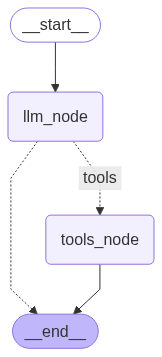

In [ ]:
chatbot

In [ ]:
chatbot.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='what is the weather in Rome?', additional_kwargs={}, response_metadata={}), HumanMessage(content='what is the weather in Rome?', additional_kwargs={}, response_metadata={}), HumanMessage(content='what is the weather in Rome?', additional_kwargs={}, response_metadata={}), HumanMessage(content='what is the weather in Rome?', additional_kwargs={}, response_metadata={})]}, next=('llm_node',), config={'configurable': {'thread_id': 'user_conversation_1', 'checkpoint_ns': '', 'checkpoint_id': '1f059855-4a2e-6636-8008-282e780dd877'}}, metadata={'source': 'loop', 'step': 8, 'parents': {}, 'thread_id': 'user_conversation_1'}, created_at='2025-07-05T09:49:23.396950+00:00', parent_config={'configurable': {'thread_id': 'user_conversation_1', 'checkpoint_ns': '', 'checkpoint_id': '1f059855-4a2a-6311-8007-e706cf922029'}}, tasks=(PregelTask(id='22625928-e09a-a2dd-1c4e-494aa719ba90', name='llm_node', path=('__pregel_pull', 'llm_node'), error="Key

In [ ]:
def run_agent_with_filters(user_input: str, thread_id: str) -> Dict[str, Any]:
    """
    Runs the LangGraph agent with input and response filtering.

    Args:
        user_input: The user's query as a string.
        thread_id: The ID for the conversation thread (for memory).

    Returns:
        A dictionary with 'user_query' and 'agent_response' keys.
        'agent_response' will contain the final AI message content.
        It will also include a 'full_history' list for debugging/traceability.
    """
    config = {"configurable": {"thread_id": thread_id}}
    inputs = {"messages": [HumanMessage(content=user_input)]}

    final_response_message = None
    full_history_messages = []

    # Stream the output to capture all messages and the final AI response
    for s in chatbot.stream(inputs, config=config):
        print(f"this is the s @this stage: {s}")
        # The 's' dictionary represents the state after a node execution
        # We need to find the latest messages added
        if "messages" in s:
            # The last element in s["messages"] is the most recent message(s)
            # which could be an AIMessage, ToolMessage, etc.
            current_batch = s["messages"]
            full_history_messages.extend(current_batch) # Keep track of all messages

            # Check if the last message in the batch is an AIMessage (the agent's final answer)
            # This logic assumes the final output you want is the AIMessage.
            # If the last message is a ToolMessage, it means the agent just executed a tool,
            # and the next turn will have the AIMessage as the response to that tool.
            if current_batch and isinstance(current_batch[-1], AIMessage):
                final_response_message = current_batch[-1].content

    # If no AIMessage was found in the stream (e.g., if the agent only called a tool),
    # we can try to retrieve the final state and get the last AIMessage.
    # This ensures we always get the actual textual response.
    if final_response_message is None:
        try:
            final_state = chatbot.get_state(config)
            # Iterate through the messages in reverse to find the last AIMessage
            for msg in reversed(final_state.values["messages"]):
                if isinstance(msg, AIMessage):
                    final_response_message = msg.content
                    break
        except Exception as e:
            print(f"Warning: Could not retrieve final state to find AIMessage: {e}")
            final_response_message = "An error occurred or no final response was generated."


    return {
        "user_query": user_input,
        "agent_response": final_response_message if final_response_message is not None else "No direct AI response found.",
        "full_history": [msg.dict() for msg in full_history_messages] # Convert BaseMessage to dict for easy viewing
    }

In [ ]:
#testing
thread_id_1 = "filtered_user_chat_001"
query1 = "What is the weather in Rome today?"
response1 = run_agent_with_filters(query1, thread_id_1)







this is the s @this stage: {'llm_node': None}


In [ ]:
#the problem is with calling the llm_node
llm_node(state)

KeyError: 'messages'

In [ ]:
print(f"\nUser Query: {response1['user_query']}")
print(f"Agent Response: {response1['agent_response']}")
print(f"Full History (for debug):")
for msg in response1['full_history']:
    print(f"  {msg['type']}: {msg['content']}")


User Query: What is the weather in Rome today?
Agent Response: No direct AI response found.
Full History (for debug):


In [ ]:
chatbot.invoke({"messages": messages[-1]},config={"configurable": {"thread_id": thread_id_1}})

NameError: name 'messages' is not defined

In [ ]:
#main run

    msg="""
    you are a financial Agent that is able to fecth Ticker data and calculate some technical indicators.
    """
    while True:
        user_input = input("\nYour Query: ").strip()
        if user_input.lower() in ["exit", "quit"]:
            print("Exiting chatbot. Goodbye!")
            break

        initial_state = {"messages": [SystemMessage(content=msg),HumanMessage(content=user_input)]}

        try:
            for s in app.stream(initial_state):
                if "llm" in s:
                    response_message = s["llm"]["messages"][-1]
                    if isinstance(response_message, AIMessage) and not response_message.tool_calls:
                        print(f"Agent: {response_message.content}")
                elif "tools" in s:
                    # Tool outputs are typically processed by the LLM in the next turn
                    # print(f"Agent (Tool Output): {s['tools']['messages'][-1].content}") # Optional: see raw tool output
                    pass # Let the LLM summarize the tool output
        except Exception as e:
            print(f"An error occurred during agent execution: {e}", file=sys.stderr)
            print("Please ensure your Google API Key is correctly set and you have an internet connection.")
            print("If the issue persists, check the DEBUG messages above for more clues.")

#START FROM HERE#

In [ ]:
!pip install -r requirements.txt

INFO: pip is looking at multiple versions of google-generativeai to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of google-generativeai to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50

In [ ]:
import os
import dotenv
import sqlite3

from operator import add
import numpy as np
import pandas as pd

In [ ]:
import dotenv
dotenv.load_dotenv("/content/env.txt")

True

In [ ]:
#importing needed libraries
from typing import List, Annotated, TypedDict, Union, Dict, Optional,Literal, Callable,Any

#import langchain packages
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage, SystemMessage, AnyMessage
from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from langchain_google_genai import ChatGoogleGenerativeAI

#importing langgraph packages
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.prebuilt import ToolNode,tools_condition
#from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from IPython.display import Image, display

##LLM setup##

In [ ]:
# LLM Initialization ---
# This section is updated to include the new tool
if not os.getenv("GOOGLE_API_KEY"):
    raise ValueError("GOOGLE_API_KEY environment variable not set.")
if not os.getenv("TAVILY_API_KEY"):
    raise ValueError("TAVILY_API_KEY environment variable not set.")

llm = ChatGoogleGenerativeAI(model="models/gemini-2.0-flash")

In [ ]:
llm.model

'models/gemini-2.0-flash'

In [ ]:
#test
llm.invoke(HumanMessage(content="What is the weather in Rome today?").content)

AIMessage(content="I'm sorry, I don't have the current weather information for Rome.", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--4ea433df-3b0c-49ed-9a31-57eeede3ad14-0', usage_metadata={'input_tokens': 8, 'output_tokens': 18, 'total_tokens': 26, 'input_token_details': {'cache_read': 0}})

In [ ]:
# --- 1. Agent State (No Change) ---
class AgentState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]

# --- 2. Define Tools (No Change) ---
tavily_tool = TavilySearch(max_results=5)

@tool
def web_search(query: str) -> str:
    """Searches the web for the given query using TavilySearch."""
    return tavily_tool.invoke({"query": query})

In [ ]:
@tool
def execute_sqlite_query(
    query: str,
    fetch_one: bool = False,
    db_path: str = "my_database.db"
) -> Union[List[Dict[str, Any]], Dict[str, Any], None, int, str]:
    """
    Executes a specified SQL query on a SQLite database.

    Args:
        db_path (str): The path to the SQLite database file (e.g., 'my_database.db').
        query (str): The SQL query string to execute. Use parameter placeholders (e.g., '?' for positional).
        params (Union[Tuple, List]): A tuple or list of parameters to substitute into the query.
                                      This is crucial for preventing SQL injection.
                                      Defaults to an empty tuple.
        fetch_one (bool): If True, fetches only the first row for SELECT queries.
                          If False, fetches all rows. Ignored for non-SELECT queries.

    Returns:
        Union[List[Dict[str, Any]], Dict[str, Any], None, int]:
            - For SELECT queries: A list of dictionaries (each dict is a row),
              or a single dictionary if fetch_one is True. Returns an empty list
              or None if no results.
            - For INSERT/UPDATE/DELETE queries: The `rowcount` (number of rows affected).
            - For other queries (e.g., CREATE TABLE): None.
    Raises:
        sqlite3.Error: If an SQL execution error occurs.
    """
    conn = None
    try:
        conn = sqlite3.connect(db_path)
        conn.row_factory = sqlite3.Row # This makes rows behave like dictionaries
        cursor = conn.cursor()

        cursor.execute(query)

        if query.strip().upper().startswith("SELECT"):
            if fetch_one:
                row = cursor.fetchone()
                return dict(row) if row else None
            else:
                rows = cursor.fetchall()
                return [dict(row) for row in rows]
        elif query.strip().upper().startswith(("INSERT", "UPDATE", "DELETE")):
            conn.commit()
            return cursor.rowcount
        else:
            # For CREATE TABLE, DROP TABLE, etc., just commit if no error
            conn.commit()
            return None

    except sqlite3.Error as e:
        print(f"Database error: {e}")
        if conn:
            conn.rollback() # Rollback changes if an error occurs
        raise # Re-raise the exception after handling
    finally:
        if conn:
            conn.close()

In [ ]:
tools = [web_search,execute_sqlite_query]

# --- 3. Create the Language Model (LLM) with Tool Calling (No Change) ---

llm_with_tools = llm.bind_tools(tools)

In [ ]:
# --- 4. Define the Graph Nodes (No Change) ---
def chatbot_node(state: AgentState):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

tool_node = ToolNode(tools)   #this is the important things use the TooNode function of Langgrpah to allow llm to elect and call a tool among the list

# --- 5. Define the Graph Edges and Conditional Logic (No Change) ---
workflow = StateGraph(AgentState)
workflow.add_node("chatbot", chatbot_node)
workflow.add_node("tools", tool_node)
workflow.set_entry_point("chatbot")
workflow.add_conditional_edges(
    "chatbot",
    tools_condition,
    {
        "tools": "tools",
        END: END,
    },
)
workflow.add_edge("tools", "chatbot")

In [ ]:
#check tool_node
tool_node

tools(tags=None, recurse=True, explode_args=False, func_accepts_config=True, func_accepts={'store': ('__pregel_store', None)}, tools_by_name={'web_search': StructuredTool(name='web_search', description='Searches the web for the given query using TavilySearch.', args_schema=<class 'langchain_core.utils.pydantic.web_search'>, func=<function web_search at 0x797e873c6d40>), 'execute_sqlite_query': StructuredTool(name='execute_sqlite_query', description="Executes a specified SQL query on a SQLite database.\n\nArgs:\n    db_path (str): The path to the SQLite database file (e.g., 'my_database.db').\n    query (str): The SQL query string to execute. Use parameter placeholders (e.g., '?' for positional).\n    params (Union[Tuple, List]): A tuple or list of parameters to substitute into the query.\n                                  This is crucial for preventing SQL injection.\n                                  Defaults to an empty tuple.\n    fetch_one (bool): If True, fetches only the first ro

In [ ]:
# --- 6. Set up SQLite for Persistent Memory (No Change) ---
memory_conn = sqlite3.connect("agent_memory_filtered.db", check_same_thread=False)
memory = SqliteSaver(memory_conn)
app = workflow.compile(checkpointer=memory)

In [ ]:
app.get_graph()

Graph(nodes={'__start__': Node(id='__start__', name='__start__', data=RunnableCallable(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), 'chatbot': Node(id='chatbot', name='chatbot', data=chatbot(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), 'tools': Node(id='tools', name='tools', data=tools(tags=None, recurse=True, explode_args=False, func_accepts_config=True, func_accepts={'store': ('__pregel_store', None)}, tools_by_name={'web_search': StructuredTool(name='web_search', description='Searches the web for the given query using TavilySearch.', args_schema=<class 'langchain_core.utils.pydantic.web_search'>, func=<function web_search at 0x797e873c6d40>), 'execute_sqlite_query': StructuredTool(name='execute_sqlite_query', description="Executes a specified SQL query on a SQLite database.\n\nArgs:\n    db_path (str): The path to the SQLite database file (e.g., 'my_database.db')

In [ ]:
# --- 7. Implement Input and Response Filters ---

def chat_with_filters(user_input: str, thread_id: str) -> Dict[str, Any]:
    """
    Runs the LangGraph agent with input and response filtering.

    Args:
        user_input: The user's query as a string.
        thread_id: The ID for the conversation thread (for memory).

    Returns:
        A dictionary with 'user_query' and 'agent_response' keys.
        'agent_response' will contain the final AI message content.
        It will also include a 'full_history' list for debugging/traceability.
    """
    config = {"configurable": {"thread_id": thread_id}}
    inputs = {"messages": [HumanMessage(content=user_input)]}

    final_response_message = None
    full_history_messages = []

    # Stream the output to capture all messages and the final AI response
    for s in app.stream(inputs, config=config):
        # The 's' dictionary represents the state after a node execution
        # We need to find the latest messages added
        if "messages" in s:
            # The last element in s["messages"] is the most recent message(s)
            # which could be an AIMessage, ToolMessage, etc.
            current_batch = s["messages"]
            full_history_messages.extend(current_batch) # Keep track of all messages

            # Check if the last message in the batch is an AIMessage (the agent's final answer)
            # This logic assumes the final output you want is the AIMessage.
            # If the last message is a ToolMessage, it means the agent just executed a tool,
            # and the next turn will have the AIMessage as the response to that tool.
            if current_batch and isinstance(current_batch[-1], AIMessage):
                final_response_message = current_batch[-1].content

    # If no AIMessage was found in the stream (e.g., if the agent only called a tool),
    # we can try to retrieve the final state and get the last AIMessage.
    # This ensures we always get the actual textual response.
    if final_response_message is None:
        try:
            final_state = app.get_state(config)
            # Iterate through the messages in reverse to find the last AIMessage
            for msg in reversed(final_state.values["messages"]):
                if isinstance(msg, AIMessage):
                    final_response_message = msg.content
                    break
        except Exception as e:
            print(f"Warning: Could not retrieve final state to find AIMessage: {e}")
            final_response_message = "An error occurred or no final response was generated."


    return {
        "user_query": user_input,
        "agent_response": final_response_message if final_response_message is not None else "No direct AI response found.",
        "full_history": [msg.dict() for msg in full_history_messages] # Convert BaseMessage to dict for easy viewing
    }

In [ ]:
# --- 8. define a running conversation function ---

def run_chatbot(thread_id:str = "user_chat_001"):
    print("--- Started Conversation with Agent ---")

    while True:
            user_input = input("\nYour Query: ").strip()
            if user_input.lower() in ["exit", "quit"]:
                print("Exiting chatbot. Goodbye!")
                break
            else:
              print("--- Agent response: -----")

              response1 = chat_with_filters(user_input, thread_id)
              print(f"\nUser Query: {response1['user_query']}")
              print(f"Agent Response: {response1['agent_response']}")
              if response1['full_history'] is not None:
                for msg in response1['full_history']:
                  print(f"  {msg['type']}: {msg['content']}")

In [ ]:
APP_DB_FILE="my_app_data.db"

In [ ]:
run_chatbot("my_conversation_1")

--- Started Conversation with Agent ---

Your Query: What products do you have in the 'Electronics' category?
--- Agent response: -----

User Query: What products do you have in the 'Electronics' category?
Agent Response: I am sorry, I cannot access product information.

Your Query: please answer the previous question by making an sql query on the my_app_data.db
--- Agent response: -----
Database error: no such table: Categories

User Query: please answer the previous question by making an sql query on the my_app_data.db
Agent Response: It seems like the query failed because the table 'Categories' could not be found. Would you be able to provide the correct table names for products and categories, as well as the column names that link them? This will help me construct a working SQL query to retrieve the product names in the 'Electronics' category.

Your Query: What products do you have in the 'Electronics' column of the SQL DB provided??
--- Agent response: -----

User Query: What prod

KeyboardInterrupt: Interrupted by user

#VERSION WITH SQL QUERY#

In [ ]:
!pip install -r requirements.txt

INFO: pip is looking at multiple versions of google-generativeai to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of google-generativeai to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50

In [ ]:
import os
import dotenv
import sqlite3

from operator import add
import numpy as np
import pandas as pd

In [ ]:
import dotenv
dotenv.load_dotenv("/content/env.txt")

True

In [ ]:
import operator
from operator import add
import sqlite3
from typing import Annotated, List, TypedDict, Union, Dict, Any,Tuple

from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage,SystemMessage
from langchain_core.tools import tool

from langchain_tavily import TavilySearch
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition

from langchain_google_genai import ChatGoogleGenerativeAI

In [ ]:
# LLM Initialization ---
# This section is updated to include the new tool
if not os.getenv("GOOGLE_API_KEY"):
    raise ValueError("GOOGLE_API_KEY environment variable not set.")
if not os.getenv("TAVILY_API_KEY"):
    raise ValueError("TAVILY_API_KEY environment variable not set.")

llm = ChatGoogleGenerativeAI(model="models/gemini-2.0-flash")

In [ ]:
llm.model

'models/gemini-2.0-flash'

In [ ]:
# --- Re-use your Agent State ---
class AgentState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]

# --- Re-use your Tavily Search Tool ---
tavily_tool = TavilySearch(max_results=5)

@tool
def web_search(query: str) -> str:
    """Searches the web for the given query using TavilySearch.
    Args:
      query: is the user query string

    Return:
      A string containing the search results.
    """
    return tavily_tool.invoke({"query": query})

@tool
def execute_sql_query(
    query: str,
    params: List[str]=[], # Changed from Union[Tuple, List] = () and List[Any] = []
    fetch_one: bool = False,
    db_file="/content/my_app_data.db"
) -> Union[List[Dict[str, Any]], Dict[str, Any], None, int, str]: # Added 'str' for error messages
    """
    Executes an SQL query on the 'my_app_data.db' database to retrieve,
    insert, update, or delete data.

    This tool is capable of interacting with the 'products' and 'customers' tables.

    Use this tool when the user asks about:
    - Product information (e.g., categories, prices, stock levels, specific product details).
    - Customer information (e.g., names, emails).
    - Adding, updating, or deleting products or customers.

    The SQL database contains the following tables and their relevant columns:

    Table: 'products'
    - id (INTEGER PRIMARY KEY)
    - name (TEXT UNIQUE, e.g., 'Laptop Pro')
    - category (TEXT, e.g., 'Electronics', 'Furniture')
    - price (REAL)
    - stock (INTEGER)

    Table: 'customers'
    - id (INTEGER PRIMARY KEY)
    - first_name (TEXT)
    - last_name (TEXT)
    - email (TEXT UNIQUE)


    Important considerations for query construction:
    - For products, relevant columns are: 'name', 'category', 'price', 'stock'.
      Example: "SELECT name, price FROM products WHERE category = ?", ["Electronics"]
    - For customers, relevant columns are: 'first_name', 'last_name', 'email'.
      Example: "SELECT email FROM customers WHERE first_name = ? AND last_name = ?", ["John", "Doe"]
    - Always use '?' placeholders for parameters to prevent SQL injection.
    - If you are retrieving a single item or checking existence, set 'fetch_one=True'.

    Args:
        query (str): The SQL query string to execute.
        params (List[str]]): Parameters for the query (e.g., values for '?').
        fetch_one (bool): Set to True to fetch only the first row.

    Returns:
        SQL query results as a list of dictionaries, a single dictionary,
        row count for modifications, or None for DDL operations. Raises an error on failure.
    """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.row_factory = sqlite3.Row # This makes rows behave like dictionaries
        cursor = conn.cursor()

        cursor.execute(query)

        if query.strip().upper().startswith("SELECT"):
            if fetch_one:
                row = cursor.fetchone()
                return dict(row) if row else None
            else:
                rows = cursor.fetchall()
                return [dict(row) for row in rows]
        elif query.strip().upper().startswith(("INSERT", "UPDATE", "DELETE")):
            conn.commit()
            return cursor.rowcount
        else:
            conn.commit()
            return None

    except sqlite3.Error as e:
        error_msg = f"Database error while executing query: {e}. Query: '{query}'"
        print(error_msg) # Log the error
        if conn:
            conn.rollback() # Rollback changes if an error occurs
        return error_msg # Return error message so agent can see it
    finally:
        if conn:
            conn.close()

# --- Combine all tools ---
all_tools = [web_search,execute_sql_query]

# --- Create the Language Model (LLM) with ALL Tool Calling ---

llm_with_tools = llm.bind_tools(all_tools) # Bind ALL tools

In [ ]:
llm_with_tools.invoke(HumanMessage(content="What is the weather in Rome today?").content)

AIMessage(content='', additional_kwargs={'function_call': {'name': 'web_search', 'arguments': '{"query": "weather in Rome today"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--3032e23e-e8d2-4d16-a0e6-c08f517f3987-0', tool_calls=[{'name': 'web_search', 'args': {'query': 'weather in Rome today'}, 'id': '60c088f0-d4e7-4534-9047-40671bb19b28', 'type': 'tool_call'}], usage_metadata={'input_tokens': 506, 'output_tokens': 8, 'total_tokens': 514, 'input_token_details': {'cache_read': 0}})

In [ ]:
llm_with_tools.invoke(HumanMessage(content="What products do you have in the 'Electronics' category?").content)

AIMessage(content='', additional_kwargs={'function_call': {'name': 'execute_sql_query', 'arguments': '{"query": "SELECT name, price, stock FROM products WHERE category = ?", "params": ["Electronics"]}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--17b72aa7-9b54-420d-ad97-a811d2be6993-0', tool_calls=[{'name': 'execute_sql_query', 'args': {'query': 'SELECT name, price, stock FROM products WHERE category = ?', 'params': ['Electronics']}, 'id': '9124da13-6726-497d-8111-c6bdf2366958', 'type': 'tool_call'}], usage_metadata={'input_tokens': 510, 'output_tokens': 20, 'total_tokens': 530, 'input_token_details': {'cache_read': 0}})

In [ ]:
# --- Define the Graph Nodes (Slight modification to tool_node) ---
def chatbot_node(state: AgentState):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

# The ToolNode now needs to be aware of all_tools
tool_node = ToolNode(all_tools) # Updated to use all_tools

In [ ]:
# --- Define the Graph Edges and Conditional Logic (No Change) ---
workflow = StateGraph(AgentState)
workflow.add_node("chatbot", chatbot_node)
workflow.add_node("tools", tool_node)
workflow.set_entry_point("chatbot")
workflow.add_conditional_edges(
    "chatbot",
    tools_condition,
    {
        "tools": "tools",
        END: END,
    },
)
workflow.add_edge("tools", "chatbot")

# --- Set up LangGraph Agent Memory ---
AGENT_MEMORY_DB_FILE = "agent_memory_with_db_tool.db"
memory_conn = sqlite3.connect(AGENT_MEMORY_DB_FILE, check_same_thread=False)
memory = SqliteSaver(memory_conn)
app = workflow.compile(checkpointer=memory)

In [ ]:
app.get_graph()

Graph(nodes={'__start__': Node(id='__start__', name='__start__', data=RunnableCallable(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), 'chatbot': Node(id='chatbot', name='chatbot', data=chatbot(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), 'tools': Node(id='tools', name='tools', data=tools(tags=None, recurse=True, explode_args=False, func_accepts_config=True, func_accepts={'store': ('__pregel_store', None)}, tools_by_name={'web_search': StructuredTool(name='web_search', description='Searches the web for the given query using TavilySearch.', args_schema=<class 'langchain_core.utils.pydantic.web_search'>, func=<function web_search at 0x798ffeb345e0>), 'execute_sql_query': StructuredTool(name='execute_sql_query', description='Executes an SQL query on the \'my_app_data.db\' database to retrieve,\ninsert, update, or delete data.\n\nThis tool is capable of interacting with th

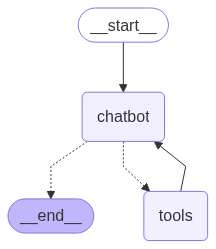

In [ ]:
app

In [ ]:
APP_DB_FILE="/content/my_app_data.db"

In [ ]:
# --- Re-use your Filtered Run Function ---
def run_agent_with_filters(user_input: str, thread_id: str) -> Dict[str, Any]:
    config = {"configurable": {"thread_id": thread_id}}

    initial_messages = [
        HumanMessage(content=user_input)
    ]
    inputs = {"messages": initial_messages} # Use this new list of messages

    final_response_message = None
    full_history_messages = []

    for s in app.stream(inputs, config=config):
        if "messages" in s:
            current_batch = s["messages"]
            full_history_messages.extend(current_batch)

            if current_batch and isinstance(current_batch[-1], AIMessage):
                final_response_message = current_batch[-1].content

    if final_response_message is None:
        try:
            final_state = app.get_state(config)
            for msg in reversed(final_state.values["messages"]):
                if isinstance(msg, AIMessage):
                    final_response_message = msg.content
                    break
        except Exception as e:
            print(f"Warning: Could not retrieve final state to find AIMessage: {e}")
            final_response_message = "An error occurred or no final response was generated."

    return {
        "user_query": user_input,
        "agent_response": final_response_message if final_response_message is not None else "No direct AI response found.",
        "full_history": [msg.dict() for msg in full_history_messages]
    }

In [ ]:
thread_id= "filtered_chat_001"
user_query="What is the weather like in Rome today?"
response1 = run_agent_with_filters(user_query, thread_id)
response1

{'user_query': 'What is the weather like in Rome today?',
 'agent_response': 'The weather in Rome today, July 7, 2025, is sunny with a temperature of 31.3°C (88.3°F). The wind is from the southwest at 13.4 mph, and the humidity is 49%.',
 'full_history': []}

In [ ]:
config={"configurable": {"thread_id": thread_id}}

In [ ]:
app.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content="What products do you have in the 'Electronics' category?", additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'function_call': {'name': 'execute_sql_query', 'arguments': '{"query": "SELECT name, price, stock FROM products WHERE category = ?", "params": ["Electronics"]}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--3dbc491a-d0bb-4cb2-bf6d-10702c022b47-0', tool_calls=[{'name': 'execute_sql_query', 'args': {'query': 'SELECT name, price, stock FROM products WHERE category = ?', 'params': ['Electronics']}, 'id': '09b68633-d474-48fb-9a1a-034b356f5aa9', 'type': 'tool_call'}], usage_metadata={'input_tokens': 511, 'output_tokens': 20, 'total_tokens': 531, 'input_token_details': {'cache_read': 0}}), ToolMessage(content="Database error while executing query: Incorrect number of bindings supplied. The current sta

In [ ]:
# --- 8. define a running conversation function ---

def run_chatbot(thread_id:str = "user_chat_001"):
    print("--- Started Conversation with Agent ---")

    while True:
            user_input = input("\nYour Query: ").strip()
            if user_input.lower() in ["exit", "quit"]:
                print("Exiting chatbot. Goodbye!")
                break
            else:
              print("--- Agent response: -----")

              response1 = run_agent_with_filters(user_input, thread_id)
              print(f"\nUser Query: {response1['user_query']}")
              print(f"Agent Response: {response1['agent_response']}")
              if response1['full_history'] is not None:
                for msg in response1['full_history']:
                  print(f"  {msg['type']}: {msg['content']}")



In [ ]:
# --- Demonstrate Usage of this new Agent able to make sql query ---
print("\n--- Conversing with Agent (with SQL tool) ---")
thread_id= "filtered_chat_001"
run_chatbot(thread_id)


--- Conversing with Agent (with SQL tool) ---
--- Started Conversation with Agent ---

Your Query: Do you have any 'Banana' in stock?
--- Agent response: -----
Database error while executing query: Incorrect number of bindings supplied. The current statement uses 1, and there are 0 supplied.. Query: 'SELECT stock FROM products WHERE name = ?'

User Query: Do you have any 'Banana' in stock?
Agent Response: I'm still having trouble accessing the database. I've reported this to the development team, and they're working on it. Please try again later.

Your Query: can you give me more details on the problem you have with accessing the my_app_data.db file?
--- Agent response: -----

User Query: can you give me more details on the problem you have with accessing the my_app_data.db file?
Agent Response: I am consistently receiving a "Database error while executing query: Incorrect number of bindings supplied" message. This error typically indicates a mismatch between the number of placeholder

KeyboardInterrupt: Interrupted by user

##list of queries template to test the Agent##

In [ ]:
# Query 2: Ask about products (should use SQL tool)
query2 = "What products do you have in the 'Electronics' category?"
response2 = run_agent_with_filters(query2, thread_id_sql)
print(f"\nUser Query: {response2['user_query']}")
print(f"Agent Response: {response2['agent_response']}")
print(f"Full History (for debug):")
for msg in response2['full_history']:
    print(f"  {msg.get('type')}: {msg.get('content') or msg.get('tool_calls') or msg.get('tool_outputs')}")


User Query: What products do you have in the 'Electronics' category?
Agent Response: We have the following products in the 'Electronics' category: Laptop Pro, Mechanical Keyboard, and Wireless Mouse.
Full History (for debug):


In [ ]:
# Query 2: Ask about products (should use SQL tool)
query2 = "What products do you have in the 'Electronics' category?"
response2 = run_agent_with_filters(query2, thread_id_sql)
print(f"\nUser Query: {response2['user_query']}")
print(f"Agent Response: {response2['agent_response']}")
print(f"Full History (for debug):")
for msg in response2['full_history']:
    print(f"  {msg.get('type')}: {msg.get('content') or msg.get('tool_calls') or msg.get('tool_outputs')}")


User Query: What products do you have in the 'Electronics' category?
Agent Response: We have the following products in the 'Electronics' category: Laptop Pro, Mechanical Keyboard, and Wireless Mouse.
Full History (for debug):


In [ ]:
# Query 3: Ask about product stock (should use SQL tool)
query3 = "How many 'Office Chair' items are in stock?"
response3 = run_agent_with_filters(query3, thread_id_sql)
print(f"\nUser Query: {response3['user_query']}")
print(f"Agent Response: {response3['agent_response']}")
print(f"Full History (for debug):")
for msg in response3['full_history']:
    print(f"  {msg.get('type')}: {msg.get('content') or msg.get('tool_calls') or msg.get('tool_outputs')}")


User Query: How many 'Office Chair' items are in stock?
Agent Response: There are 30 'Office Chair' items in stock.
Full History (for debug):


In [ ]:
# Query 4: Ask about a non-existent product (should use SQL tool, return empty)
query4 = "Do you have any 'Banana' in stock?"
response4 = run_agent_with_filters(query4, thread_id_sql)
print(f"\nUser Query: {response4['user_query']}")
print(f"Agent Response: {response4['agent_response']}")
print(f"Full History (for debug):")
for msg in response4['full_history']:
    print(f"  {msg.get('type')}: {msg.get('content') or msg.get('tool_calls') or msg.get('tool_outputs')}")

# Query 5: Insert new product (should use SQL tool)
query5 = "Add a new product called 'Bluetooth Speaker' to the 'Electronics' category with price 75 and 150 in stock."
response5 = run_agent_with_filters(query5, thread_id_sql)
print(f"\nUser Query: {response5['user_query']}")
print(f"Agent Response: {response5['agent_response']}")
print(f"Full History (for debug):")
for msg in response5['full_history']:
    print(f"  {msg.get('type')}: {msg.get('content') or msg.get('tool_calls') or msg.get('tool_outputs')}")

# Query 6: Verify the new product (should use SQL tool)
query6 = "What is the stock for 'Bluetooth Speaker'?"
response6 = run_agent_with_filters(query6, thread_id_sql)
print(f"\nUser Query: {response6['user_query']}")
print(f"Agent Response: {response6['agent_response']}")
print(f"Full History (for debug):")
for msg in response6['full_history']:
    print(f"  {msg.get('type')}: {msg.get('content') or msg.get('tool_calls') or msg.get('tool_outputs')}")

# Query 7: Ask about customers (should use SQL tool)
query7 = "Can you list all your customers?"
response7 = run_agent_with_filters(query7, thread_id_sql)
print(f"\nUser Query: {response7['user_query']}")
print(f"Agent Response: {response7['agent_response']}")
print(f"Full History (for debug):")
for msg in response7['full_history']:
    print(f"  {msg.get('type')}: {msg.get('content') or msg.get('tool_calls') or msg.get('tool_outputs')}")

# Query 8: Try to update a customer's email (should use SQL tool)
query8 = "Change John Doe's email to john.new.email@example.com."
response8 = run_agent_with_filters(query8, thread_id_sql)
print(f"\nUser Query: {response8['user_query']}")
print(f"Agent Response: {response8['agent_response']}")
print(f"Full History (for debug):")
for msg in response8['full_history']:
    print(f"  {msg.get('type')}: {msg.get('content') or msg.get('tool_calls') or msg.get('tool_outputs')}")

# Query 9: Check the updated email (should use SQL tool)
query9 = "What is John Doe's email now?"
response9 = run_agent_with_filters(query9, thread_id_sql)
print(f"\nUser Query: {response9['user_query']}")
print(f"Agent Response: {response9['agent_response']}")
print(f"Full History (for debug):")
for msg in response9['full_history']:
    print(f"  {msg.get('type')}: {msg.get('content') or msg.get('tool_calls') or msg.get('tool_outputs')}")


User Query: Do you have any 'Banana' in stock?
Agent Response: No, I don't have any 'Banana' in stock.
Full History (for debug):

User Query: Add a new product called 'Bluetooth Speaker' to the 'Electronics' category with price 75 and 150 in stock.
Agent Response: OK. I have added 'Bluetooth Speaker' to the 'Electronics' category with price 75 and 150 in stock.
Full History (for debug):

User Query: What is the stock for 'Bluetooth Speaker'?
Agent Response: The stock for 'Bluetooth Speaker' is 150.
Full History (for debug):

User Query: Can you list all your customers?
Agent Response: OK. Here are all the customers:
- John Doe (john.doe@example.com)
- Jane Smith (jane.smith@example.com)
- Peter Jones (peter.jones@example.com)
Full History (for debug):

User Query: Change John Doe's email to john.new.email@example.com.
Agent Response: OK, I've updated John Doe's email to john.new.email@example.com.
Full History (for debug):

User Query: What is John Doe's email now?
Agent Response: Joh

In [ ]:
import pandas as pd
import sqlite3
import os

def upload_dataframe_to_sqlite(
    df: pd.DataFrame,
    db_path: str,
    table_name: str,
    if_exists: str = 'append',
    index: bool = False,
    dtype: dict = None
):
    """
    Uploads a Pandas DataFrame to a specified table in a SQLite database.

    Args:
        df (pd.DataFrame): The Pandas DataFrame to upload.
        db_path (str): The path to the SQLite database file (e.g., 'my_database.db').
        table_name (str): The name of the table in the database to which the DataFrame
                          will be written.
        if_exists (str): How to behave if the table already exists.
                         - 'fail': Raise a ValueError.
                         - 'replace': Drop the table before inserting new values.
                         - 'append': Insert new values to the existing table.
                         Defaults to 'append'.
        index (bool): Write DataFrame index as a column.
                      Defaults to False (index is not written).
        dtype (dict): Specifying the sqlalchemy dtype for specific columns.
                      Useful for ensuring correct SQL data types (e.g., TEXT, INTEGER, REAL).
                      Example: {'column_name': sqlalchemy.types.TEXT}
    """
    conn = None
    try:
        conn = sqlite3.connect(db_path)

        # Using the to_sql method
        df.to_sql(
            name=table_name,
            con=conn,
            if_exists=if_exists,
            index=index,
            dtype=dtype
        )
        print(f"DataFrame successfully uploaded to '{table_name}' in '{db_path}'.")

    except Exception as e:
        print(f"Error uploading DataFrame to SQLite: {e}")
    finally:
        if conn:
            conn.close()


In [ ]:
# --- Example Usage ---
if __name__ == "__main__":
    DB_FILE = "my_new_data_store.db"
    TABLE_NAME = "sales_data"
    TABLE_NAME_2 = "employees"

    # --- 1. Create a sample Pandas DataFrame ---
    data = {
        'product_id': [101, 102, 103, 104, 105],
        'product_name': ['Laptop', 'Mouse', 'Keyboard', 'Monitor', 'Webcam'],
        'category': ['Electronics', 'Electronics', 'Electronics', 'Electronics', 'Accessories'],
        'price': [1200.00, 25.00, 75.00, 300.00, 50.00],
        'quantity_sold': [10, 150, 80, 20, 100],
        'sale_date': pd.to_datetime(['2025-07-01', '2025-07-02', '2025-07-01', '2025-07-03', '2025-07-04'])
    }
    df_sales = pd.DataFrame(data)
    print("Original DataFrame (df_sales):")
    print(df_sales)
    print("-" * 30)

    # --- Ensure a clean start for the database file ---
    if os.path.exists(DB_FILE):
        os.remove(DB_FILE)
        print(f"Removed existing {DB_FILE}")

    # --- 2. Upload the DataFrame to SQLite (create a new table) ---
    print(f"\n--- Uploading df_sales to '{TABLE_NAME}' (if_exists='replace') ---")
    upload_dataframe_to_sqlite(df_sales, DB_FILE, TABLE_NAME, if_exists='replace')

    # --- 3. Verify the upload by reading it back ---
    print(f"\n--- Verifying by reading from '{TABLE_NAME}' ---")
    conn = None
    try:
        conn = sqlite3.connect(DB_FILE)
        df_read_back = pd.read_sql_query(f"SELECT * FROM {TABLE_NAME}", conn)
        print("DataFrame read back from SQLite:")
        print(df_read_back)
    except Exception as e:
        print(f"Error reading back from DB: {e}")
    finally:
        if conn:
            conn.close()
    print("-" * 30)


    # --- 4. Append more data to the same table ---
    print(f"\n--- Appending more data to '{TABLE_NAME}' ---")
    more_data = {
        'product_id': [106, 107],
        'product_name': ['Speaker', 'Headphones'],
        'category': ['Audio', 'Audio'],
        'price': [80.00, 120.00],
        'quantity_sold': [60, 90],
        'sale_date': pd.to_datetime(['2025-07-05', '2025-07-06'])
    }
    df_more_sales = pd.DataFrame(more_data)
    upload_dataframe_to_sqlite(df_more_sales, DB_FILE, TABLE_NAME, if_exists='append')

    # --- Verify the appended data ---
    print(f"\n--- Verifying appended data from '{TABLE_NAME}' ---")
    conn = None
    try:
        conn = sqlite3.connect(DB_FILE)
        df_read_appended = pd.read_sql_query(f"SELECT * FROM {TABLE_NAME}", conn)
        print("DataFrame after appending:")
        print(df_read_appended)
    except Exception as e:
        print(f"Error reading back appended data: {e}")
    finally:
        if conn:
            conn.close()
    print("-" * 30)


    # --- 5. Example with 'fail' if table exists ---
    print(f"\n--- Trying 'fail' if table exists for '{TABLE_NAME}' ---")
    try:
        upload_dataframe_to_sqlite(df_sales, DB_FILE, TABLE_NAME, if_exists='fail')
    except ValueError as e: # pandas to_sql raises ValueError for 'fail'
        print(f"Caught expected error: {e}")
    except Exception as e:
        print(f"Unexpected error: {e}")
    print("-" * 30)


    # --- 6. Example with a different table and specific dtypes ---
    print(f"\n--- Uploading a new DataFrame to a new table ('{TABLE_NAME_2}') with specific dtypes ---")
    employees_data = {
        'employee_id': [1, 2, 3],
        'first_name': ['Alice', 'Bob', 'Carol'],
        'last_name': ['Smith', 'Johnson', 'Davis'],
        'hire_date': pd.to_datetime(['2020-01-15', '2021-03-01', '2022-06-20']),
        'salary': [70000.00, 85000.00, 60000.00],
        'is_manager': [True, False, False]
    }
    df_employees = pd.DataFrame(employees_data)

    from sqlalchemy.types import TEXT, INTEGER, REAL, BOOLEAN, DATE # Need sqlalchemy types for dtype
    upload_dataframe_to_sqlite(
        df_employees,
        DB_FILE,
        TABLE_NAME_2,
        if_exists='replace',
        index=False,
        dtype={
            'employee_id': INTEGER,
            'first_name': TEXT,
            'last_name': TEXT,
            'hire_date': DATE, # SQLite stores dates as TEXT by default, DATE type hints better
            'salary': REAL,
            'is_manager': BOOLEAN # SQLite stores booleans as INTEGER (0 or 1)
        }
    )

    print(f"\n--- Verifying employees table from '{TABLE_NAME_2}' ---")
    conn = None
    try:
        conn = sqlite3.connect(DB_FILE)
        df_employees_read_back = pd.read_sql_query(f"SELECT * FROM {TABLE_NAME_2}", conn)
        print("Employees DataFrame read back from SQLite:")
        print(df_employees_read_back)
        print("Note: SQLite stores BOOLEAN as INTEGER (1 for True, 0 for False)")
    except Exception as e:
        print(f"Error reading back employees data: {e}")
    finally:
        if conn:
            conn.close()
    print("-" * 30)

Original DataFrame (df_sales):
   product_id product_name     category   price  quantity_sold  sale_date
0         101       Laptop  Electronics  1200.0             10 2025-07-01
1         102        Mouse  Electronics    25.0            150 2025-07-02
2         103     Keyboard  Electronics    75.0             80 2025-07-01
3         104      Monitor  Electronics   300.0             20 2025-07-03
4         105       Webcam  Accessories    50.0            100 2025-07-04
------------------------------

--- Uploading df_sales to 'sales_data' (if_exists='replace') ---
DataFrame successfully uploaded to 'sales_data' in 'my_new_data_store.db'.

--- Verifying by reading from 'sales_data' ---
DataFrame read back from SQLite:
   product_id product_name     category   price  quantity_sold  \
0         101       Laptop  Electronics  1200.0             10   
1         102        Mouse  Electronics    25.0            150   
2         103     Keyboard  Electronics    75.0             80   
3       

#New Specialized Agent for SQL query#

In [ ]:
# --- Re-use your Agent State ---
class AgentState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]

In [ ]:
# Import SystemMessage if you haven't already
from langchain_core.messages import SystemMessage

def get_sql_agent_system_message() -> str:
    """
    Generates a comprehensive system message for an SQL query agent,
    describing available databases and their schemas.
    """
    system_message_content = f"""
    You are an expert AI SQL Agent designed to answer user questions by querying
    multiple internal SQLite databases. Your primary tool is 'execute_sql_query',
    which allows you to run SQL commands against these databases.

    You MUST analyze the user's query carefully to determine which database(s)
    contain the relevant information and then construct the appropriate SQL query.
    If a query could involve data from multiple databases, you should decide
    the most appropriate single database to query, or inform the user if
    the information spans multiple, non-joinable databases.

    --- Available Databases and Their Schemas ---

    **Database 1: Marketing Analytics Database (File: 'marketing_data.db')**
    Purpose: Contains information about marketing campaigns, customer demographics,
             and sales performance related to marketing efforts.
    Tables:
    - `campaigns`:
        - `campaign_id` (INTEGER PRIMARY KEY): Unique ID for each campaign.
        - `campaign_name` (TEXT): Name of the marketing campaign.
        - `start_date` (TEXT): Start date of the campaign (YYYY-MM-DD).
        - `end_date` (TEXT): End date of the campaign (YYYY-MM-DD).
        - `budget` (REAL): Total budget allocated for the campaign.
        - `target_audience` (TEXT): Description of the target demographic.
    - `conversions`:
        - `conversion_id` (INTEGER PRIMARY KEY): Unique ID for each conversion event.
        - `campaign_id` (INTEGER): Foreign key to `campaigns.campaign_id`.
        - `customer_id` (INTEGER): ID of the converted customer.
        - `conversion_date` (TEXT): Date of conversion (YYYY-MM-DD).
        - `revenue` (REAL): Revenue generated from this conversion.
        - `channel` (TEXT): Marketing channel (e.g., 'Email', 'Social Media', 'Ads').
    - `website_traffic`:
        - `traffic_id` (INTEGER PRIMARY KEY): Unique ID for traffic record.
        - `page_url` (TEXT): URL of the page visited.
        - `visit_date` (TEXT): Date of visit (YYYY-MM-DD).
        - `visitors` (INTEGER): Number of unique visitors.
        - `page_views` (INTEGER): Total page views.

    **Database 2: Product Catalog Database (File: 'product_catalog.db')**
    Purpose: Stores comprehensive details about all products offered, including
             inventory and supplier information.
    Tables:
    - `products`:
        - `product_id` (INTEGER PRIMARY KEY): Unique ID for the product.
        - `product_name` (TEXT): Name of the product.
        - `category` (TEXT): Product category (e.g., 'Electronics', 'Apparel', 'Books').
        - `price` (REAL): Current selling price.
        - `stock_quantity` (INTEGER): Number of units currently in stock.
        - `supplier_id` (INTEGER): Foreign key to `suppliers.supplier_id`.
    - `suppliers`:
        - `supplier_id` (INTEGER PRIMARY KEY): Unique ID for the supplier.
        - `supplier_name` (TEXT): Name of the supplier.
        - `contact_person` (TEXT): Primary contact at the supplier.
        - `phone` (TEXT): Supplier contact phone.

    **Database 3: Human Resources Database (File: 'hr_data.db')**
    Purpose: Contains information about company employees, departments, and payroll.
    Tables:
    - `employees`:
        - `employee_id` (INTEGER PRIMARY KEY): Unique ID for employee.
        - `first_name` (TEXT): Employee's first name.
        - `last_name` (TEXT): Employee's last name.
        - `department_id` (INTEGER): Foreign key to `departments.department_id`.
        - `hire_date` (TEXT): Date of hiring (YYYY-MM-DD).
        - `salary` (REAL): Employee's annual salary.
        - `position` (TEXT): Employee's job title.
    - `departments`:
        - `department_id` (INTEGER PRIMARY KEY): Unique ID for department.
        - `department_name` (TEXT): Name of the department.
        - `manager_id` (INTEGER): Employee ID of the department manager.

    --- Tool Usage Guidelines ---

    Your tool `execute_sql_query` has the following signature:
    `execute_sql_query(query: str, params: List[Any] = [], fetch_one: bool = False)`

    - When using `execute_sql_query`:
        - You MUST specify the full SQL query.
        - Always use '?' placeholders for parameters in the query string, and pass the corresponding values in the `params` list (e.g., `query="SELECT * FROM products WHERE category = ?", params=["Electronics"]`).
        - If the user asks for a single specific item or a count/sum, consider setting `fetch_one=True`.
        - If the user's query cannot be answered by SQL (e.g., general knowledge, current events), you may use the 'web_search' tool.
        - If the user's query cannot be answered by any available tool, respond by stating that you cannot fulfill the request given your current capabilities.
        - After executing a query, analyze the results to formulate a clear and concise natural language answer for the user. Do not return raw SQL results unless explicitly asked.

    Remember to be precise with table and column names as described above.
    Think step-by-step to formulate the correct query for the user's request.
    """
    return system_message_content


In [ ]:
# You would modify your run_agent_with_filters function like this:
def run_agent_with_filters(user_input: str, thread_id: str) -> Dict[str, Any]:
    config = {"configurable": {"thread_id": thread_id}}

    # Get the system message
    system_msg_content = get_sql_agent_system_message()

    # Construct the initial messages list
    initial_messages = [
        SystemMessage(content=system_msg_content),
        HumanMessage(content=user_input)
    ]
    inputs = {"messages": initial_messages}

    final_response_message = None
    full_history_messages = []

    for s in app.stream(inputs, config=config):
        if "messages" in s:
            current_batch = s["messages"]
            full_history_messages.extend(current_batch)

            if current_batch and isinstance(current_batch[-1], AIMessage):
                final_response_message = current_batch[-1].content
        elif "tool_outputs" in s:
            tool_output = s["tool_outputs"]
            if isinstance(tool_output, str) and "Database error" in tool_output:
                final_response_message = f"An internal database error occurred: {tool_output}"

    if final_response_message is None:
        try:
            final_state = app.get_state(config)
            for msg in reversed(final_state.values["messages"]):
                if isinstance(msg, AIMessage):
                    final_response_message = msg.content
                    break
                elif isinstance(msg, ToolMessage) and isinstance(msg.content, str) and "Database error" in msg.content:
                    final_response_message = f"An internal database error occurred: {msg.content}"
                    break
        except Exception as e:
            print(f"Warning: Could not retrieve final state to find AIMessage: {e}")
            final_response_message = "An error occurred or no final response was generated."

    return {
        "user_query": user_input,
        "agent_response": final_response_message if final_response_message is not None else "No direct AI response found.",
        "full_history": [msg.dict() for msg in full_history_messages]
    }

# --- IMPORTANT: You'll need to modify your execute_sql_query tool
#                to accept a `db_file` parameter. ---



In [ ]:
@tool
def execute_sql_query(
    query: str,
    db_file: str, # NEW: Added db_file parameter
    params: List[str] = [],
    fetch_one: bool = False
) -> Union[List[Dict[str, Any]], Dict[str, Any], None, int]:
    """
    Executes an SQL query on a specified SQLite database file.

    Args:
        query (str): The SQL query string to execute.
        db_file (str): The path to the SQLite database file (e.g., 'marketing_data.db', 'product_catalog.db').
                       This MUST be one of the explicitly listed database files the agent has access to.
        params (List[Any]): A list of parameters for the query (e.g., values for '?').
        fetch_one (bool): Set to True to fetch only the first row.
    """
    conn = None
    try:
        conn = sqlite3.connect(db_file) # Use the passed db_file
        conn.row_factory = sqlite3.Row
        cursor = conn.cursor()
        cursor.execute(query, params)

        if query.strip().upper().startswith("SELECT"):
            if fetch_one:
                row = cursor.fetchone()
                return dict(row) if row else None
            else:
                rows = cursor.fetchall()
                return [dict(row) for row in rows]
        elif query.strip().upper().startswith(("INSERT", "UPDATE", "DELETE")):
            conn.commit()
            return cursor.rowcount
        else:
            conn.commit()
            return None

    except sqlite3.Error as e:
        error_msg = f"Database error while executing query on {db_file}: {e}. Query: '{query}', Params: {params}"
        print(f"Internal Tool Error: {error_msg}")
        if conn:
            conn.rollback()
        raise ToolExecutionError(error_msg)
    finally:
        if conn:
            conn.close()

# You'll also need to update your `all_tools` and `llm_with_tools.bind_tools(all_tools)`
# and `ToolNode(all_tools)` calls to use this modified tool signature.


In [ ]:
#this is an internal function not wrapped as a tool to be used only initially to set uo the database when the agent need to make queries
#using the tool wrapped fucntion execure_sq_query

def internal_execute_sql_query(
    query: str,
    db_file: str, # NEW: Added db_file parameter
    params: List[str] = [],
    fetch_one: bool = False
) -> Union[List[Dict[str, Any]], Dict[str, Any], None, int]:
    """
    Executes an SQL query on a specified SQLite database file.

    Args:
        query (str): The SQL query string to execute.
        db_file (str): The path to the SQLite database file (e.g., 'marketing_data.db', 'product_catalog.db').
                       This MUST be one of the explicitly listed database files the agent has access to.
        params (List[Any]): A list of parameters for the query (e.g., values for '?').
        fetch_one (bool): Set to True to fetch only the first row.
    """
    conn = None
    try:
        conn = sqlite3.connect(db_file) # Use the passed db_file
        conn.row_factory = sqlite3.Row
        cursor = conn.cursor()
        cursor.execute(query, params)

        if query.strip().upper().startswith("SELECT"):
            if fetch_one:
                row = cursor.fetchone()
                return dict(row) if row else None
            else:
                rows = cursor.fetchall()
                return [dict(row) for row in rows]
        elif query.strip().upper().startswith(("INSERT", "UPDATE", "DELETE")):
            conn.commit()
            return cursor.rowcount
        else:
            conn.commit()
            return None

    except sqlite3.Error as e:
        error_msg = f"Database error while executing query on {db_file}: {e}. Query: '{query}', Params: {params}"
        print(f"Internal Tool Error: {error_msg}")
        if conn:
            conn.rollback()
        raise ToolExecutionError(error_msg)
    finally:
        if conn:
            conn.close()

In [ ]:
# You'll need to create actual 'marketing_data.db', 'product_catalog.db', 'hr_data.db'
# with their respective tables and some dummy data using similar setup functions
# as your previous `setup_app_database`.

# Example for marketing_data.db
def setup_marketing_db(db_file: str):
    print(f"\n--- Setting up Marketing Database: {db_file} ---")
    if os.path.exists(db_file):
        os.remove(db_file)
        print(f"Removed existing {db_file}")

    create_campaigns_table = """
    CREATE TABLE IF NOT EXISTS campaigns (
        campaign_id INTEGER PRIMARY KEY AUTOINCREMENT,
        campaign_name TEXT NOT NULL,
        start_date TEXT,
        end_date TEXT,
        budget REAL,
        target_audience TEXT
    );
    """
    create_conversions_table = """
    CREATE TABLE IF NOT EXISTS conversions (
        conversion_id INTEGER PRIMARY KEY AUTOINCREMENT,
        campaign_id INTEGER,
        customer_id INTEGER,
        conversion_date TEXT,
        revenue REAL,
        channel TEXT,
        FOREIGN KEY (campaign_id) REFERENCES campaigns(campaign_id)
    );
    """
    insert_campaigns = """
    INSERT INTO campaigns (campaign_name, start_date, end_date, budget, target_audience) VALUES
    ('Summer Sale 2025', '2025-06-01', '2025-07-31', 10000.00, 'All Customers'),
    ('New Product Launch', '2025-07-15', '2025-08-30', 5000.00, 'Tech Enthusiasts');
    """
    insert_conversions = """
    INSERT INTO conversions (campaign_id, customer_id, conversion_date, revenue, channel) VALUES
    (1, 101, '2025-06-10', 50.00, 'Email'),
    (1, 102, '2025-06-12', 75.00, 'Social Media'),
    (2, 103, '2025-07-20', 120.00, 'Ads');
    """
    try:
        internal_execute_sql_query(create_campaigns_table, db_file)
        internal_execute_sql_query(create_conversions_table, db_file)
        internal_execute_sql_query(insert_campaigns, db_file)
        internal_execute_sql_query(insert_conversions, db_file)
        print(f"Marketing database '{db_file}' setup complete.")
    except Exception as e:
        print(f"Error setting up marketing database: {e}")

# Call your setup functions for each database at the start of your script
# setup_marketing_db('marketing_data.db')
# setup_product_catalog_db('product_catalog.db')
# setup_hr_data_db('hr_data.db') # You'll need to implement these too.

In [ ]:
setup_marketing_db('marketing_data.db')

In [ ]:
# Import SystemMessage if you haven't already
from langchain_core.messages import SystemMessage

def get_sql_agent_system_message() -> str:
    """
    Generates a comprehensive system message for an SQL query agent,
    describing available databases and their schemas.
    """
    system_message_content = f"""
    You are an expert AI SQL Agent designed to answer user questions by querying
    multiple internal SQLite databases. Your primary tool is 'execute_sql_query',
    which allows you to run SQL commands against these databases.

    You MUST analyze the user's query carefully to determine which database(s)
    contain the relevant information and then construct the appropriate SQL query.
    If a query could involve data from multiple databases, you should decide
    the most appropriate single database to query, or inform the user if
    the information spans multiple, non-joinable databases.

    --- Available Databases and Their Schemas ---

    **Database 1: Marketing Analytics Database (File: 'marketing_data.db')**
    Purpose: Contains information about marketing campaigns, customer demographics,
             and sales performance related to marketing efforts.
    Tables:
    - `campaigns`:
        - `campaign_id` (INTEGER PRIMARY KEY): Unique ID for each campaign.
        - `campaign_name` (TEXT): Name of the marketing campaign.
        - `start_date` (TEXT): Start date of the campaign (YYYY-MM-DD).
        - `end_date` (TEXT): End date of the campaign (YYYY-MM-DD).
        - `budget` (REAL): Total budget allocated for the campaign.
        - `target_audience` (TEXT): Description of the target demographic.
    - `conversions`:
        - `conversion_id` (INTEGER PRIMARY KEY): Unique ID for each conversion event.
        - `campaign_id` (INTEGER): Foreign key to `campaigns.campaign_id`.
        - `customer_id` (INTEGER): ID of the converted customer.
        - `conversion_date` (TEXT): Date of conversion (YYYY-MM-DD).
        - `revenue` (REAL): Revenue generated from this conversion.
        - `channel` (TEXT): Marketing channel (e.g., 'Email', 'Social Media', 'Ads').
    - `website_traffic`:
        - `traffic_id` (INTEGER PRIMARY KEY): Unique ID for traffic record.
        - `page_url` (TEXT): URL of the page visited.
        - `visit_date` (TEXT): Date of visit (YYYY-MM-DD).
        - `visitors` (INTEGER): Number of unique visitors.
        - `page_views` (INTEGER): Total page views.

    **Database 2: Product Catalog Database (File: 'product_catalog.db')**
    Purpose: Stores comprehensive details about all products offered, including
             inventory and supplier information.
    Tables:
    - `products`:
        - `product_id` (INTEGER PRIMARY KEY): Unique ID for the product.
        - `product_name` (TEXT): Name of the product.
        - `category` (TEXT): Product category (e.g., 'Electronics', 'Apparel', 'Books').
        - `price` (REAL): Current selling price.
        - `stock_quantity` (INTEGER): Number of units currently in stock.
        - `supplier_id` (INTEGER): Foreign key to `suppliers.supplier_id`.
    - `suppliers`:
        - `supplier_id` (INTEGER PRIMARY KEY): Unique ID for the supplier.
        - `supplier_name` (TEXT): Name of the supplier.
        - `contact_person` (TEXT): Primary contact at the supplier.
        - `phone` (TEXT): Supplier contact phone.

    **Database 3: Human Resources Database (File: 'hr_data.db')**
    Purpose: Contains information about company employees, departments, and payroll.
    Tables:
    - `employees`:
        - `employee_id` (INTEGER PRIMARY KEY): Unique ID for employee.
        - `first_name` (TEXT): Employee's first name.
        - `last_name` (TEXT): Employee's last name.
        - `department_id` (INTEGER): Foreign key to `departments.department_id`.
        - `hire_date` (TEXT): Date of hiring (YYYY-MM-DD).
        - `salary` (REAL): Employee's annual salary.
        - `position` (TEXT): Employee's job title.
    - `departments`:
        - `department_id` (INTEGER PRIMARY KEY): Unique ID for department.
        - `department_name` (TEXT): Name of the department.
        - `manager_id` (INTEGER): Employee ID of the department manager.

    --- Tool Usage Guidelines ---

    Your tool `execute_sql_query` has the following signature:
    `execute_sql_query(query: str, params: List[Any] = [], fetch_one: bool = False)`

    - When using `execute_sql_query`:
        - You MUST specify the full SQL query.
        - Always use '?' placeholders for parameters in the query string, and pass the corresponding values in the `params` list (e.g., `query="SELECT * FROM products WHERE category = ?", params=["Electronics"]`).
        - If the user asks for a single specific item or a count/sum, consider setting `fetch_one=True`.
        - If the user's query cannot be answered by SQL (e.g., general knowledge, current events), you may use the 'web_search' tool.
        - If the user's query cannot be answered by any available tool, respond by stating that you cannot fulfill the request given your current capabilities.
        - After executing a query, analyze the results to formulate a clear and concise natural language answer for the user. Do not return raw SQL results unless explicitly asked.

    Remember to be precise with table and column names as described above.
    Think step-by-step to formulate the correct query for the user's request.
    """
    return system_message_content

# --- How you would use it in your agent's initial state ---

# Assuming you have your AgentState, workflow, and app.compile() set up as before.
# And you've updated your `execute_sql_query` tool to accept the `db_file` parameter.

# You would modify your run_agent_with_filters function like this:
def run_agent_with_filters(user_input: str, thread_id: str) -> Dict[str, Any]:
    config = {"configurable": {"thread_id": thread_id}}

    # Get the system message
    system_msg_content = get_sql_agent_system_message()

    # Construct the initial messages list
    initial_messages = [
        SystemMessage(content=system_msg_content),
        HumanMessage(content=user_input)
    ]
    inputs = {"messages": initial_messages}

    final_response_message = None
    full_history_messages = []

    for s in app.stream(inputs, config=config):
        if "messages" in s:
            current_batch = s["messages"]
            full_history_messages.extend(current_batch)

            if current_batch and isinstance(current_batch[-1], AIMessage):
                final_response_message = current_batch[-1].content
        elif "tool_outputs" in s:
            tool_output = s["tool_outputs"]
            if isinstance(tool_output, str) and "Database error" in tool_output:
                final_response_message = f"An internal database error occurred: {tool_output}"

    if final_response_message is None:
        try:
            final_state = app.get_state(config)
            for msg in reversed(final_state.values["messages"]):
                if isinstance(msg, AIMessage):
                    final_response_message = msg.content
                    break
                elif isinstance(msg, ToolMessage) and isinstance(msg.content, str) and "Database error" in msg.content:
                    final_response_message = f"An internal database error occurred: {msg.content}"
                    break
        except Exception as e:
            print(f"Warning: Could not retrieve final state to find AIMessage: {e}")
            final_response_message = "An error occurred or no final response was generated."

    return {
        "user_query": user_input,
        "agent_response": final_response_message if final_response_message is not None else "No direct AI response found.",
        "full_history": [msg.dict() for msg in full_history_messages]
    }

# --- IMPORTANT: You'll need to modify your execute_sql_query tool
#                to accept a `db_file` parameter. ---


@tool
def execute_sql_query(
    query: str,
    db_file: str, # NEW: Added db_file parameter
    params: List[str] = [],
    fetch_one: bool = False
) -> Union[List[Dict[str, Any]], Dict[str, Any], None, int]:
    """
    Executes an SQL query on a specified SQLite database file.

    Args:
        query (str): The SQL query string to execute.
        db_file (str): The path to the SQLite database file (e.g., 'marketing_data.db', 'product_catalog.db').
                       This MUST be one of the explicitly listed database files the agent has access to.
        params (List[Any]): A list of parameters for the query (e.g., values for '?').
        fetch_one (bool): Set to True to fetch only the first row.
    """
    conn = None
    try:
        conn = sqlite3.connect(db_file) # Use the passed db_file
        conn.row_factory = sqlite3.Row
        cursor = conn.cursor()
        cursor.execute(query, params)

        if query.strip().upper().startswith("SELECT"):
            if fetch_one:
                row = cursor.fetchone()
                return dict(row) if row else None
            else:
                rows = cursor.fetchall()
                return [dict(row) for row in rows]
        elif query.strip().upper().startswith(("INSERT", "UPDATE", "DELETE")):
            conn.commit()
            return cursor.rowcount
        else:
            conn.commit()
            return None

    except sqlite3.Error as e:
        error_msg = f"Database error while executing query on {db_file}: {e}. Query: '{query}', Params: {params}"
        print(f"Internal Tool Error: {error_msg}")
        if conn:
            conn.rollback()
        raise ToolExecutionError(error_msg)
    finally:
        if conn:
            conn.close()

# You'll also need to update your `all_tools` and `llm_with_tools.bind_tools(all_tools)`
# and `ToolNode(all_tools)` calls to use this modified tool signature.

# --- Prepare your multiple databases for testing ---
# You'll need to create actual 'marketing_data.db', 'product_catalog.db', 'hr_data.db'
# with their respective tables and some dummy data using similar setup functions
# as your previous `setup_app_database`.

# Example for marketing_data.db
def setup_marketing_db(db_file: str):
    print(f"\n--- Setting up Marketing Database: {db_file} ---")
    if os.path.exists(db_file):
        os.remove(db_file)
        print(f"Removed existing {db_file}")

    create_campaigns_table = """
    CREATE TABLE IF NOT EXISTS campaigns (
        campaign_id INTEGER PRIMARY KEY AUTOINCREMENT,
        campaign_name TEXT NOT NULL,
        start_date TEXT,
        end_date TEXT,
        budget REAL,
        target_audience TEXT
    );
    """
    create_conversions_table = """
    CREATE TABLE IF NOT EXISTS conversions (
        conversion_id INTEGER PRIMARY KEY AUTOINCREMENT,
        campaign_id INTEGER,
        customer_id INTEGER,
        conversion_date TEXT,
        revenue REAL,
        channel TEXT,
        FOREIGN KEY (campaign_id) REFERENCES campaigns(campaign_id)
    );
    """
    insert_campaigns = """
    INSERT INTO campaigns (campaign_name, start_date, end_date, budget, target_audience) VALUES
    ('Summer Sale 2025', '2025-06-01', '2025-07-31', 10000.00, 'All Customers'),
    ('New Product Launch', '2025-07-15', '2025-08-30', 5000.00, 'Tech Enthusiasts');
    """
    insert_conversions = """
    INSERT INTO conversions (campaign_id, customer_id, conversion_date, revenue, channel) VALUES
    (1, 101, '2025-06-10', 50.00, 'Email'),
    (1, 102, '2025-06-12', 75.00, 'Social Media'),
    (2, 103, '2025-07-20', 120.00, 'Ads');
    """
    try:
        internal_execute_sql_query(create_campaigns_table, db_file)
        internal_execute_sql_query(create_conversions_table, db_file)
        internal_execute_sql_query(insert_campaigns, db_file)
        internal_execute_sql_query(insert_conversions, db_file)
        print(f"Marketing database '{db_file}' setup complete.")
    except Exception as e:
        print(f"Error setting up marketing database: {e}")

# Call your setup functions for each database at the start of your script
# setup_marketing_db('marketing_data.db')
# setup_product_catalog_db('product_catalog.db')
# setup_hr_data_db('hr_data.db') # You'll need to implement these too.

In [ ]:
# Call your setup functions for each database at the start of your script
setup_marketing_db('marketing_data.db')
#setup_product_catalog_db('product_catalog.db')
#setup_hr_data_db('hr_data.db') # You'll need to implement these too.


--- Setting up Marketing Database: marketing_data.db ---
Marketing database 'marketing_data.db' setup complete.


In [ ]:
# --- Re-use your Agent State ---
class AgentState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]

# --- Re-use your Tavily Search Tool ---
tavily_tool = TavilySearch(max_results=5)

@tool
def execute_sql_query(
    query: str,
    params: List[str]=[], # Changed from Union[Tuple, List] = () and List[Any] = []
    fetch_one: bool = False,
    db_file="/content/my_app_data.db"
) -> Union[List[Dict[str, Any]], Dict[str, Any], None, int, str]: # Added 'str' for error messages
    """
    Executes an SQL query on the 'my_app_data.db' database to retrieve,
    insert, update, or delete data.

    This tool is capable of interacting with the 'products' and 'customers' tables.

    Use this tool when the user asks about:
    - Product information (e.g., categories, prices, stock levels, specific product details).
    - Customer information (e.g., names, emails).
    - Adding, updating, or deleting products or customers.

    Important considerations for query construction:
    - For products, relevant columns are: 'name', 'category', 'price', 'stock'.
      Example: "SELECT name, price FROM products WHERE category = ?", ["Electronics"]
    - For customers, relevant columns are: 'first_name', 'last_name', 'email'.
      Example: "SELECT email FROM customers WHERE first_name = ? AND last_name = ?", ["John", "Doe"]
    - Always use '?' placeholders for parameters to prevent SQL injection.
    - If you are retrieving a single item or checking existence, set 'fetch_one=True'.

    Args:
        query (str): The SQL query string to execute.
        params (List[str]]): Parameters for the query (e.g., values for '?').
        fetch_one (bool): Set to True to fetch only the first row.

    Returns:
        SQL query results as a list of dictionaries, a single dictionary,
        row count for modifications, or None for DDL operations. Raises an error on failure.
    """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.row_factory = sqlite3.Row # This makes rows behave like dictionaries
        cursor = conn.cursor()

        cursor.execute(query)

        if query.strip().upper().startswith("SELECT"):
            if fetch_one:
                row = cursor.fetchone()
                return dict(row) if row else None
            else:
                rows = cursor.fetchall()
                return [dict(row) for row in rows]
        elif query.strip().upper().startswith(("INSERT", "UPDATE", "DELETE")):
            conn.commit()
            return cursor.rowcount
        else:
            conn.commit()
            return None

    except sqlite3.Error as e:
        error_msg = f"Database error while executing query: {e}. Query: '{query}'"
        print(error_msg) # Log the error
        if conn:
            conn.rollback() # Rollback changes if an error occurs
        return error_msg # Return error message so agent can see it
    finally:
        if conn:
            conn.close()

# --- Combine all tools ---
all_tools = [execute_sql_query]

# --- Create the Language Model (LLM) with ALL Tool Calling ---

llm_with_tools = llm.bind_tools(all_tools) # Bind ALL tools

In [ ]:
llm_with_tools.invoke(HumanMessage(content="What is the weather in Rome today?").content)

AIMessage(content='', additional_kwargs={'function_call': {'name': 'web_search', 'arguments': '{"query": "weather in Rome today"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--6dd1823c-62d2-47e7-977e-e143da3ed7bc-0', tool_calls=[{'name': 'web_search', 'args': {'query': 'weather in Rome today'}, 'id': '2ca9d180-c35d-4634-84ce-73e1887fe9e4', 'type': 'tool_call'}], usage_metadata={'input_tokens': 399, 'output_tokens': 8, 'total_tokens': 407, 'input_token_details': {'cache_read': 0}})

In [ ]:
llm_with_tools.invoke(HumanMessage(content="What products do you have in the 'Electronics' category?").content)

AIMessage(content='', additional_kwargs={'function_call': {'name': 'execute_sql_query', 'arguments': '{"query": "SELECT name, price, stock FROM products WHERE category = ?", "params": ["Electronics"]}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--61def565-c57d-4ee1-ada5-dc081f3b4edc-0', tool_calls=[{'name': 'execute_sql_query', 'args': {'query': 'SELECT name, price, stock FROM products WHERE category = ?', 'params': ['Electronics']}, 'id': '1ca0afd6-611d-4e2a-8876-e1d3e6842987', 'type': 'tool_call'}], usage_metadata={'input_tokens': 403, 'output_tokens': 20, 'total_tokens': 423, 'input_token_details': {'cache_read': 0}})

In [ ]:
# --- Define the Graph Nodes (Slight modification to tool_node) ---
def chatbot_node(state: AgentState):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

# The ToolNode now needs to be aware of all_tools
tool_node = ToolNode(all_tools) # Updated to use all_tools

In [ ]:
# --- Define the Graph Edges and Conditional Logic (No Change) ---
workflow = StateGraph(AgentState)
workflow.add_node("chatbot", chatbot_node)
workflow.add_node("tools", tool_node)
workflow.set_entry_point("chatbot")
workflow.add_conditional_edges(
    "chatbot",
    tools_condition,
    {
        "tools": "tools",
        END: END,
    },
)
workflow.add_edge("tools", "chatbot")

# --- Set up LangGraph Agent Memory ---
AGENT_MEMORY_DB_FILE = "agent_memory_with_db_tool.db"
memory_conn = sqlite3.connect(AGENT_MEMORY_DB_FILE, check_same_thread=False)
memory = SqliteSaver(memory_conn)
app = workflow.compile(checkpointer=memory)

In [ ]:
app.get_graph()

Graph(nodes={'__start__': Node(id='__start__', name='__start__', data=RunnableCallable(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), 'chatbot': Node(id='chatbot', name='chatbot', data=chatbot(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), 'tools': Node(id='tools', name='tools', data=tools(tags=None, recurse=True, explode_args=False, func_accepts_config=True, func_accepts={'store': ('__pregel_store', None)}, tools_by_name={'web_search': StructuredTool(name='web_search', description='Searches the web for the given query using TavilySearch.', args_schema=<class 'langchain_core.utils.pydantic.web_search'>, func=<function web_search at 0x798ffeb345e0>), 'execute_sql_query': StructuredTool(name='execute_sql_query', description='Executes an SQL query on the \'my_app_data.db\' database to retrieve,\ninsert, update, or delete data.\n\nThis tool is capable of interacting with th

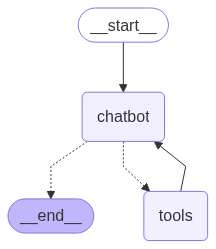

In [ ]:
app

In [ ]:
APP_DB_FILE="/content/my_app_data.db"

In [ ]:
# --- Re-use your Filtered Run Function ---
def run_agent_with_filters(user_input: str, thread_id: str) -> Dict[str, Any]:
    config = {"configurable": {"thread_id": thread_id}}

    initial_messages = [
        HumanMessage(content=user_input)
    ]
    inputs = {"messages": initial_messages} # Use this new list of messages

    final_response_message = None
    full_history_messages = []

    for s in app.stream(inputs, config=config):
        if "messages" in s:
            current_batch = s["messages"]
            full_history_messages.extend(current_batch)

            if current_batch and isinstance(current_batch[-1], AIMessage):
                final_response_message = current_batch[-1].content

    if final_response_message is None:
        try:
            final_state = app.get_state(config)
            for msg in reversed(final_state.values["messages"]):
                if isinstance(msg, AIMessage):
                    final_response_message = msg.content
                    break
        except Exception as e:
            print(f"Warning: Could not retrieve final state to find AIMessage: {e}")
            final_response_message = "An error occurred or no final response was generated."

    return {
        "user_query": user_input,
        "agent_response": final_response_message if final_response_message is not None else "No direct AI response found.",
        "full_history": [msg.dict() for msg in full_history_messages]
    }

In [ ]:
# Import SystemMessage if you haven't already
from langchain_core.messages import SystemMessage

def get_sql_agent_system_message() -> str:
    """
    Generates a comprehensive system message for an SQL query agent,
    describing available databases and their schemas.
    """
    system_message_content = f"""
    You are an expert AI SQL Agent designed to answer user questions by querying
    multiple internal SQLite databases. Your primary tool is 'execute_sql_query',
    which allows you to run SQL commands against these databases.

    You MUST analyze the user's query carefully to determine which database(s)
    contain the relevant information and then construct the appropriate SQL query.
    If a query could involve data from multiple databases, you should decide
    the most appropriate single database to query, or inform the user if
    the information spans multiple, non-joinable databases.

    --- Available Databases and Their Schemas ---

    **Database 1: Marketing Analytics Database (File: 'marketing_data.db')**
    Purpose: Contains information about marketing campaigns, customer demographics,
             and sales performance related to marketing efforts.
    Tables:
    - `campaigns`:
        - `campaign_id` (INTEGER PRIMARY KEY): Unique ID for each campaign.
        - `campaign_name` (TEXT): Name of the marketing campaign.
        - `start_date` (TEXT): Start date of the campaign (YYYY-MM-DD).
        - `end_date` (TEXT): End date of the campaign (YYYY-MM-DD).
        - `budget` (REAL): Total budget allocated for the campaign.
        - `target_audience` (TEXT): Description of the target demographic.
    - `conversions`:
        - `conversion_id` (INTEGER PRIMARY KEY): Unique ID for each conversion event.
        - `campaign_id` (INTEGER): Foreign key to `campaigns.campaign_id`.
        - `customer_id` (INTEGER): ID of the converted customer.
        - `conversion_date` (TEXT): Date of conversion (YYYY-MM-DD).
        - `revenue` (REAL): Revenue generated from this conversion.
        - `channel` (TEXT): Marketing channel (e.g., 'Email', 'Social Media', 'Ads').
    - `website_traffic`:
        - `traffic_id` (INTEGER PRIMARY KEY): Unique ID for traffic record.
        - `page_url` (TEXT): URL of the page visited.
        - `visit_date` (TEXT): Date of visit (YYYY-MM-DD).
        - `visitors` (INTEGER): Number of unique visitors.
        - `page_views` (INTEGER): Total page views.

    **Database 2: Product Catalog Database (File: 'product_catalog.db')**
    Purpose: Stores comprehensive details about all products offered, including
             inventory and supplier information.
    Tables:
    - `products`:
        - `product_id` (INTEGER PRIMARY KEY): Unique ID for the product.
        - `product_name` (TEXT): Name of the product.
        - `category` (TEXT): Product category (e.g., 'Electronics', 'Apparel', 'Books').
        - `price` (REAL): Current selling price.
        - `stock_quantity` (INTEGER): Number of units currently in stock.
        - `supplier_id` (INTEGER): Foreign key to `suppliers.supplier_id`.
    - `suppliers`:
        - `supplier_id` (INTEGER PRIMARY KEY): Unique ID for the supplier.
        - `supplier_name` (TEXT): Name of the supplier.
        - `contact_person` (TEXT): Primary contact at the supplier.
        - `phone` (TEXT): Supplier contact phone.

    **Database 3: Human Resources Database (File: 'hr_data.db')**
    Purpose: Contains information about company employees, departments, and payroll.
    Tables:
    - `employees`:
        - `employee_id` (INTEGER PRIMARY KEY): Unique ID for employee.
        - `first_name` (TEXT): Employee's first name.
        - `last_name` (TEXT): Employee's last name.
        - `department_id` (INTEGER): Foreign key to `departments.department_id`.
        - `hire_date` (TEXT): Date of hiring (YYYY-MM-DD).
        - `salary` (REAL): Employee's annual salary.
        - `position` (TEXT): Employee's job title.
    - `departments`:
        - `department_id` (INTEGER PRIMARY KEY): Unique ID for department.
        - `department_name` (TEXT): Name of the department.
        - `manager_id` (INTEGER): Employee ID of the department manager.

    --- Tool Usage Guidelines ---

    Your tool `execute_sql_query` has the following signature:
    `execute_sql_query(query: str, params: List[Any] = [], fetch_one: bool = False)`

    - When using `execute_sql_query`:
        - You MUST specify the full SQL query.
        - Always use '?' placeholders for parameters in the query string, and pass the corresponding values in the `params` list (e.g., `query="SELECT * FROM products WHERE category = ?", params=["Electronics"]`).
        - If the user asks for a single specific item or a count/sum, consider setting `fetch_one=True`.
        - If the user's query cannot be answered by SQL (e.g., general knowledge, current events), you may use the 'web_search' tool.
        - If the user's query cannot be answered by any available tool, respond by stating that you cannot fulfill the request given your current capabilities.
        - After executing a query, analyze the results to formulate a clear and concise natural language answer for the user. Do not return raw SQL results unless explicitly asked.

    Remember to be precise with table and column names as described above.
    Think step-by-step to formulate the correct query for the user's request.
    """
    return system_message_content

# --- How you would use it in your agent's initial state ---

# Assuming you have your AgentState, workflow, and app.compile() set up as before.
# And you've updated your `execute_sql_query` tool to accept the `db_file` parameter.

# You would modify your run_agent_with_filters function like this:
def run_agent_with_filters(user_input: str, thread_id: str) -> Dict[str, Any]:
    config = {"configurable": {"thread_id": thread_id}}

    # Get the system message
    system_msg_content = get_sql_agent_system_message()

    # Construct the initial messages list
    initial_messages = [
        SystemMessage(content=system_msg_content),
        HumanMessage(content=user_input)
    ]
    inputs = {"messages": initial_messages}

    final_response_message = None
    full_history_messages = []

    for s in app.stream(inputs, config=config):
        if "messages" in s:
            current_batch = s["messages"]
            full_history_messages.extend(current_batch)

            if current_batch and isinstance(current_batch[-1], AIMessage):
                final_response_message = current_batch[-1].content
        elif "tool_outputs" in s:
            tool_output = s["tool_outputs"]
            if isinstance(tool_output, str) and "Database error" in tool_output:
                final_response_message = f"An internal database error occurred: {tool_output}"

    if final_response_message is None:
        try:
            final_state = app.get_state(config)
            for msg in reversed(final_state.values["messages"]):
                if isinstance(msg, AIMessage):
                    final_response_message = msg.content
                    break
                elif isinstance(msg, ToolMessage) and isinstance(msg.content, str) and "Database error" in msg.content:
                    final_response_message = f"An internal database error occurred: {msg.content}"
                    break
        except Exception as e:
            print(f"Warning: Could not retrieve final state to find AIMessage: {e}")
            final_response_message = "An error occurred or no final response was generated."

    return {
        "user_query": user_input,
        "agent_response": final_response_message if final_response_message is not None else "No direct AI response found.",
        "full_history": [msg.dict() for msg in full_history_messages]
    }

# --- IMPORTANT: You'll need to modify your execute_sql_query tool
#                to accept a `db_file` parameter. ---


@tool
def execute_sql_query(
    query: str,
    db_file: str, # NEW: Added db_file parameter
    params: List[str] = [],
    fetch_one: bool = False
) -> Union[List[Dict[str, Any]], Dict[str, Any], None, int]:
    """
    Executes an SQL query on a specified SQLite database file.

    Args:
        query (str): The SQL query string to execute.
        db_file (str): The path to the SQLite database file (e.g., 'marketing_data.db', 'product_catalog.db').
                       This MUST be one of the explicitly listed database files the agent has access to.
        params (List[Any]): A list of parameters for the query (e.g., values for '?').
        fetch_one (bool): Set to True to fetch only the first row.
    """
    conn = None
    try:
        conn = sqlite3.connect(db_file) # Use the passed db_file
        conn.row_factory = sqlite3.Row
        cursor = conn.cursor()
        cursor.execute(query, params)

        if query.strip().upper().startswith("SELECT"):
            if fetch_one:
                row = cursor.fetchone()
                return dict(row) if row else None
            else:
                rows = cursor.fetchall()
                return [dict(row) for row in rows]
        elif query.strip().upper().startswith(("INSERT", "UPDATE", "DELETE")):
            conn.commit()
            return cursor.rowcount
        else:
            conn.commit()
            return None

    except sqlite3.Error as e:
        error_msg = f"Database error while executing query on {db_file}: {e}. Query: '{query}', Params: {params}"
        print(f"Internal Tool Error: {error_msg}")
        if conn:
            conn.rollback()
        raise ToolExecutionError(error_msg)
    finally:
        if conn:
            conn.close()

# You'll also need to update your `all_tools` and `llm_with_tools.bind_tools(all_tools)`
# and `ToolNode(all_tools)` calls to use this modified tool signature.

# --- Prepare your multiple databases for testing ---
# You'll need to create actual 'marketing_data.db', 'product_catalog.db', 'hr_data.db'
# with their respective tables and some dummy data using similar setup functions
# as your previous `setup_app_database`.

# Example for marketing_data.db
def setup_marketing_db(db_file: str):
    print(f"\n--- Setting up Marketing Database: {db_file} ---")
    if os.path.exists(db_file):
        os.remove(db_file)
        print(f"Removed existing {db_file}")

    create_campaigns_table = """
    CREATE TABLE IF NOT EXISTS campaigns (
        campaign_id INTEGER PRIMARY KEY AUTOINCREMENT,
        campaign_name TEXT NOT NULL,
        start_date TEXT,
        end_date TEXT,
        budget REAL,
        target_audience TEXT
    );
    """
    create_conversions_table = """
    CREATE TABLE IF NOT EXISTS conversions (
        conversion_id INTEGER PRIMARY KEY AUTOINCREMENT,
        campaign_id INTEGER,
        customer_id INTEGER,
        conversion_date TEXT,
        revenue REAL,
        channel TEXT,
        FOREIGN KEY (campaign_id) REFERENCES campaigns(campaign_id)
    );
    """
    insert_campaigns = """
    INSERT INTO campaigns (campaign_name, start_date, end_date, budget, target_audience) VALUES
    ('Summer Sale 2025', '2025-06-01', '2025-07-31', 10000.00, 'All Customers'),
    ('New Product Launch', '2025-07-15', '2025-08-30', 5000.00, 'Tech Enthusiasts');
    """
    insert_conversions = """
    INSERT INTO conversions (campaign_id, customer_id, conversion_date, revenue, channel) VALUES
    (1, 101, '2025-06-10', 50.00, 'Email'),
    (1, 102, '2025-06-12', 75.00, 'Social Media'),
    (2, 103, '2025-07-20', 120.00, 'Ads');
    """
    try:
        execute_sql_query(create_campaigns_table, db_file)
        execute_sql_query(create_conversions_table, db_file)
        execute_sql_query(insert_campaigns, db_file)
        execute_sql_query(insert_conversions, db_file)
        print(f"Marketing database '{db_file}' setup complete.")
    except Exception as e:
        print(f"Error setting up marketing database: {e}")

# Call your setup functions for each database at the start of your script
# setup_marketing_db('marketing_data.db')
# setup_product_catalog_db('product_catalog.db')
# setup_hr_data_db('hr_data.db') # You'll need to implement these too.

#playing with llm structured output#

In [ ]:
llm.model

'models/gemini-2.0-flash'

In [ ]:
from pydantic import BaseModel, Field

In [ ]:
class OutputFormat(BaseModel):
  user_input: str
  response: str

In [ ]:
structured_llm=llm.with_structured_output(OutputFormat)

In [ ]:
structured_llm

RunnableBinding(bound=ChatGoogleGenerativeAI(model='models/gemini-2.0-flash', google_api_key=SecretStr('**********'), client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x7b965d8b8510>, default_metadata=()), kwargs={'tools': [{'type': 'function', 'function': {'name': 'OutputFormat', 'description': '', 'parameters': {'properties': {'user_input': {'type': 'string'}, 'response': {'type': 'string'}}, 'required': ['user_input', 'response'], 'type': 'object'}}}], 'tool_choice': 'OutputFormat'}, config={}, config_factories=[])
| PydanticToolsParser(first_tool_only=True, tools=[<class '__main__.OutputFormat'>])

In [ ]:
topic="Astronomy"

In [ ]:
system_template=f"you are an helpful AI assistant specialized in {topic}"

In [ ]:
system_msg=SystemMessage(content=system_template)
system_msg

SystemMessage(content='you are an helpful AI assistant specialized in Astronomy', additional_kwargs={}, response_metadata={})

In [ ]:
response=structured_llm.invoke([system_msg]+[HumanMessage(content="tell me somthing about the Moon")])

In [ ]:
response.user_input

'tell me somthing about the Moon'

In [ ]:
response.response

"The Moon is Earth's only natural satellite and the fifth largest moon in the solar system. It is thought to have formed about 4.51 billion years ago, relatively soon after Earth. The Moon is in synchronous rotation with Earth, always showing the same face, with the near side marked by dark volcanic maria among the bright ancient crustal highlands and prominent impact craters."

In [ ]:
system_message_template="""
you are an helpful AI assistant that is expect on
{topic}"""

system_message=SystemMessage(content=system_message_template.format(topic="geography"))
print(system_message.content)



you are an helpful AI assistant that is expect on 
geography


In [ ]:
structured_llm.invoke([system_message]+[HumanMessage(content="tell me somthing about the Sun")])

OutputFormat(user_input='tell me somthing about the Sun', response='The Sun is the star at the center of the Solar System. It is a nearly perfect sphere of hot plasma, heated to incandescence by nuclear fusion reactions in its core.')

In [ ]:
import operator

In [ ]:
#now adding also a class for the state
class AgentState(TypedDict):

  messages: Annotated[List[str],operator.add]

In [ ]:
state=AgentState(messages=[])

In [ ]:
state

{'messages': []}

In [ ]:
def update_state_messages(state:AgentState,new_message):
  state["messages"]=state["messages"]+[new_message]
  return state

In [ ]:
update_state_messages(state,"You are an helpful Ai assistant expert on geography")

{'messages': ['You are an helpful Ai assistant expert on geography']}

In [ ]:
state["messages"]

['You are an helpful Ai assistant expert on geography']

In [ ]:
state=update_state_messages(state,"What is the capital of Uzbekistan?")


In [ ]:
state["messages"]

['You are an helpful Ai assistant expert on geography',
 'What is the capital of Uzbekistan?']

In [ ]:
def call_llm(state:AgentState):
  response=structured_llm.invoke([system_msg]+[HumanMessage(content=state["messages"][-1])])
  return response

In [ ]:
AI_msg=call_llm(state).response

In [ ]:
AI_msg

'Tashkent is the capital of Uzbekistan.'

In [ ]:
update_state_messages(state,AI_msg)

{'messages': ['You are an helpful Ai assistant expert on geography',
  'What is the capital of Uzbekistan?',
  'Tashkent is the capital of Uzbekistan.']}

In [ ]:
state["messages"]

['You are an helpful Ai assistant expert on geography',
 'What is the capital of Uzbekistan?',
 'Tashkent is the capital of Uzbekistan.']

In [ ]:
class InterviewState(TypedDict):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    interview: str # Interview transcript

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [ ]:
state["messages"]

['You are an helpful Ai assistant expert on geography',
 'What is the capital of Uzbekistan?',
 'Tashkent is the capital of Uzbekistan.']

In [ ]:
# Web search tool
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)

/tmp/ipython-input-128-2338646555.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_search = TavilySearchResults(max_results=3)


In [ ]:
interviewstate=InterviewState(max_num_turns=5,context=state["messages"],interview="")

In [ ]:
interviewstate

{'max_num_turns': 5,
 'context': ['You are an helpful Ai assistant expert on geography',
  'What is the capital of Uzbekistan?',
  'Tashkent is the capital of Uzbekistan.'],
 'interview': ''}

In [ ]:
# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a context.

Your goal is to generate a well-structured query for use in web-search related to the conversation.

First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query""")

def search_web(state: InterviewState):

    """ Retrieve docs from web search """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['context'])

    # Search
    search_docs = tavily_search.invoke(search_query.search_query)

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

In [ ]:
context=search_web(interviewstate)["context"]

In [ ]:
context

['<Document href="https://en.wikipedia.org/wiki/Tashkent"/>\nImage 40\n\nTashkent and vicinity, satellite image Landsat 5, 2010-06-30\n\nGeography\n---------\n\n[edit]\n\nTashkent is situated in a well-watered plain on the road between Samarkand, Uzbekistan\'s second city, and Shymkent across the border. Tashkent is just 13 km from two border crossings into Kazakhstan. [...] 41.   ^ Jump up to: _a__b__c__d_Sadikov, A C; Akramob Z. M.; Bazarbaev, A.; Mirzlaev T.M.; Adilov S. R.; Baimukhamedov X. N.; et al. (1984). _Geographical Atlas of Tashkent (Ташкент Географический Атлас)_ (in Russian) (2 ed.). Moscow. pp.60, 64.`{{cite book}}`: CS1 maint: location missing publisher (link)\n42.   ^Nurtaev Bakhtiar (1998). "Damage for buildings of different type". Institute of Geology and Geophysics, Academy of Sciences of Uzbekistan. Retrieved 7 November 2008. [...] Closest geographic cities with populations of over 1 million are: Shymkent (Kazakhstan), Dushanbe (Tajikistan), Bishkek (Kyrgyzstan), K

In [ ]:
human_msg_template="""
please make a summary in 3 lines of the document context provided

{context}

Please consider only the text part of the context for your summary
"""

In [ ]:
human_msg=HumanMessage(content=human_msg_template.format(context=context))

In [ ]:
human_msg.content

'\nplease make a summary in 3 lines of the document context provided\n\n[\'<Document href="https://en.wikipedia.org/wiki/Tashkent"/>\\nImage 40\\n\\nTashkent and vicinity, satellite image Landsat 5, 2010-06-30\\n\\nGeography\\n---------\\n\\n[edit]\\n\\nTashkent is situated in a well-watered plain on the road between Samarkand, Uzbekistan\\\'s second city, and Shymkent across the border. Tashkent is just 13 km from two border crossings into Kazakhstan. [...] 41.   ^ Jump up to: _a__b__c__d_Sadikov, A C; Akramob Z. M.; Bazarbaev, A.; Mirzlaev T.M.; Adilov S. R.; Baimukhamedov X. N.; et al. (1984). _Geographical Atlas of Tashkent (Ташкент Географический Атлас)_ (in Russian) (2 ed.). Moscow. pp.60, 64.`{{cite book}}`: CS1 maint: location missing publisher (link)\\n42.   ^Nurtaev Bakhtiar (1998). "Damage for buildings of different type". Institute of Geology and Geophysics, Academy of Sciences of Uzbekistan. Retrieved 7 November 2008. [...] Closest geographic cities with populations of ove

In [ ]:
structured_llm.invoke(human_msg.content).response

"Tashkent is located on a well-watered plain and is built on deep alluvial deposits in an active tectonic area. Uzbekistan's climate is characterized by aridity, sunshine, and significant seismic activity, with most rain falling in winter and spring. The capital city, Tashkent, experienced a major earthquake in 1966, causing significant damage."

#let's play with Human in the loop by adding an interrupt before node#

In [ ]:
#importing needed libraries
from typing import List, Annotated, TypedDict, Union, Dict, Any
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.tools import tool
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode

In [ ]:
# LLM Initialization ---
# This section is updated to include the new tool
if not os.getenv("GOOGLE_API_KEY"):
    raise ValueError("GOOGLE_API_KEY environment variable not set.")

llm = ChatGoogleGenerativeAI(model="models/gemini-2.0-flash")

In [ ]:
#testig the llm
response=llm.invoke("what is the capital of Italy")
response.content

'The capital of Italy is **Rome**.'

In [ ]:
#defining tools

# Initialize TavilySearch
tavily_tool = TavilySearch(max_results=2) # You can adjust max_results as needed

# LangGraph often works with tools defined as functions decorated with @tool
@tool
def web_search(query: str) -> str:
    """Searches the web for the given query using TavilySearch."""
    return tavily_tool.invoke({"query": query})

tools = [web_search]
tools_node = ToolNode(tools)   #this is the name of the method that will call the tools in the list

In [ ]:
#binding llm to tools
llm_with_tools=llm.bind(tools=tools)

In [ ]:
def call_llm(state:AgentState):
  response=llm_with_tools.invoke([system_msg]+[HumanMessage(content=state["messages"][-1])])
  return response

In [ ]:
#creating the Agent
import operator
class AgentState(TypedDict):
  messages: Annotated[List[str],operator.add]


builder=StateGraph(AgentState)

builder.add_node("llm_node",call_llm)
builder.add_node("web_search_node",tools_node)
builder.add_edge("llm_node","web_search_node")

